In [7]:
"""
Imports
"""
import numpy as np
import pickle
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import copy
from collections import defaultdict
%matplotlib inline

## Camera Calibration

In [8]:
import pickle
import sys

def undistort_image(x_count, y_count, img, use_cache=True, image_dir='camera_cal/calibration*.jpg'):
    """
    Get the mtx and dist matrices that are used to undistort an image.
    Either load these from a saved cache, or calculate them if needed.
    
    x_count: number of inside corners in x direction (left to right)
    y_count: number of inside corners in y direction (top to bottom)
    image_dir: path where chess board images are located: 'camera_cal/*.jpg'
    img_size: can either be (width, height), or (height, width). Both appear to work
    img: distorted image to undistort
    
    Returns:
    undist: undistorted image
    """
    pickle_path = "camera_cal/camera_pickle.p"
    if use_cache:
        try:
            dist_pickle = pickle.load( open( pickle_path, "rb" ) )
            #print("using cached mtx, dst values to undistort image")
            return cv2.undistort(img, dist_pickle['mtx'], dist_pickle['dist'], None, dist_pickle['mtx'])
        except:
            print("error loading mtx and dst from cache, recalculating them...{}".format(sys.exc_info()))
    else:
        print("recalculating mtx and dst...")
        pass
    
    
    objp = np.zeros((x_count*y_count,3), np.float32)
    objp[:,:2] = np.mgrid[0:x_count, 0:y_count].T.reshape(-1,2)
    images = glob.glob(image_dir)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img_tmp = cv2.imread(fname)
        gray = cv2.cvtColor(img_tmp, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x_count,y_count), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
        else:
            print("could not find corners for {}".format(fname))
            pass
    
    # Do camera calibration given object points and image points
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    if ret:
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump( dist_pickle, open( pickle_path, "wb" ) )
        return cv2.undistort(img, mtx, dist, None, mtx)
    else:
        print("could not calibrate camera")
        return None

recalculating mtx and dst...
could not find corners for camera_cal/calibration1.jpg
could not find corners for camera_cal/calibration4.jpg
could not find corners for camera_cal/calibration5.jpg


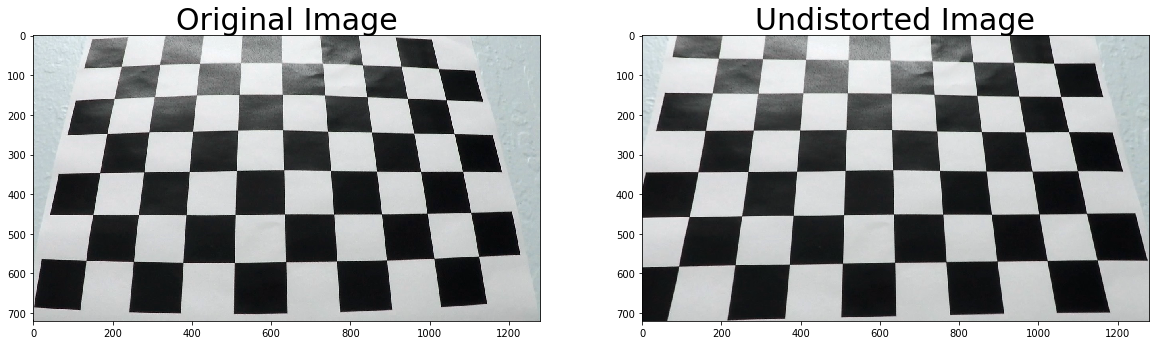

In [9]:
"""
Test undistort_image
"""

img = cv2.imread('camera_cal/calibration3.jpg')
dst = undistort_image(x_count=9,
                      y_count=6,
                      img=img,
                      use_cache=False,
                      image_dir='camera_cal/calibration*.jpg')
cv2.imwrite('camera_cal/test_undist_3.jpg',dst)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(dst);
ax2.set_title('Undistorted Image', fontsize=30);

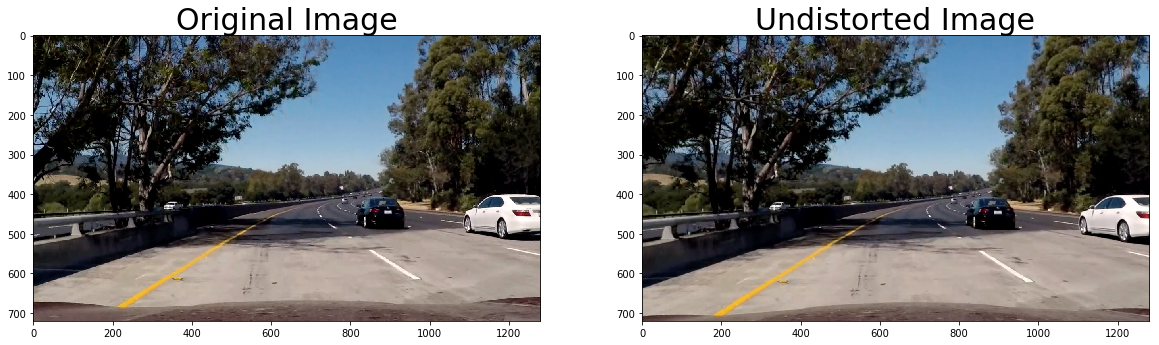

In [10]:
"""
undistort a road image
"""
import cv2
img = cv2.imread('test_images/test5.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')
cv2.imwrite('/output_images/road_undistorted.jpg',undist)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Original Image', fontsize=30);
ax2.imshow(undist);
ax2.set_title('Undistorted Image', fontsize=30);

## Binarize image

In [11]:
def abs_sobel_thresh(img, sobel_kernel=3, threshx=(50, 100),threshy=(50, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    scaled_sobelx = np.uint8(255 * np.absolute(sobelx) / np.max(np.absolute(sobelx)))
    scaled_sobely = np.uint8(255 * np.absolute(sobely) / np.max(np.absolute(sobely)))
    grad_binaryx, grad_binaryy = np.zeros_like(scaled_sobelx), np.zeros_like(scaled_sobely)
    grad_binaryx[(scaled_sobelx >= threshx[0]) & (scaled_sobelx < threshx[1])] = 1
    grad_binaryy[(scaled_sobely >= threshy[0]) & (scaled_sobely < threshy[1])] = 1
    return grad_binaryx, grad_binaryy

def mag_thresh(image, sobel_kernel=3, mag_thresh=(80, 120)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255 * mag / np.max(mag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/4)):
    """
    by default, I'll have it look for gradients that are between 0 and 45 degrees
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    theta = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(theta)
    dir_binary[(theta >= thresh[0]) & (theta < thresh[1])] = 1
    return dir_binary

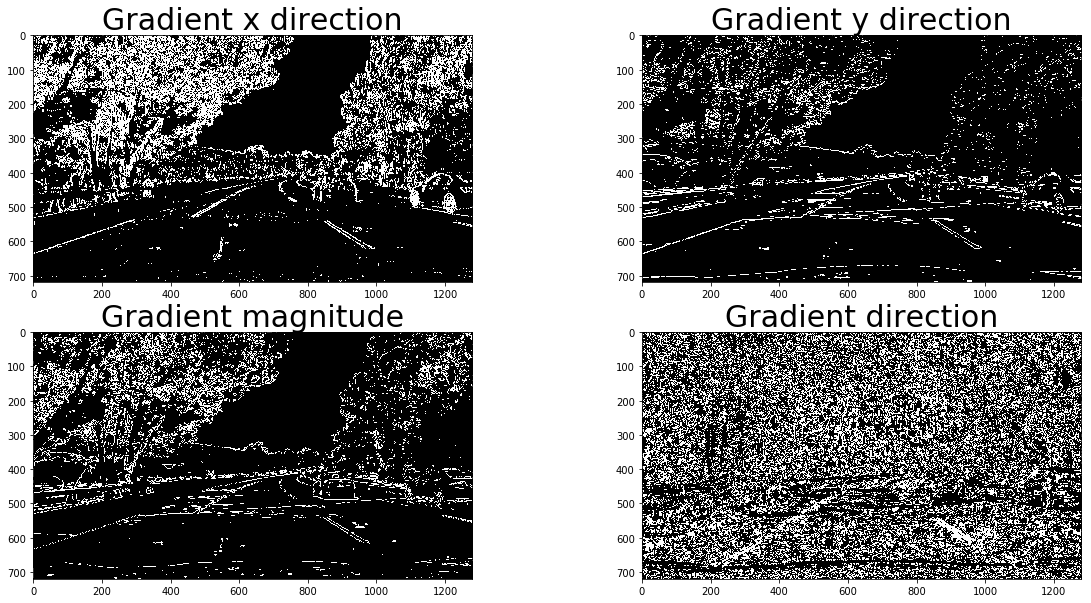

In [12]:
img = cv2.imread('test_images/test5.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

# Choose a Sobel kernel size
ksize = 5# Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(10, 250), threshy=(30,120))
mag_binary = mag_thresh(undist, sobel_kernel=5, mag_thresh=(30, 80))
dir_binary = dir_thresh(undist, sobel_kernel=15, thresh=(0.7, 1.3))

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10));
ax1.imshow(gradx, cmap='gray');
ax1.set_title('Gradient x direction', fontsize=30);
ax2.imshow(grady, cmap='gray');
ax2.set_title('Gradient y direction', fontsize=30);
ax3.imshow(mag_binary, cmap='gray');
ax3.set_title('Gradient magnitude', fontsize=30);
ax4.imshow(dir_binary, cmap='gray');
ax4.set_title('Gradient direction', fontsize=30);

In [13]:
def red_thresh(img, thresh=(200,255)):
    """
    img: image is in RGB
    """
    r = img[:,:,0] #get red
    red_binary = np.zeros_like(r)
    red_binary[ (r >= thresh[0]) & (r < thresh[1])] = 1
    return red_binary

def saturation_thresh(img, thresh=(90,255)):
    """
    Assume img is RGB
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[ (s >= thresh[0]) & (s < thresh[1]) ] = 1
    return s_binary

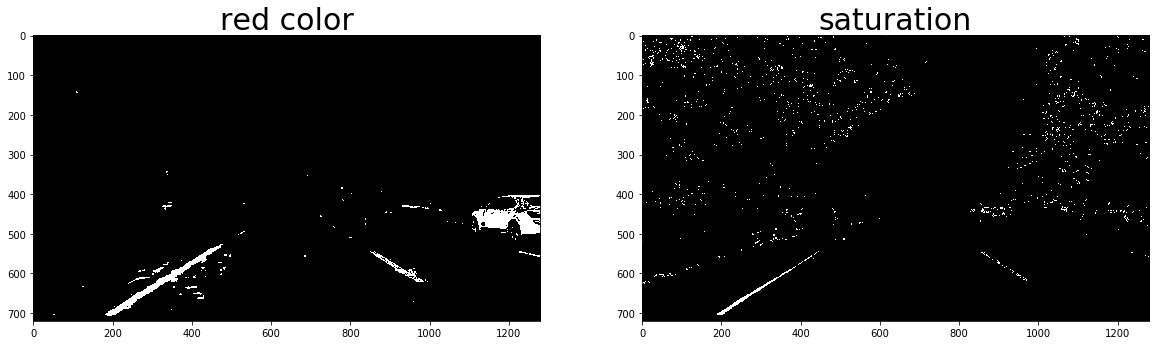

In [14]:
img = cv2.imread('test_images/test5.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

red_binary = red_thresh(undist, thresh=(200,255))
s_binary = saturation_thresh(undist, thresh=(200,255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(red_binary, cmap='gray');
ax1.set_title("red color", fontsize=30);
ax2.imshow(s_binary, cmap = 'gray');
ax2.set_title("saturation", fontsize=30);

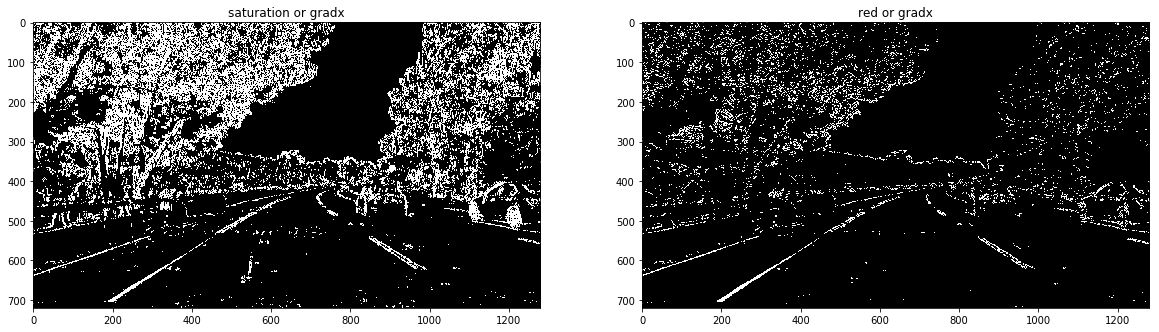

In [15]:
"""
Combine thresholds 

x threshold looks the cleanest of the gradient thresholds.
saturation is better than red.
Saturation alone is best; it removes shadows.
If I use (or) gradx, I add some lane lines that are not found with saturation alone,
without adding shadows.
"""
img = cv2.imread('test_images/test5.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

red_binary = red_thresh(undist, thresh=(200,255))
s_binary = saturation_thresh(undist, thresh=(200,255))
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(10, 255), threshy=(30,150))

combo_binary1 = np.zeros_like(s_binary)
combo_binary1[ (s_binary == 1) | (gradx == 1) ] = 1

combo_binary2 = np.zeros_like(s_binary)
combo_binary2[ (s_binary == 1) |( (gradx ==1) & (grady ==1) ) ] = 1

cv2.imwrite('/output_images/road_binarized.jpg',combo_binary1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));

ax1.imshow(combo_binary1, cmap='gray');
ax1.set_title("saturation or gradx");
ax2.imshow(combo_binary2, cmap = 'gray');
ax2.set_title("red or gradx");

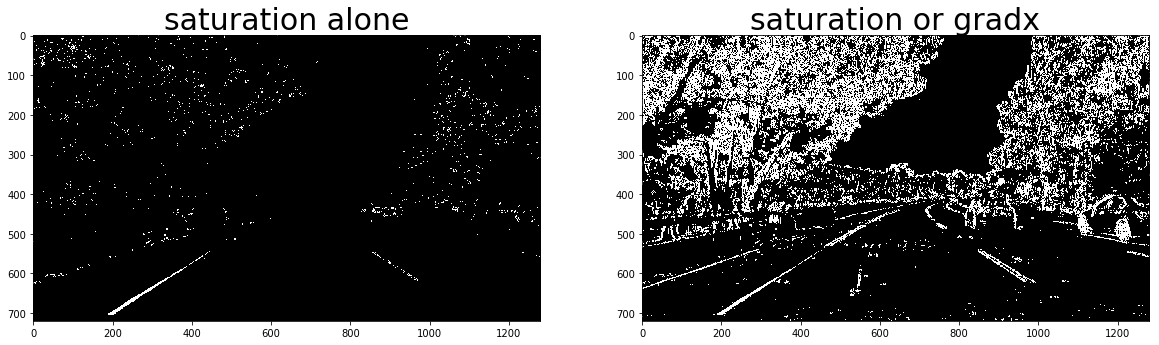

In [16]:
"""
Combine thresholds.
I plan to use gradx and saturation.
Fine tune gradx thresholds

"""
img = cv2.imread('test_images/test5.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

s_binary = saturation_thresh(undist, thresh=(200,255))
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(10, 255), threshy=(30,150))

combo_binary1 = np.zeros_like(s_binary)
combo_binary1[ ( s_binary == 1)] = 1

combo_binary2 = np.zeros_like(s_binary)
combo_binary2[ (s_binary == 1) | (gradx == 1) ] = 1

cv2.imwrite('/output_images/road_binarized.jpg',combo_binary1)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));

ax1.imshow(combo_binary1, cmap='gray');
ax1.set_title("saturation alone", fontsize=30);
ax2.imshow(combo_binary2, cmap = 'gray');
ax2.set_title("saturation or gradx", fontsize=30);

## Pespective transform

In [17]:
def transform_perspective(img, aerial=True):
    """
    img: input image that should already be undistorted
    aerial: True to convert normal image to aerial view, False to convert aerial view to normal view
    """
    h, w = img.shape[0:2] #dim 0 is height, dim 1 is width
    img_size = (w, h) #flip order so that 0th dim is x axis (left/right), 1st dim is y axis (up/down)
    #points are (width, height)
    src_points = None
    dst_points = None
    normal_points = np.float32(
        [[(w / 2) - 60, h / 2 + 100], #top left
        [((w / 6) - 10), h], #bottom left
        [(w * 5 / 6) + 60, h], #bottom right
        [(w / 2 + 60), h / 2 + 100]]) #top right
    
    aerial_points = np.float32(
        [[(w / 4), 5], #top left
        [(w / 4), h-5], #bottom left
        [(w * 3 / 4), h-5], #bottom right
        [(w * 3 / 4), 5]]) #top right

    if aerial:
        src_points = normal_points
        dst_points = aerial_points
    else:
        src_points = aerial_points
        dst_points = normal_points
        
    M = cv2.getPerspectiveTransform(src_points, dst_points)

    #notice that for warpPerspective, the image size should be (width, height), or (x, y)
    warped = cv2.warpPerspective(img, M, img_size)

    return warped, M, src_points, dst_points

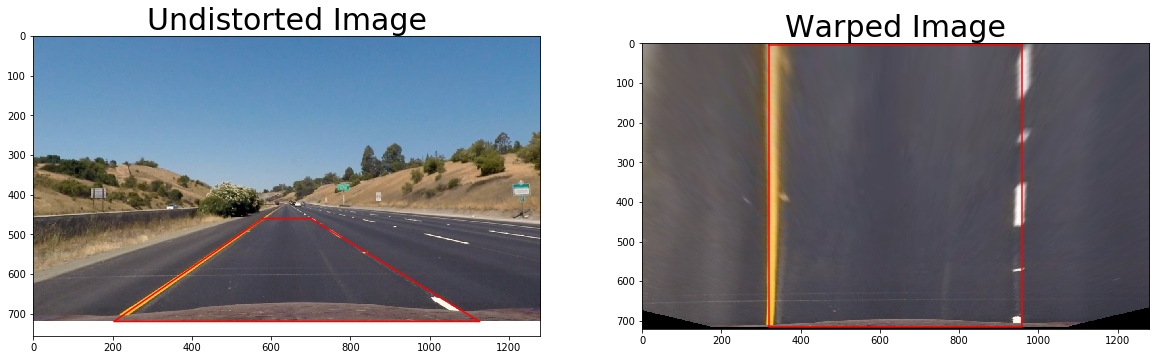

In [18]:
img = cv2.imread('test_images/straight_lines1.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

warped, M, src_points, dst_points = transform_perspective(undist)
cv2.imwrite('/output_images/road_warped.jpg',warped)
# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(undist);
ax1.plot([src_points[0,0],src_points[1,0],src_points[2,0],src_points[3,0],src_points[0,0]],
         [src_points[0,1],src_points[1,1],src_points[2,1],src_points[3,1],src_points[0,1]], color='red');
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(warped);
ax2.set_title('Warped Image', fontsize=30);
ax2.plot([dst_points[0,0],dst_points[1,0],dst_points[2,0],dst_points[3,0],dst_points[0,0]],
         [dst_points[0,1],dst_points[1,1],dst_points[2,1],dst_points[3,1],dst_points[0,1]], color='red');

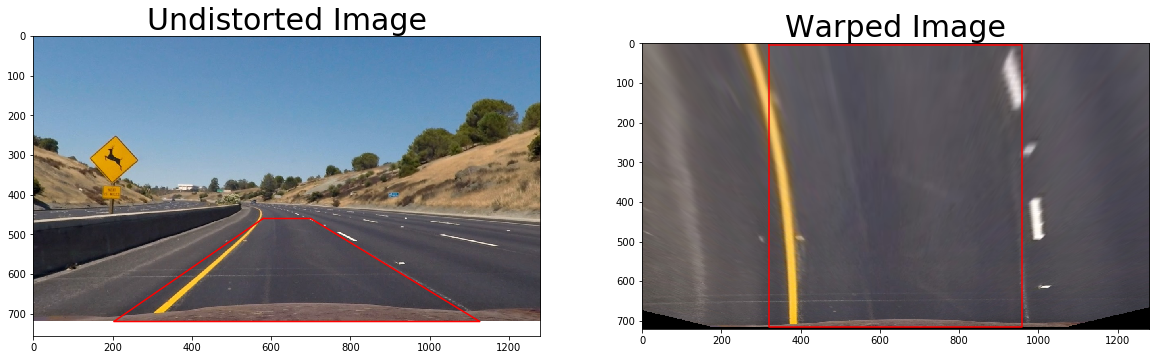

In [19]:
"""
Try the same perspective transform on a curved road
"""
img = cv2.imread('test_images/test2.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

warped, M, src_points, dst_points = transform_perspective(undist)
cv2.imwrite('output_images/road_curved_warped.jpg',warped)
# Visualize perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(undist);
ax1.plot([src_points[0,0],src_points[1,0],src_points[2,0],src_points[3,0],src_points[0,0]],
         [src_points[0,1],src_points[1,1],src_points[2,1],src_points[3,1],src_points[0,1]], color='red');
ax1.set_title('Undistorted Image', fontsize=30);
ax2.imshow(warped);
ax2.set_title('Warped Image', fontsize=30);
ax2.plot([dst_points[0,0],dst_points[1,0],dst_points[2,0],dst_points[3,0],dst_points[0,0]],
         [dst_points[0,1],dst_points[1,1],dst_points[2,1],dst_points[3,1],dst_points[0,1]], color='red');

## Undistort, Threshold, and Perspective Transform

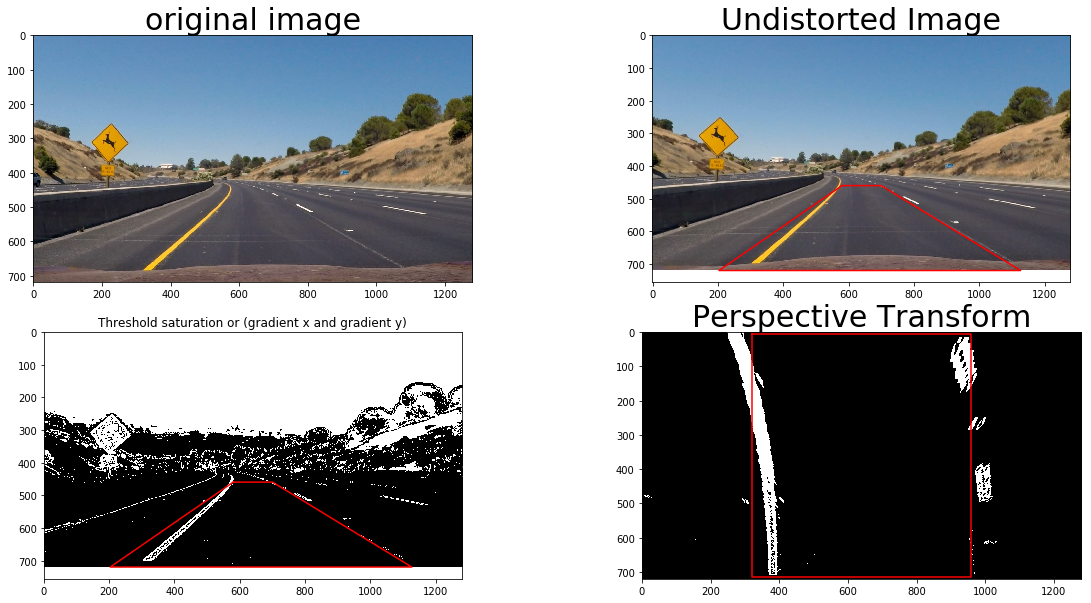

In [20]:
img = cv2.imread('test_images/test2.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True,image_dir='camera_cal/*.jpg')

gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

warped, M, src_points, dst_points = transform_perspective(combo_binary)
cv2.imwrite('/output_images/road_curved_binarized.jpg',combo_binary)
cv2.imwrite('/output_images/road_curved_binarized_warped.jpg',warped)

# Visualize perspective transform
f, ((ax1, ax2), (ax3,ax4))= plt.subplots(2, 2, figsize=(20,10));

ax1.imshow(img);
ax1.set_title("original image", fontsize=30);

ax2.imshow(undist);
ax2.plot([src_points[0,0],src_points[1,0],src_points[2,0],src_points[3,0],src_points[0,0]],
         [src_points[0,1],src_points[1,1],src_points[2,1],src_points[3,1],src_points[0,1]], color='red');
ax2.set_title('Undistorted Image', fontsize=30);

ax3.imshow(combo_binary, cmap='gray');
ax3.plot([src_points[0,0],src_points[1,0],src_points[2,0],src_points[3,0],src_points[0,0]],
         [src_points[0,1],src_points[1,1],src_points[2,1],src_points[3,1],src_points[0,1]], color='red');

ax3.set_title("Threshold saturation or (gradient x and gradient y)");

ax4.imshow(warped, cmap='gray');
ax4.set_title('Perspective Transform', fontsize=30);
ax4.plot([dst_points[0,0],dst_points[1,0],dst_points[2,0],dst_points[3,0],dst_points[0,0]],
         [dst_points[0,1],dst_points[1,1],dst_points[2,1],dst_points[3,1],dst_points[0,1]], color='red');

## Find Lane Lines

In [44]:
### class Line stores info about current and previously found lane lines
class Line():
    def __init__(self, n=5):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients list over last n interations
        self.recent_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = [] 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #number of previous fitted lines to save
        self.n = n        
        
    """
    generate getters and setters
    """
    def set_detected(self, d):
        assert type(False) is bool, "detected {} should be type bool".format(d)
        self.detected = d

    def get_detected(self):
        return self.detected
    
    def update_xfitted(self, x_fitted):
        """
        x_fitted refers to a list of x coordinates for all the y coordinates
        that form the fitted line for a lane.
        We save a list of the n most recent x_fitted in self.recent_xfitted.
        We also save an average of the n previous x_fitted as self.best_x.
        
        In self.recent_x_fitted, the most recent is appended to the end
        and the oldest is at the front
        x: x values of most recent fit.  
        """
        if len(self.recent_xfitted) >= self.n:
            del self.recent_xfitted[0]
        self.recent_xfitted.append(x_fitted)
        
        """
        re-calculate average of x_fitted.
        Converting to numpy array, the list of list becomes
        a matrix where the rows are each xfitted list,
        and each column refers to the x's for the same y position.
        take the mean along axis 0 will go along all the rows
        for each column and average them, so we have
        a 1D array with length equal to the number of columns
        """
        recent_xfitted_arr = np.array(self.recent_xfitted)
        self.bestx = np.mean(recent_xfitted_arr, axis=0)
        return
    
    def get_recent_xfitted(self):
        return self.recent_xfitted
    
    def get_bestx(self):
        return self.bestx

    def update_ploty(self, y):
        self.ploty = y
        
    def get_ploty(self):
        return self.ploty
    
    def update_fit(self, fit):
        """
        Include the most recent fit coefficients in the list of most recent
        fits (from previous image frames). If there are already n saved fits,
        then discard the oldest one before appending the newest (treat the list as a queue).
        Update the most recent fit variable.
        Also calculate the best fit as the average of the n most recent fits.
        x: current polynomial coefficients
        
        """
        self.diffs = fit - self.current_fit
        self.current_fit = fit
        if len(self.recent_fit) >= self.n:
            del self.recent_fit[0]
        self.recent_fit.append(fit)
        
        recent_fit_arr = np.array(self.recent_fit)
        self.best_fit = np.mean(recent_fit_arr, axis=0)
        return
    
    def get_best_fit(self):
        return self.best_fit
    
    def get_recent_fit(self):
        return self.recent_fit
    
    def update_radius(self, r):
        """
        """
        self.radius_of_curvature.append(r)
        if len(self.radius_of_curvature) > self.n:
            del self.radius_of_curvature[0]
        return
    
    def get_radius(self):
        return self.radius_of_curvature
    
    def get_best_radius(self):
        return np.mean(np.array(self.radius_of_curvature)) 
        
    def update_allx(self, x):
        """
        x: all the x coordinates of all identified line pixels
        """
        self.allx = x
    
    def get_allx(self):
        return self.allx
    
    def update_ally(self, y):
        """
        y: all the y coordinates of all identified line pixels
        """
        self.ally = y
    
    def get_ally(self):
        return self.ally
        
    def update_n(self,n):
        """
        n: number of previous fits to save.
        This applies to the lists recent_xfitted and recent_fit
        """
        self.n = n
    
    def get_n(self):
        return self.n
    
    

In [45]:
class Lane():
    def __init__(self, n=5):
        self.left_line = Line(n)
        self.right_line = Line(n)
        self.n = n
        self.detected=False
        self.offset = []
        self.radius = []
        self.image_height = None
        self.image_width = None
                
    def get_left_line(self):
        return self.left_line
    def get_right_line(self):
        return self.right_line
    
    def update_detected(self, d):
        self.detected=d
        self.get_left_line().set_detected(d)
        self.get_right_line().set_detected(d)

    def get_detected(self):
        return self.detected
    
    def update_offset(self,o):
        """
        car's distance from center of the lane in meters
        """
        self.offset.append(o)
        if len(self.offset) > self.n:
            del self.offset[0]
        return
    
    def get_offset(self):
        return self.offset
    
    def get_best_offset(self):
        recent_arr = np.array(self.offset)
        return np.mean(recent_arr, axis=0)
    
    def update_radius(self, left_r, right_r):
        self.get_left_line().update_radius(left_r)
        self.get_right_line().update_radius(right_r)
        lane_radius = np.mean([left_r,right_r])
        self.radius.append(lane_radius)
        if len(self.radius) > self.n:
            del self.radius[0]
            
    def get_radius(self):
        return self.radius
    
    def get_best_radius(self):
        radius_arr = np.array(self.radius)
        return np.mean(radius_arr)
        

In [46]:
def lane_line_window_search(lane_prev,
                            img, 
                            nwindows=9,
                            margin=50,
                            minpix = 20):
    """
    Detect lane lines using sliding windows. Save the fitted coordinates and fitted line coefficients
    into a Lane object.
    img: should be a binary (thresholded) image that is warped to show an aerial view
    nwindows: numer of sliding windows, stacked horizontally, to use when searching for lane lines
    margin: the width of the windows +/- margin
    minpix: minimum number of pixels found to recenter window
    undist: this is the color image (3 channels) after undistortiodefn, before warping perpsective or thresholding
            use this when visualizing the found lines on the original unwarped view
    """
    lane_curr = copy.deepcopy(lane_prev)
    mid_height = np.int(img.shape[0] / 2)
    bottom_half = img[mid_height:,:]
    """
    Use a histogram to check which column has the most line pixels.
    Choose axis 0. the image's 0th dimension is height,
    so the outer nesting is for an entire row with multiple columns.
    Summing along axis 0 means sum all rows for each column
    """
    histogram = np.sum(bottom_half, axis=0) #histogram is 1D and same as width of image
    
    """
    Find the peak of the left and right halves of the histogram
    These will be the starting point for the left and right lines
    """
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height the sliding windows
    window_height = np.int(img.shape[0]/nwindows)
    
    """
    Identify the x and y positions of all nonzero pixels in the image
    nonzeroy has 1 element for each pixel in the image where the pixel
    is nonzero.  So, for instance, out of (270 * 1280) = 345,600 total pixels,
    28,357 (len(nonzeroy)) of those have non-zero values.  nonzeroy has the y coordinate of each of those nonzero pixels.
    Similarly, nonzerox has the x coordinates of each of those nonzero pixels.
    The nonzeroy and nonzerox are ordered so that nonzeroy[10] and nonzeroy[10] represent the y and x coordinates
    of a pixel that has a nonzero value.
    """
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0]) 
    nonzerox = np.array(nonzero[1])
    
    """
    Loop through all windows
    """
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    #store window corners in a dictionary of lists
    windows = defaultdict(list)
    
    #before loop, copy some shape values to local vars for easier reading
    img_height = img.shape[0]
    img_width = img.shape[1]
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_high = img_height - window*window_height #this is the bottom of the window
        win_y_low = win_y_high - window_height #this is the top of the window
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        windows['y_high'].append(win_y_high)
        windows['y_low'].append(win_y_low)
        windows['xleft_low'].append(win_xleft_low)
        windows['xleft_high'].append(win_xleft_high)
        windows['xright_low'].append(win_xright_low)
        windows['xright_high'].append(win_xright_high)

        
        """
        Identify the nonzero pixels in x and y within the window.
        Recall that nonzeroy's values represent the y coordinates of pixels 
        that have nonzero values in the image.
        We're using the inequalities to find pixels for which the 
        y coordinates and x coordinates are within the window.
        
        The inequalities give us 1 for true and 0 for false.  
        We apply nonzero to find the indices for nonzeroy and nonzerox for which 
        the x,y coordinates are both nonzero pixels and are within the window boundaries.
        These indices are saved for the left lane and right lane.
        """
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    #end for loop
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    """
    Extract left and right line pixel positions
    These give us the x, y coordinates of the pixels
    that are nonzero in the image, and are also within the 
    search windows.
    """
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    lane_curr.get_left_line().update_allx(leftx)
    lane_curr.get_left_line().update_ally(lefty)
    lane_curr.get_right_line().update_allx(rightx)
    lane_curr.get_right_line().update_ally(righty)
    
    """
    Fit a second order polynomial to each
    Notice that the y axis is our independent variable,
    since the lane lines are close to vertical, and so there 
    are more than one y value for the same x value.
    We're fitting a second order polynomial, so the coefficients
    will be used like this:
    x = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
    """
    if len(lefty) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    elif lane_prev.get_left_line().get_best_fit() != None:
        left_fit = lane_prev.get_left_line().get_best_fit()
    else:
        left_fit = np.array([0,0,(1./3.)* img_width ])
    
    if len(righty) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    elif lane_prev.get_right_line().get_best_fit() != None:
        right_fit = lane_prev.get_right_line().get_best_fit()
    else:
        right_fit = np.array([0,0, (1./3.) * img_width])
    
    lane_curr.get_left_line().update_fit(left_fit)
    lane_curr.get_right_line().update_fit(right_fit)
    
    """
    numpy.linspace(start, stop, num=50...)
    """
    ploty = np.linspace(0, img_height - 1, img_height )
    lane_curr.get_left_line().update_ploty(ploty)
    lane_curr.get_right_line().update_ploty(ploty)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane_curr.get_left_line().update_xfitted(left_fitx)
    lane_curr.get_right_line().update_xfitted(right_fitx)

    #calculate radius of curvature and offset from center of lane
    lane_curr = curvature(img_height,lane_curr,ym_per_pix=30/720,xm_per_pix = 3.7/700)
    lane_curr = offset(img_height, img_width, lane_curr)
    
    """
    Since window search is more comprehensive, we'll assume that the 
    lane lines are detected
    """
    lane_curr.update_detected(True)
    
    return lane_curr, windows

In [47]:
def draw_aerial(img=None, lane=None, windows=None):
    """
    Draw the search windows on the visualization image (in aerial view)
    two diagonal corners are given to define the rectangle:
    top left corner, bottom right corner (of the left lane's window)
    same for the right lane's window
    
    Also draw the fitted points that are detected as lane lines.
    Draw the fitted line as well
    
    img: is the 1 channel thresholded, aerial view.
    """
    # Create an output image to draw on and  visualize the result
    img_zero = np.zeros_like(img).astype(np.uint8)
    #out_img = np.dstack((img_zero, img_zero, img_zero))
    out_img = np.dstack((img, img, img))

    #draw the found line points
    red_color = (255, 0, 0)
    blue_color = (0, 0, 255)
    
    out_img[lane.get_left_line().get_ally(), lane.get_left_line().get_allx()] = red_color
    out_img[lane.get_right_line().get_ally(), lane.get_right_line().get_allx()] = blue_color
    
    #draw the fitted lines
    yellow_color = (255, 255, 0)
    left_xfitted_int = [int(x) for x in lane_curr.get_left_line().get_recent_xfitted()[-1]]
    right_xfitted_int = [int(x) for x in lane_curr.get_right_line().get_recent_xfitted()[-1]]
    ploty_int = [int(y) for y in lane_curr.get_left_line().get_ploty()]
    out_img[ploty_int, left_xfitted_int] = yellow_color
    out_img[ploty_int, right_xfitted_int] = yellow_color
    
    green_color = (0,255,0)
    thickness = 2
    if windows:
        for ii in range(len(windows['y_low'])):
            cv2.rectangle(out_img,
                          (windows['xleft_low'][ii],windows['y_low'][ii]),
                          (windows['xleft_high'][ii],windows['y_high'][ii]),
                          green_color, thickness) 
            cv2.rectangle(out_img,
                          (windows['xright_low'][ii],windows['y_low'][ii]),
                          (windows['xright_high'][ii],windows['y_high'][ii]),
                          green_color, thickness) 
    return out_img


In [48]:
def draw_normal(img, lane, M, visualize=False):
    """
    Here, image is the undistorted image 3 channel (not warped, not thresholded)
    """
    Minv = np.linalg.inv(M)
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8) #it's already 3 channels

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = recast_points(lane.get_left_line().get_bestx()+20, lane.get_left_line().get_ploty(), 'left')
    pts_right = recast_points(lane.get_right_line().get_bestx()-20, lane.get_right_line().get_ploty(), 'right')
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane using aerial perspective (warped)
    lane_color = (0, 100, 0)
    cv2.fillPoly(color_warp, np.int_([pts]), lane_color)
    
    #draw the found line points
    left_color = (255, 100, 0) #orange
    right_color = (0, 0, 255) #blue
    color_warp[lane.get_left_line().get_ally(), lane.get_left_line().get_allx()] = left_color
    color_warp[lane.get_right_line().get_ally(), lane.get_right_line().get_allx()] = right_color

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    height, width = img.shape[0:2]
    newwarp = cv2.warpPerspective(color_warp, Minv, (width, height))
    # Combine the result with the original image
    out_img = cv2.addWeighted(img, 0.7, newwarp, 0.5, 0)
    
    #draw radius of curvature
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 3
    color = (255, 255, 255)
    radius_text = "Radius of curvature {:.1f} meters".format(lane.get_radius()[-1])
    radius_org = (50, 50) #bottom left corner of text block (x, y)
    cv2.putText(out_img, radius_text, radius_org, fontFace, fontScale, color, thickness) 

    #draw offset from center of lane
    offset_text = "Vehicle is {:.2f} meters right of center".format(lane.get_offset()[-1])
    offset_org = (50, 100) #bottom left corner of text block (x,y)
    cv2.putText(out_img, offset_text, offset_org, fontFace, fontScale, color, thickness) 

    """
    show coefficients to see how they vary
    """
    
    coeff_l = lane.get_left_line().get_recent_fit()[-1]    
    coeff_l_text = "coefficient left line: {:.2f}y^2 + {:.2f}y + {:.2f}".format(coeff_l[0], coeff_l[1], coeff_l[2])
    coeff_l_org = (50, 150)
    cv2.putText(out_img, coeff_l_text, coeff_l_org, fontFace, fontScale, color, thickness)
    
    coeff_r = lane.get_right_line().get_recent_fit()[-1]    
    coeff_r_text = "coeffient right line: {:.2f}y^2 + {:.2f}y + {:.2f}".format(coeff_r[0], coeff_r[1], coeff_r[2])
    coeff_r_org = (50, 200)
    cv2.putText(out_img, coeff_r_text, coeff_r_org, fontFace, fontScale, color, thickness)    
    
    
    if visualize:
        plt.imshow(out_img)
        
    return out_img

In [49]:
def recast_points(x, y, side):
    """
    recast x and y points (in image space, where y increases down the image),
    to be used for cv2.fillPoly()
    """
    if side == 'left':
        return np.array([np.transpose(np.vstack([x, y]))])
    elif side == 'right':  
        return np.array([np.flipud(np.transpose(np.vstack([x, y])))])

In [50]:
def lane_line_given_previous(lane_prev=None, img=None, margin=50):
    """
    Given an aerial view image and the fitted lane results of the previous couple images,
    find the lane lines and store the fit results into a Lane object
    
    lane_prev: Lane object that holds fit results of previous n images
    img: aerial (warped) image that is thresholded binary and has 1 channel
    """
    lane_curr = copy.deepcopy(lane_prev)
    img_height, img_width = img.shape[0:2]
    #get the x,y coordinates of all the thresholded pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    """
    Use the previously best fit line and create left and right boundary lines 
    around both left and right lane lines.
    We're using the y coordinates of the thresholded pixels of the current image
    to determine the base of the boundary
    """
    
    left_fit_left_bound  = fit_line(lane_prev.get_left_line().get_best_fit(), nonzeroy) - margin
    left_fit_right_bound = fit_line(lane_prev.get_left_line().get_best_fit(), nonzeroy) + margin
    left_lane_inds = ((nonzerox > left_fit_left_bound) & (nonzerox < left_fit_right_bound)) 
    
    right_fit_left_bound = fit_line(lane_curr.get_right_line().get_best_fit(), nonzeroy) - margin
    right_fit_right_bound = fit_line(lane_curr.get_right_line().get_best_fit(), nonzeroy) + margin
    right_lane_inds = ((nonzerox > right_fit_left_bound) & (nonzerox < right_fit_right_bound))

    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) > 0:
        lane_curr.get_left_line().update_allx(leftx)
    if len(lefty) > 0:
        lane_curr.get_left_line().update_ally(lefty)
    if len(rightx) > 0:
        lane_curr.get_right_line().update_allx(rightx)
    if len(righty) > 0:
        lane_curr.get_right_line().update_ally(righty)
    
    # Fit a second order polynomial to each
    if len(lefty) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    elif lane_prev.get_left_line().get_best_fit() != None:
        left_fit = lane_prev.get_left_line().get_best_fit()
    else:
        left_fit = np.array([0,0,(1./3.)* img_width ])
    
    if len(righty) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    elif lane_prev.get_right_line().get_best_fit() != None:
        right_fit = lane_prev.get_right_line().get_best_fit()
    else:
        right_fit = np.array([0,0, (1./3.) * img_width])  
    
    lane_curr.get_left_line().update_fit(left_fit)
    lane_curr.get_right_line().update_fit(right_fit)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = fit_line(left_fit, ploty) 
    right_fitx = fit_line(right_fit, ploty) 

    lane_curr.get_left_line().update_ploty(ploty)
    lane_curr.get_right_line().update_ploty(ploty)
    lane_curr.get_left_line().update_xfitted(left_fitx)
    lane_curr.get_right_line().update_xfitted(right_fitx)
    
    #calculate radius of curvature and offset from center of lane
    lane_curr = curvature(img_height,lane_curr,ym_per_pix=30/720,xm_per_pix = 3.7/700)
    lane_curr = offset(img_height, img_width, lane_curr)

    return lane_curr

In [ ]:
def lane_line_detect(lane_prev=None, img=None, margin=50, diff_threshold=100):
    """
    Detect lane lines using either a moving window search,
    or if previous lane images were fit, use the previous best fit line as
    a starting point to find lane lines.
    
    Also, when using the previous fit, if the result is too different
    from the previous best fit, try the window search as well.
    Then compare both methods and save the one that is more similar
    to the previous fits.
    
    img: the warped aerial thresholded binary image (1 channel)
    lane_prev: the Lane object containing previous fits, if there are any
    
    The constant fit[2] varies the most.
    """
    window_margin = margin
    #use lane_line and moving windows to detect lane points, fit a line
    if lane_prev.detected == False:
        """
        If we don't have previous fit data, use the window search
        """
        lane_window, windows = lane_line_window_search(lane_prev, img,nwindows=9,margin=window_margin,minpix=20)
        print("No previous lane, using window, diff")
        return lane_window
    
    """
    If previous lanes were detected, use previous fits to help find lane quickly
    find the current lane
    Compare with previous fit.  If difference is small enough, use the results
    """
    lane_quick = lane_line_given_previous(lane_prev, img, margin=margin)
    diff_quick = compare_fits(lane_prev, lane_quick)
    if diff_quick <= diff_threshold:
        lane_quick.update_detected(True)
        print("quick diff with prev {:.1f} <= thresh {:.1f}".format(diff_quick,diff_threshold))
        return lane_quick
    
    """
    If quick fit diff is above threshold,
    try window search.
    """
    lane_window, windows = lane_line_window_search(lane_prev,img,nwindows=9,margin=window_margin,minpix=20)    
    diff_window = compare_fits(lane_prev, lane_window)
    print("window {:.1f}, quick {:.1f}, thresh {:.1f}".format(diff_window,diff_quick,diff_threshold))
    if diff_window <= diff_threshold:
        print("use window")
        return lane_window
    
    print("use prev")
    return lane_prev

In [51]:
def fit_line(fit=None, y=None):
    """
    helper function for lane_line_given_previous().
    Given the Line object and y coordinates, find the x coordinates
    """
    x = fit[0] * (y**2) + fit[1] * y + fit[2]
    return x

In [52]:
def compare_fits(lane_prev=None, lane_curr=None):
    """
    To check if the current lane fit is reasonable,
    we compare it to the previous lane's best fit.
    
    Just compare the constant coeficients;
    This seems to be most representative of when there is
    an unexpected jump in the detected line
    """
    
    prev_l = lane_prev.get_left_line().get_best_fit()
    curr_l = lane_curr.get_left_line().get_recent_fit()[-1]
    diff_l = (curr_l - prev_l)[-1]
    
    prev_r = lane_prev.get_right_line().get_best_fit()
    curr_r = lane_curr.get_right_line().get_recent_fit()[-1]
    diff_r = (curr_l - prev_l)[-1]
    
    metric = np.max(np.abs([diff_l, diff_r]))
    return metric

## Curvature

In [53]:
def curvature(img_height=None, lane_prev=None, xm_per_pix = 3.7/1280, ym_per_pix = 30/720):
    """
    # Define conversions in x and y from pixels space to meters
    img_height: use the bottom of image as starting point for masuring curve radians
    lane: fit information
    ym_per_pix: meters per pixel in y dimension
    xm_per_pix: meters per pixel in x dimension
    
    returns radius of curvature in meters for both left and right lines
    """
    lane_curr = copy.deepcopy(lane_prev)
    y_eval = img_height
    # Fit new polynomials to x,y in world space
    left_curverad = radius_of_curvature(lane_prev.get_left_line().get_allx(), 
                                        lane_prev.get_left_line().get_ally(),
                                        xm_per_pix, ym_per_pix, y_eval)
    
    right_curverad = radius_of_curvature(lane_prev.get_right_line().get_allx(), 
                                         lane_prev.get_right_line().get_ally(),
                                         xm_per_pix, ym_per_pix, y_eval)
    
    lane_curr.update_radius(left_curverad, right_curverad)

    return lane_curr

In [54]:
def radius_of_curvature(x=None, y=None, xm_per_pix = 3.7/1280, ym_per_pix = 30/720, y_eval=None):
    """
    helper function for curvature()
    x: x coordinates of all points
    y: y coordinates of all points
    xm_per_pix: conversion to meters
    ym_per_pix: conversion to meters
    """
    fit = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    return ((1 + (2*fit[0]*y_eval*ym_per_pix + fit[1])**2)**1.5) / np.absolute(2*fit[0])

## Offset from center

In [55]:
def offset(img_height, img_width, lane_prev=None, xm_per_pix = 3.7/1280):
    """
    Determine ar distance from center of lane (in pixels)
    img: image, undistorted, normal
    
    """
    lane_curr = copy.deepcopy(lane_prev)
    y_base = img_height
    leftx_base = fit_line(lane_prev.get_left_line().get_recent_fit()[-1],y_base)
    rightx_base = fit_line(lane_prev.get_right_line().get_recent_fit()[-1],y_base)
    lane_center = np.mean([leftx_base, rightx_base])
    car_position_x = img.shape[1] / 2.
    offset = (car_position_x - lane_center)
    offset_meters = offset * xm_per_pix
    lane_curr.update_offset(offset_meters)

    #print("lane left x {}, lane right x {}, lane center {}".format(leftx_base,rightx_base, lane_center))
    #print("car position {}, offset {}, offset (m) {}".format(car_position_x, offset, offset_meters))
    return lane_curr

In [56]:
def lane_line_detect(lane_prev=None, img=None, margin=50, diff_threshold=100):
    """
    Detect lane lines using either a moving window search,
    or if previous lane images were fit, use the previous best fit line as
    a starting point to find lane lines.
    
    Also, when using the previous fit, if the result is too different
    from the previous best fit, try the window search as well.
    Then compare both methods and save the one that is more similar
    to the previous fits.
    
    img: the warped aerial thresholded binary image (1 channel)
    lane_prev: the Lane object containing previous fits, if there are any
    
    The constant fit[2] varies the most.
    """
    window_margin = margin
    #use lane_line and moving windows to detect lane points, fit a line
    if lane_prev.detected == False:
        """
        If we don't have previous fit data, use the window search
        """
        lane_window, windows = lane_line_window_search(lane_prev, img,nwindows=9,margin=window_margin,minpix=20)
        print("No previous lane, using window, diff")
        return lane_window
    
    """
    If previous lanes were detected, use previous fits to help find lane quickly
    find the current lane
    Compare with previous fit.  If difference is small enough, use the results
    """
    lane_quick = lane_line_given_previous(lane_prev, img, margin=margin)
    diff_quick = compare_fits(lane_prev, lane_quick)
    if diff_quick <= diff_threshold:
        lane_quick.update_detected(True)
        print("quick diff with prev {:.1f} <= thresh {:.1f}".format(diff_quick,diff_threshold))
        return lane_quick
    
    """
    If quick fit diff is above threshold,
    try window search.
    """
    lane_window, windows = lane_line_window_search(lane_prev,img,nwindows=9,margin=window_margin,minpix=20)    
    diff_window = compare_fits(lane_prev, lane_window)
    print("window {:.1f}, quick {:.1f}, thresh {:.1f}".format(diff_window,diff_quick,diff_threshold))
    if diff_window <= diff_threshold:
        print("use window")
        return lane_window
    
    print("use prev")
    return lane_prev

## Test functions

In [ ]:
""" 
test the function lane_line_window_search

"""

lane_1 = Lane(5)

img = cv2.imread('test_images/test1.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped, M, src_points, dst_points = transform_perspective(combo_binary)


lane_1, windows = lane_line_window_search(lane_1,
                                    img=warped,
                                    nwindows=9,
                                    margin=100,
                                    minpix = 20
                                   )

img = cv2.imread('test_images/test2.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped, M, src_points, dst_points = transform_perspective(combo_binary)


lane_2, windows = lane_line_window_search(lane_1,
                                    img=warped,
                                    nwindows=9,
                                    margin=100,
                                    minpix = 20
                                   )

img = cv2.imread('test_images/test3.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped, M, src_points, dst_points = transform_perspective(combo_binary)


lane_3, windows = lane_line_window_search(lane_2,
                                    img=warped,
                                    nwindows=9,
                                    margin=100,
                                    minpix = 20
                                   )

img = cv2.imread('test_images/test4.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped, M, src_points, dst_points = transform_perspective(combo_binary)


lane_4, windows = lane_line_window_search(lane_3,
                                    img=warped,
                                    nwindows=9,
                                    margin=100,
                                    minpix = 20
                                   )

In [ ]:
"""
Test draw_aerial
"""
lane_prev = Lane()

img = cv2.imread('test_images/test5.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped, M, src_points, dst_points = transform_perspective(combo_binary)


lane_curr, windows = lane_line_window_search(lane_prev,
                                    img=warped,
                                    nwindows=9,
                                    margin=100,
                                    minpix = 20
                                   )

warped_windows = draw_aerial(warped, lane_curr, windows)
plt.imshow(warped_windows);
cv2.imwrite('output_images/draw_aerial.jpg',cv2.cvtColor(warped_windows, cv2.COLOR_RGB2BGR))

In [ ]:
"""
test draw_normal

"""
lane_prev = Lane()

img = cv2.imread('test_images/test5.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped, M, src_points, dst_points = transform_perspective(combo_binary)


lane_curr, windows = lane_line_window_search(lane_prev,
                                    img=warped,
                                    nwindows=9,
                                    margin=100,
                                    minpix = 20
                                   )

img_normal = draw_normal(undist, lane_curr, M)
plt.imshow(img_normal);
cv2.imwrite('output_images/draw_normal.jpg', cv2.cvtColor(img_normal, cv2.COLOR_RGB2BGR));


In [ ]:
"""
test lane_line_given_previous
"""

lane_prev = Lane()

img = cv2.imread('test_images/test2.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped, M, src_points, dst_points = transform_perspective(combo_binary)

#find first lane with search windows
lane_prev, windows = lane_line_window_search(lane_prev,
                                    img=warped,
                                    nwindows=9,
                                    margin=100,
                                    minpix = 20
                                   )

#use another image to test 
img = cv2.imread('test_images/test3.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped, M, src_points, dst_points = transform_perspective(combo_binary)


#find next lane with previous fit
lane_curr = lane_line_given_previous(lane_prev, warped, margin=100)

#check results using aerial image plot
warped_windows = draw_aerial(warped, lane_curr)
plt.imshow(warped_windows);

#check results with normal view
img_normal = draw_normal(undist, lane_curr, M)
plt.imshow(img_normal);

In [ ]:
"""
Test lane_line_detect 
case 1: no previous fits to use
"""

lane_prev = Lane(5)

img = cv2.imread('test_images/test2.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped, M, src_points, dst_points = transform_perspective(combo_binary)

#find first lane with search windows
lane_curr = lane_line_detect(lane_prev, warped, diff_threshold=10)
aerial = draw_aerial(warped, lane_curr)
plt.imshow(aerial);


In [ ]:
"""
test lane_line_detect
case 2 part 1: previous lane fit exists
"""
del lane_prev
del img
lane_prev = Lane(5)

img = cv2.imread('test_images/test2.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped1, M, src_points, dst_points = transform_perspective(combo_binary)

#find first lane with search windows
#lane_prev = lane_line_detect(lane_prev, warped1, diff_threshold=10)
lane_prev, windows = lane_line_window_search(lane_prev,img=warped1,nwindows=9,margin=100,minpix = 20)

aerial1 = draw_aerial(warped1, lane_prev, windows)
plt.imshow(aerial1);


In [ ]:
"""
test lane_line_detect
case 2 part 2: previous lane fit exists
"""
#use another image to test 
img = cv2.imread('test_images/test4.jpg') #reads as BGR
img = img[:,:,::-1] #convert to RGB
#undistort
undist = undistort_image(x_count=9,y_count=6,img=img,use_cache=True)

#threshold to create binary image
gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(30, 120), threshy=(30,120))
s_binary = saturation_thresh(undist, thresh=(90,255))
combo_binary = np.zeros_like(s_binary)
combo_binary[ (s_binary == 1) | (gradx == 1)  ] = 1

#warp for aerial view
warped2, M, src_points, dst_points = transform_perspective(combo_binary)

#find next lane with previous fit
lane_curr = lane_line_detect(lane_prev, warped2, diff_threshold=10)

aerial2= draw_aerial(warped2, lane_curr)
plt.imshow(aerial2);

## Apply to Video

In [57]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [58]:
class VideoProcessor(object):

    def __init__(self, n):
        self.lane = Lane(n)

    def pipeline_function(self, img):
        """
        img: input image directly from camera
        return: image with lane line filled in with green
        """

        #undistort image
        undist = undistort_image(x_count=9,
                                 y_count=6,
                                 img=img)

        #threshold to create binary image        
        s_binary = saturation_thresh(undist, thresh=(200,255))
        gradx, grady = abs_sobel_thresh(undist, sobel_kernel=5, threshx=(10, 255), threshy=(30,150))
        
        combo_binary = np.zeros_like(s_binary)
        combo_binary[ (s_binary == 1) |( (gradx ==1) & (grady ==1) ) ] = 1
        #warp perspective to an aerial view
        warped, M, src_points, dst_points = transform_perspective(combo_binary)
        #find lane lines, draw found lanes, unwarp perspective back to normal view
        self.lane = lane_line_detect(self.lane, warped, margin=30, diff_threshold=100)
        #draw lane onto normal image
        img_lanes = draw_normal(undist, self.lane, M)
        return img_lanes

In [59]:
video_processor_object = VideoProcessor(5)
project_output = 'output_video/project_video_out.mp4'
clip = VideoFileClip("project_video.mp4")
project_clip = clip.fl_image(video_processor_object.pipeline_function)
%time project_clip.write_videofile(project_output, audio=False)

No previous lane, using window, diff
[MoviePy] >>>> Building video output_video/project_video_out.mp4
[MoviePy] Writing video output_video/project_video_out.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

quick diff with prev 11.4 <= thresh 100.0


  0%|          | 2/1261 [00:00<04:36,  4.55it/s]

quick diff with prev 7.0 <= thresh 100.0


  0%|          | 3/1261 [00:00<04:54,  4.28it/s]

quick diff with prev 2.8 <= thresh 100.0


  0%|          | 4/1261 [00:00<04:58,  4.21it/s]

quick diff with prev 5.2 <= thresh 100.0


  0%|          | 5/1261 [00:01<05:07,  4.08it/s]

quick diff with prev 6.8 <= thresh 100.0


  0%|          | 6/1261 [00:01<05:05,  4.11it/s]

quick diff with prev 4.5 <= thresh 100.0


  1%|          | 7/1261 [00:01<04:55,  4.24it/s]

quick diff with prev 5.4 <= thresh 100.0


  1%|          | 8/1261 [00:01<04:53,  4.27it/s]

quick diff with prev 3.9 <= thresh 100.0


  1%|          | 9/1261 [00:02<04:51,  4.30it/s]

quick diff with prev 5.2 <= thresh 100.0


  1%|          | 10/1261 [00:02<04:49,  4.32it/s]

quick diff with prev 5.9 <= thresh 100.0


  1%|          | 11/1261 [00:02<04:56,  4.21it/s]

quick diff with prev 5.2 <= thresh 100.0


  1%|          | 12/1261 [00:02<04:50,  4.30it/s]

quick diff with prev 8.1 <= thresh 100.0


  1%|          | 13/1261 [00:03<04:48,  4.32it/s]

quick diff with prev 7.7 <= thresh 100.0


  1%|          | 14/1261 [00:03<05:26,  3.82it/s]

quick diff with prev 5.5 <= thresh 100.0
quick diff with prev 1.6 <= thresh 100.0


  1%|▏         | 16/1261 [00:03<04:44,  4.37it/s]

quick diff with prev 3.2 <= thresh 100.0


  1%|▏         | 18/1261 [00:04<04:31,  4.58it/s]

quick diff with prev 1.2 <= thresh 100.0
quick diff with prev 2.5 <= thresh 100.0


  2%|▏         | 19/1261 [00:04<04:58,  4.16it/s]

quick diff with prev 2.1 <= thresh 100.0


  2%|▏         | 20/1261 [00:04<04:54,  4.22it/s]

quick diff with prev 3.8 <= thresh 100.0


  2%|▏         | 21/1261 [00:04<04:52,  4.25it/s]

quick diff with prev 3.4 <= thresh 100.0


  2%|▏         | 22/1261 [00:05<04:49,  4.27it/s]

quick diff with prev 5.3 <= thresh 100.0
quick diff with prev 6.7 <= thresh 100.0


  2%|▏         | 24/1261 [00:05<04:28,  4.61it/s]

quick diff with prev 1.7 <= thresh 100.0


  2%|▏         | 25/1261 [00:05<04:31,  4.56it/s]

quick diff with prev 0.8 <= thresh 100.0


  2%|▏         | 26/1261 [00:06<04:30,  4.57it/s]

quick diff with prev 1.7 <= thresh 100.0


  2%|▏         | 27/1261 [00:06<04:30,  4.57it/s]

quick diff with prev 1.4 <= thresh 100.0


  2%|▏         | 28/1261 [00:06<04:27,  4.61it/s]

quick diff with prev 3.9 <= thresh 100.0


  2%|▏         | 29/1261 [00:06<04:22,  4.70it/s]

quick diff with prev 0.3 <= thresh 100.0


  2%|▏         | 30/1261 [00:06<04:23,  4.67it/s]

quick diff with prev 3.6 <= thresh 100.0
quick diff with prev 2.8 <= thresh 100.0

  3%|▎         | 32/1261 [00:07<04:18,  4.75it/s]


quick diff with prev 2.8 <= thresh 100.0
quick diff with prev 1.9 <= thresh 100.0


  3%|▎         | 34/1261 [00:07<04:09,  4.93it/s]

quick diff with prev 0.7 <= thresh 100.0


  3%|▎         | 35/1261 [00:07<04:26,  4.60it/s]

quick diff with prev 1.0 <= thresh 100.0


  3%|▎         | 36/1261 [00:08<04:32,  4.50it/s]

quick diff with prev 1.2 <= thresh 100.0


  3%|▎         | 37/1261 [00:08<04:37,  4.41it/s]

quick diff with prev 4.0 <= thresh 100.0


  3%|▎         | 38/1261 [00:08<04:30,  4.52it/s]

quick diff with prev 5.7 <= thresh 100.0


  3%|▎         | 39/1261 [00:08<04:29,  4.54it/s]

quick diff with prev 2.4 <= thresh 100.0
quick diff with prev 5.9 <= thresh 100.0

  3%|▎         | 41/1261 [00:09<04:22,  4.66it/s]


quick diff with prev 6.3 <= thresh 100.0
quick diff with prev 7.4 <= thresh 100.0


  3%|▎         | 43/1261 [00:09<04:25,  4.59it/s]

quick diff with prev 6.5 <= thresh 100.0


  3%|▎         | 44/1261 [00:09<04:26,  4.57it/s]

quick diff with prev 5.0 <= thresh 100.0


  4%|▎         | 45/1261 [00:10<04:34,  4.44it/s]

quick diff with prev 5.7 <= thresh 100.0


  4%|▎         | 46/1261 [00:10<04:27,  4.54it/s]

quick diff with prev 4.8 <= thresh 100.0


  4%|▎         | 47/1261 [00:10<04:30,  4.49it/s]

quick diff with prev 3.0 <= thresh 100.0


  4%|▍         | 48/1261 [00:10<04:34,  4.41it/s]

quick diff with prev 3.3 <= thresh 100.0


  4%|▍         | 49/1261 [00:11<04:35,  4.39it/s]

quick diff with prev 4.3 <= thresh 100.0


  4%|▍         | 50/1261 [00:11<04:40,  4.32it/s]

quick diff with prev 3.4 <= thresh 100.0


  4%|▍         | 51/1261 [00:11<04:37,  4.37it/s]

quick diff with prev 1.9 <= thresh 100.0


  4%|▍         | 52/1261 [00:11<04:46,  4.22it/s]

quick diff with prev 2.8 <= thresh 100.0


  4%|▍         | 53/1261 [00:11<04:39,  4.31it/s]

quick diff with prev 5.6 <= thresh 100.0


  4%|▍         | 54/1261 [00:12<04:43,  4.26it/s]

quick diff with prev 4.2 <= thresh 100.0


  4%|▍         | 55/1261 [00:12<04:41,  4.29it/s]

quick diff with prev 3.5 <= thresh 100.0


  4%|▍         | 56/1261 [00:12<04:42,  4.27it/s]

quick diff with prev 2.9 <= thresh 100.0


  5%|▍         | 57/1261 [00:12<04:38,  4.33it/s]

quick diff with prev 3.7 <= thresh 100.0


  5%|▍         | 58/1261 [00:13<04:41,  4.28it/s]

quick diff with prev 2.3 <= thresh 100.0


  5%|▍         | 59/1261 [00:13<04:36,  4.35it/s]

quick diff with prev 5.8 <= thresh 100.0


  5%|▍         | 60/1261 [00:13<04:37,  4.33it/s]

quick diff with prev 8.5 <= thresh 100.0


  5%|▍         | 61/1261 [00:13<04:34,  4.37it/s]

quick diff with prev 7.4 <= thresh 100.0


  5%|▍         | 62/1261 [00:14<04:36,  4.34it/s]

quick diff with prev 6.9 <= thresh 100.0


  5%|▍         | 63/1261 [00:14<04:34,  4.37it/s]

quick diff with prev 5.0 <= thresh 100.0


  5%|▌         | 64/1261 [00:14<04:35,  4.35it/s]

quick diff with prev 4.9 <= thresh 100.0


  5%|▌         | 65/1261 [00:14<04:38,  4.30it/s]

quick diff with prev 0.4 <= thresh 100.0


  5%|▌         | 66/1261 [00:15<04:38,  4.30it/s]

quick diff with prev 2.0 <= thresh 100.0


  5%|▌         | 67/1261 [00:15<04:41,  4.24it/s]

quick diff with prev 0.7 <= thresh 100.0


  5%|▌         | 68/1261 [00:15<04:41,  4.24it/s]

quick diff with prev 2.1 <= thresh 100.0


  5%|▌         | 69/1261 [00:15<04:36,  4.32it/s]

quick diff with prev 2.1 <= thresh 100.0


  6%|▌         | 70/1261 [00:15<04:36,  4.30it/s]

quick diff with prev 0.3 <= thresh 100.0


  6%|▌         | 71/1261 [00:16<04:37,  4.29it/s]

quick diff with prev 1.4 <= thresh 100.0


  6%|▌         | 72/1261 [00:16<04:37,  4.29it/s]

quick diff with prev 0.1 <= thresh 100.0


  6%|▌         | 73/1261 [00:16<04:34,  4.33it/s]

quick diff with prev 1.5 <= thresh 100.0


  6%|▌         | 74/1261 [00:16<04:37,  4.28it/s]

quick diff with prev 0.5 <= thresh 100.0


  6%|▌         | 75/1261 [00:17<04:33,  4.33it/s]

quick diff with prev 1.4 <= thresh 100.0


  6%|▌         | 76/1261 [00:17<04:37,  4.28it/s]

quick diff with prev 1.7 <= thresh 100.0


  6%|▌         | 77/1261 [00:17<04:34,  4.31it/s]

quick diff with prev 1.6 <= thresh 100.0


  6%|▌         | 78/1261 [00:17<04:39,  4.23it/s]

quick diff with prev 0.5 <= thresh 100.0


  6%|▋         | 79/1261 [00:18<04:32,  4.33it/s]

quick diff with prev 1.8 <= thresh 100.0


  6%|▋         | 80/1261 [00:18<04:36,  4.27it/s]

quick diff with prev 1.4 <= thresh 100.0


  6%|▋         | 81/1261 [00:18<04:30,  4.36it/s]

quick diff with prev 0.8 <= thresh 100.0


  7%|▋         | 82/1261 [00:18<04:33,  4.31it/s]

quick diff with prev 0.8 <= thresh 100.0


  7%|▋         | 83/1261 [00:18<04:31,  4.34it/s]

quick diff with prev 1.1 <= thresh 100.0


  7%|▋         | 84/1261 [00:19<04:32,  4.32it/s]

quick diff with prev 4.1 <= thresh 100.0


  7%|▋         | 85/1261 [00:19<04:29,  4.36it/s]

quick diff with prev 2.4 <= thresh 100.0


  7%|▋         | 86/1261 [00:19<04:36,  4.26it/s]

quick diff with prev 1.2 <= thresh 100.0


  7%|▋         | 87/1261 [00:19<04:30,  4.33it/s]

quick diff with prev 6.9 <= thresh 100.0


  7%|▋         | 88/1261 [00:20<04:33,  4.28it/s]

quick diff with prev 7.5 <= thresh 100.0


  7%|▋         | 89/1261 [00:20<04:29,  4.34it/s]

quick diff with prev 8.7 <= thresh 100.0


  7%|▋         | 90/1261 [00:20<04:30,  4.32it/s]

quick diff with prev 9.9 <= thresh 100.0


  7%|▋         | 91/1261 [00:20<04:31,  4.31it/s]

quick diff with prev 6.3 <= thresh 100.0


  7%|▋         | 92/1261 [00:21<04:34,  4.25it/s]

quick diff with prev 4.3 <= thresh 100.0


  7%|▋         | 93/1261 [00:21<04:32,  4.28it/s]

quick diff with prev 5.2 <= thresh 100.0


  7%|▋         | 94/1261 [00:21<04:32,  4.29it/s]

quick diff with prev 3.5 <= thresh 100.0


  8%|▊         | 95/1261 [00:21<04:32,  4.27it/s]

quick diff with prev 0.3 <= thresh 100.0


  8%|▊         | 96/1261 [00:21<04:31,  4.29it/s]

quick diff with prev 1.1 <= thresh 100.0


  8%|▊         | 97/1261 [00:22<04:29,  4.31it/s]

quick diff with prev 1.0 <= thresh 100.0


  8%|▊         | 98/1261 [00:22<04:30,  4.30it/s]

quick diff with prev 3.0 <= thresh 100.0


  8%|▊         | 99/1261 [00:22<04:25,  4.38it/s]

quick diff with prev 0.3 <= thresh 100.0


  8%|▊         | 100/1261 [00:22<04:28,  4.32it/s]

quick diff with prev 0.1 <= thresh 100.0


  8%|▊         | 101/1261 [00:23<04:25,  4.37it/s]

quick diff with prev 0.6 <= thresh 100.0


  8%|▊         | 102/1261 [00:23<04:28,  4.32it/s]

quick diff with prev 4.0 <= thresh 100.0


  8%|▊         | 103/1261 [00:23<04:26,  4.34it/s]

quick diff with prev 2.6 <= thresh 100.0


  8%|▊         | 104/1261 [00:23<04:23,  4.39it/s]

quick diff with prev 1.6 <= thresh 100.0


  8%|▊         | 105/1261 [00:24<04:20,  4.44it/s]

quick diff with prev 1.0 <= thresh 100.0


  8%|▊         | 106/1261 [00:24<04:19,  4.45it/s]

quick diff with prev 5.0 <= thresh 100.0


  8%|▊         | 107/1261 [00:24<04:20,  4.43it/s]

quick diff with prev 3.5 <= thresh 100.0


  9%|▊         | 108/1261 [00:24<04:18,  4.46it/s]

quick diff with prev 0.0 <= thresh 100.0


  9%|▊         | 109/1261 [00:24<04:24,  4.35it/s]

quick diff with prev 1.6 <= thresh 100.0


  9%|▊         | 110/1261 [00:25<04:19,  4.43it/s]

quick diff with prev 0.8 <= thresh 100.0


  9%|▉         | 111/1261 [00:25<04:23,  4.36it/s]

quick diff with prev 1.4 <= thresh 100.0


  9%|▉         | 112/1261 [00:25<04:23,  4.36it/s]

quick diff with prev 1.4 <= thresh 100.0


  9%|▉         | 113/1261 [00:25<04:26,  4.30it/s]

quick diff with prev 1.2 <= thresh 100.0


  9%|▉         | 114/1261 [00:26<04:21,  4.39it/s]

quick diff with prev 1.5 <= thresh 100.0


  9%|▉         | 115/1261 [00:26<04:26,  4.30it/s]

quick diff with prev 3.5 <= thresh 100.0


  9%|▉         | 116/1261 [00:26<04:25,  4.32it/s]

quick diff with prev 2.2 <= thresh 100.0


  9%|▉         | 117/1261 [00:26<04:23,  4.34it/s]

quick diff with prev 1.8 <= thresh 100.0


  9%|▉         | 118/1261 [00:27<04:20,  4.38it/s]

quick diff with prev 3.6 <= thresh 100.0


  9%|▉         | 119/1261 [00:27<04:19,  4.41it/s]

quick diff with prev 4.1 <= thresh 100.0


 10%|▉         | 120/1261 [00:27<04:18,  4.41it/s]

quick diff with prev 2.0 <= thresh 100.0


 10%|▉         | 121/1261 [00:27<04:19,  4.39it/s]

quick diff with prev 2.3 <= thresh 100.0


 10%|▉         | 122/1261 [00:27<04:18,  4.41it/s]

quick diff with prev 2.4 <= thresh 100.0


 10%|▉         | 123/1261 [00:28<04:21,  4.35it/s]

quick diff with prev 0.3 <= thresh 100.0


 10%|▉         | 124/1261 [00:28<04:41,  4.04it/s]

quick diff with prev 0.3 <= thresh 100.0


 10%|▉         | 125/1261 [00:28<04:30,  4.20it/s]

quick diff with prev 0.9 <= thresh 100.0
quick diff with prev 0.8 <= thresh 100.0


 10%|█         | 127/1261 [00:29<04:27,  4.24it/s]

quick diff with prev 0.9 <= thresh 100.0


 10%|█         | 128/1261 [00:29<04:38,  4.07it/s]

quick diff with prev 0.1 <= thresh 100.0


 10%|█         | 129/1261 [00:29<04:46,  3.94it/s]

quick diff with prev 0.6 <= thresh 100.0


 10%|█         | 130/1261 [00:29<04:32,  4.16it/s]

quick diff with prev 1.9 <= thresh 100.0


 10%|█         | 131/1261 [00:30<04:20,  4.34it/s]

quick diff with prev 0.9 <= thresh 100.0


 10%|█         | 132/1261 [00:30<04:28,  4.20it/s]

quick diff with prev 1.4 <= thresh 100.0


 11%|█         | 133/1261 [00:30<04:31,  4.16it/s]

quick diff with prev 3.5 <= thresh 100.0


 11%|█         | 134/1261 [00:30<04:27,  4.22it/s]

quick diff with prev 5.0 <= thresh 100.0


 11%|█         | 135/1261 [00:31<04:31,  4.14it/s]

quick diff with prev 4.7 <= thresh 100.0


 11%|█         | 136/1261 [00:31<04:36,  4.07it/s]

quick diff with prev 3.2 <= thresh 100.0


 11%|█         | 137/1261 [00:31<04:37,  4.06it/s]

quick diff with prev 2.4 <= thresh 100.0


 11%|█         | 138/1261 [00:31<04:33,  4.10it/s]

quick diff with prev 0.4 <= thresh 100.0


 11%|█         | 139/1261 [00:32<04:36,  4.06it/s]

quick diff with prev 0.5 <= thresh 100.0


 11%|█         | 140/1261 [00:32<04:35,  4.07it/s]

quick diff with prev 2.9 <= thresh 100.0


 11%|█         | 141/1261 [00:32<04:36,  4.05it/s]

quick diff with prev 0.8 <= thresh 100.0


 11%|█▏        | 142/1261 [00:32<04:31,  4.12it/s]

quick diff with prev 1.1 <= thresh 100.0


 11%|█▏        | 143/1261 [00:33<04:32,  4.11it/s]

quick diff with prev 2.0 <= thresh 100.0


 11%|█▏        | 144/1261 [00:33<04:30,  4.13it/s]

quick diff with prev 4.0 <= thresh 100.0


 11%|█▏        | 145/1261 [00:33<04:34,  4.06it/s]

quick diff with prev 4.1 <= thresh 100.0


 12%|█▏        | 146/1261 [00:33<04:27,  4.17it/s]

quick diff with prev 5.3 <= thresh 100.0


 12%|█▏        | 147/1261 [00:33<04:21,  4.26it/s]

quick diff with prev 4.9 <= thresh 100.0


 12%|█▏        | 148/1261 [00:34<04:20,  4.27it/s]

quick diff with prev 10.2 <= thresh 100.0


 12%|█▏        | 149/1261 [00:34<04:23,  4.22it/s]

quick diff with prev 9.0 <= thresh 100.0


 12%|█▏        | 150/1261 [00:34<04:24,  4.20it/s]

quick diff with prev 5.4 <= thresh 100.0


 12%|█▏        | 151/1261 [00:34<04:34,  4.04it/s]

quick diff with prev 1.3 <= thresh 100.0


 12%|█▏        | 152/1261 [00:35<04:28,  4.12it/s]

quick diff with prev 1.2 <= thresh 100.0


 12%|█▏        | 153/1261 [00:35<04:28,  4.13it/s]

quick diff with prev 2.7 <= thresh 100.0


 12%|█▏        | 154/1261 [00:35<04:28,  4.12it/s]

quick diff with prev 6.9 <= thresh 100.0


 12%|█▏        | 155/1261 [00:35<04:29,  4.10it/s]

quick diff with prev 8.9 <= thresh 100.0


 12%|█▏        | 156/1261 [00:36<04:24,  4.17it/s]

quick diff with prev 7.2 <= thresh 100.0


 12%|█▏        | 157/1261 [00:36<04:27,  4.12it/s]

quick diff with prev 8.2 <= thresh 100.0


 13%|█▎        | 158/1261 [00:36<04:25,  4.16it/s]

quick diff with prev 4.9 <= thresh 100.0


 13%|█▎        | 159/1261 [00:36<04:26,  4.13it/s]

quick diff with prev 5.0 <= thresh 100.0


 13%|█▎        | 160/1261 [00:37<04:21,  4.20it/s]

quick diff with prev 5.3 <= thresh 100.0


 13%|█▎        | 161/1261 [00:37<04:27,  4.11it/s]

quick diff with prev 9.6 <= thresh 100.0


 13%|█▎        | 162/1261 [00:37<04:28,  4.09it/s]

quick diff with prev 10.0 <= thresh 100.0


 13%|█▎        | 163/1261 [00:37<04:26,  4.12it/s]

quick diff with prev 11.2 <= thresh 100.0


 13%|█▎        | 164/1261 [00:38<04:15,  4.29it/s]

quick diff with prev 6.7 <= thresh 100.0
quick diff with prev 2.3 <= thresh 100.0


 13%|█▎        | 166/1261 [00:38<04:04,  4.48it/s]

quick diff with prev 2.8 <= thresh 100.0


 13%|█▎        | 167/1261 [00:38<03:59,  4.57it/s]

quick diff with prev 2.4 <= thresh 100.0
quick diff with prev 5.8 <= thresh 100.0

 13%|█▎        | 169/1261 [00:39<03:52,  4.69it/s]


quick diff with prev 5.3 <= thresh 100.0
quick diff with prev 7.8 <= thresh 100.0

 14%|█▎        | 171/1261 [00:39<03:46,  4.81it/s]


quick diff with prev 6.2 <= thresh 100.0


 14%|█▎        | 172/1261 [00:39<03:47,  4.80it/s]

quick diff with prev 5.1 <= thresh 100.0


 14%|█▎        | 173/1261 [00:39<03:53,  4.67it/s]

quick diff with prev 0.5 <= thresh 100.0
quick diff with prev 1.7 <= thresh 100.0

 14%|█▍        | 175/1261 [00:40<03:48,  4.75it/s]


quick diff with prev 2.9 <= thresh 100.0
quick diff with prev 1.2 <= thresh 100.0


 14%|█▍        | 177/1261 [00:40<03:44,  4.84it/s]

quick diff with prev 1.3 <= thresh 100.0


 14%|█▍        | 178/1261 [00:40<03:43,  4.84it/s]

quick diff with prev 4.1 <= thresh 100.0


 14%|█▍        | 179/1261 [00:41<03:57,  4.56it/s]

quick diff with prev 2.6 <= thresh 100.0


 14%|█▍        | 180/1261 [00:41<03:53,  4.62it/s]

quick diff with prev 3.5 <= thresh 100.0


 14%|█▍        | 181/1261 [00:41<03:56,  4.56it/s]

quick diff with prev 0.6 <= thresh 100.0


 14%|█▍        | 182/1261 [00:41<03:55,  4.58it/s]

quick diff with prev 0.0 <= thresh 100.0


 15%|█▍        | 183/1261 [00:42<03:56,  4.55it/s]

quick diff with prev 3.6 <= thresh 100.0


 15%|█▍        | 184/1261 [00:42<03:55,  4.57it/s]

quick diff with prev 5.1 <= thresh 100.0


 15%|█▍        | 185/1261 [00:42<03:55,  4.56it/s]

quick diff with prev 3.0 <= thresh 100.0


 15%|█▍        | 186/1261 [00:42<03:53,  4.61it/s]

quick diff with prev 6.4 <= thresh 100.0


 15%|█▍        | 187/1261 [00:42<03:53,  4.61it/s]

quick diff with prev 2.6 <= thresh 100.0


 15%|█▍        | 188/1261 [00:43<03:57,  4.51it/s]

quick diff with prev 1.3 <= thresh 100.0


 15%|█▍        | 189/1261 [00:43<04:02,  4.42it/s]

quick diff with prev 0.0 <= thresh 100.0


 15%|█▌        | 190/1261 [00:43<03:57,  4.50it/s]

quick diff with prev 0.7 <= thresh 100.0


 15%|█▌        | 191/1261 [00:43<04:04,  4.38it/s]

quick diff with prev 0.3 <= thresh 100.0


 15%|█▌        | 192/1261 [00:44<04:03,  4.39it/s]

quick diff with prev 0.6 <= thresh 100.0


 15%|█▌        | 193/1261 [00:44<04:08,  4.31it/s]

quick diff with prev 2.1 <= thresh 100.0


 15%|█▌        | 194/1261 [00:44<04:04,  4.36it/s]

quick diff with prev 2.2 <= thresh 100.0


 15%|█▌        | 195/1261 [00:44<04:03,  4.38it/s]

quick diff with prev 1.6 <= thresh 100.0


 16%|█▌        | 196/1261 [00:45<04:00,  4.43it/s]

quick diff with prev 1.8 <= thresh 100.0


 16%|█▌        | 197/1261 [00:45<03:55,  4.52it/s]

quick diff with prev 7.2 <= thresh 100.0


 16%|█▌        | 198/1261 [00:45<03:51,  4.60it/s]

quick diff with prev 9.5 <= thresh 100.0
quick diff with prev 10.0 <= thresh 100.0

 16%|█▌        | 200/1261 [00:45<03:46,  4.69it/s]


quick diff with prev 9.2 <= thresh 100.0


 16%|█▌        | 201/1261 [00:46<03:42,  4.76it/s]

quick diff with prev 8.4 <= thresh 100.0


 16%|█▌        | 202/1261 [00:46<03:46,  4.68it/s]

quick diff with prev 5.6 <= thresh 100.0


 16%|█▌        | 203/1261 [00:46<03:44,  4.71it/s]

quick diff with prev 0.2 <= thresh 100.0


 16%|█▌        | 204/1261 [00:46<03:44,  4.70it/s]

quick diff with prev 0.5 <= thresh 100.0


 16%|█▋        | 205/1261 [00:46<03:42,  4.75it/s]

quick diff with prev 2.8 <= thresh 100.0


 16%|█▋        | 206/1261 [00:47<03:43,  4.72it/s]

quick diff with prev 3.0 <= thresh 100.0


 16%|█▋        | 207/1261 [00:47<03:42,  4.74it/s]

quick diff with prev 6.4 <= thresh 100.0


 16%|█▋        | 208/1261 [00:47<03:43,  4.72it/s]

quick diff with prev 5.9 <= thresh 100.0


 17%|█▋        | 209/1261 [00:47<03:46,  4.64it/s]

quick diff with prev 1.5 <= thresh 100.0


 17%|█▋        | 210/1261 [00:48<03:50,  4.57it/s]

quick diff with prev 2.2 <= thresh 100.0


 17%|█▋        | 211/1261 [00:48<03:47,  4.62it/s]

quick diff with prev 5.9 <= thresh 100.0


 17%|█▋        | 212/1261 [00:48<03:48,  4.59it/s]

quick diff with prev 5.3 <= thresh 100.0


 17%|█▋        | 213/1261 [00:48<03:46,  4.63it/s]

quick diff with prev 5.2 <= thresh 100.0


 17%|█▋        | 214/1261 [00:48<03:48,  4.58it/s]

quick diff with prev 4.7 <= thresh 100.0
quick diff with prev 5.9 <= thresh 100.0

 17%|█▋        | 216/1261 [00:49<03:41,  4.72it/s]


quick diff with prev 5.8 <= thresh 100.0


 17%|█▋        | 217/1261 [00:49<03:40,  4.74it/s]

quick diff with prev 4.0 <= thresh 100.0


 17%|█▋        | 218/1261 [00:49<03:45,  4.63it/s]

quick diff with prev 6.9 <= thresh 100.0
quick diff with prev 4.0 <= thresh 100.0

 17%|█▋        | 220/1261 [00:50<03:42,  4.68it/s]


quick diff with prev 4.7 <= thresh 100.0
quick diff with prev 3.5 <= thresh 100.0


 18%|█▊        | 222/1261 [00:50<03:40,  4.70it/s]

quick diff with prev 3.1 <= thresh 100.0


 18%|█▊        | 223/1261 [00:50<03:44,  4.63it/s]

quick diff with prev 2.8 <= thresh 100.0


 18%|█▊        | 224/1261 [00:51<03:49,  4.53it/s]

quick diff with prev 2.0 <= thresh 100.0


 18%|█▊        | 225/1261 [00:51<03:56,  4.38it/s]

quick diff with prev 1.4 <= thresh 100.0


 18%|█▊        | 226/1261 [00:51<04:00,  4.30it/s]

quick diff with prev 3.6 <= thresh 100.0


 18%|█▊        | 227/1261 [00:51<03:52,  4.45it/s]

quick diff with prev 2.0 <= thresh 100.0


 18%|█▊        | 228/1261 [00:51<03:51,  4.46it/s]

quick diff with prev 1.6 <= thresh 100.0


 18%|█▊        | 229/1261 [00:52<03:48,  4.51it/s]

quick diff with prev 2.1 <= thresh 100.0


 18%|█▊        | 230/1261 [00:52<04:31,  3.80it/s]

quick diff with prev 5.6 <= thresh 100.0


 18%|█▊        | 231/1261 [00:52<04:49,  3.56it/s]

quick diff with prev 3.1 <= thresh 100.0


 18%|█▊        | 232/1261 [00:53<04:32,  3.77it/s]

quick diff with prev 5.9 <= thresh 100.0


 18%|█▊        | 233/1261 [00:53<04:19,  3.96it/s]

quick diff with prev 3.1 <= thresh 100.0


 19%|█▊        | 234/1261 [00:53<04:10,  4.10it/s]

quick diff with prev 2.2 <= thresh 100.0


 19%|█▊        | 235/1261 [00:53<04:03,  4.21it/s]

quick diff with prev 1.1 <= thresh 100.0


 19%|█▊        | 236/1261 [00:53<04:00,  4.27it/s]

quick diff with prev 4.3 <= thresh 100.0


 19%|█▉        | 237/1261 [00:54<03:50,  4.44it/s]

quick diff with prev 2.0 <= thresh 100.0


 19%|█▉        | 238/1261 [00:54<03:48,  4.48it/s]

quick diff with prev 1.9 <= thresh 100.0
quick diff with prev 1.0 <= thresh 100.0

 19%|█▉        | 240/1261 [00:54<03:42,  4.59it/s]


quick diff with prev 0.3 <= thresh 100.0


 19%|█▉        | 241/1261 [00:55<03:39,  4.65it/s]

quick diff with prev 1.8 <= thresh 100.0


 19%|█▉        | 242/1261 [00:55<03:38,  4.65it/s]

quick diff with prev 3.7 <= thresh 100.0
quick diff with prev 1.1 <= thresh 100.0


 19%|█▉        | 244/1261 [00:55<03:34,  4.75it/s]

quick diff with prev 0.2 <= thresh 100.0


 19%|█▉        | 245/1261 [00:55<03:34,  4.73it/s]

quick diff with prev 3.2 <= thresh 100.0


 20%|█▉        | 246/1261 [00:56<04:10,  4.05it/s]

quick diff with prev 4.8 <= thresh 100.0


 20%|█▉        | 247/1261 [00:56<03:57,  4.27it/s]

quick diff with prev 2.2 <= thresh 100.0


 20%|█▉        | 248/1261 [00:56<03:52,  4.35it/s]

quick diff with prev 3.9 <= thresh 100.0


 20%|█▉        | 249/1261 [00:56<03:45,  4.49it/s]

quick diff with prev 1.2 <= thresh 100.0
quick diff with prev 1.8 <= thresh 100.0

 20%|█▉        | 251/1261 [00:57<03:34,  4.71it/s]


quick diff with prev 0.5 <= thresh 100.0


 20%|█▉        | 252/1261 [00:57<03:32,  4.74it/s]

quick diff with prev 1.7 <= thresh 100.0
quick diff with prev 2.0 <= thresh 100.0


 20%|██        | 254/1261 [00:57<03:32,  4.74it/s]

quick diff with prev 2.0 <= thresh 100.0


 20%|██        | 255/1261 [00:58<03:44,  4.48it/s]

quick diff with prev 6.6 <= thresh 100.0


 20%|██        | 256/1261 [00:58<03:50,  4.37it/s]

quick diff with prev 6.1 <= thresh 100.0


 20%|██        | 257/1261 [00:58<03:51,  4.33it/s]

quick diff with prev 8.8 <= thresh 100.0


 20%|██        | 258/1261 [00:58<03:54,  4.27it/s]

quick diff with prev 10.3 <= thresh 100.0


 21%|██        | 259/1261 [00:59<03:52,  4.31it/s]

quick diff with prev 9.0 <= thresh 100.0


 21%|██        | 260/1261 [00:59<03:58,  4.19it/s]

quick diff with prev 10.0 <= thresh 100.0


 21%|██        | 261/1261 [00:59<04:09,  4.01it/s]

quick diff with prev 8.3 <= thresh 100.0


 21%|██        | 262/1261 [00:59<04:19,  3.84it/s]

quick diff with prev 6.9 <= thresh 100.0


 21%|██        | 263/1261 [01:00<04:08,  4.01it/s]

quick diff with prev 7.0 <= thresh 100.0


 21%|██        | 264/1261 [01:00<04:29,  3.70it/s]

quick diff with prev 6.1 <= thresh 100.0


 21%|██        | 265/1261 [01:00<04:29,  3.69it/s]

quick diff with prev 4.2 <= thresh 100.0


 21%|██        | 266/1261 [01:00<04:21,  3.81it/s]

quick diff with prev 1.5 <= thresh 100.0


 21%|██        | 267/1261 [01:01<04:15,  3.89it/s]

quick diff with prev 2.8 <= thresh 100.0


 21%|██▏       | 268/1261 [01:01<04:21,  3.80it/s]

quick diff with prev 0.5 <= thresh 100.0


 21%|██▏       | 269/1261 [01:01<04:16,  3.87it/s]

quick diff with prev 0.4 <= thresh 100.0


 21%|██▏       | 270/1261 [01:01<04:11,  3.95it/s]

quick diff with prev 2.2 <= thresh 100.0


 21%|██▏       | 271/1261 [01:02<04:06,  4.02it/s]

quick diff with prev 6.2 <= thresh 100.0


 22%|██▏       | 272/1261 [01:02<04:02,  4.07it/s]

quick diff with prev 7.9 <= thresh 100.0


 22%|██▏       | 273/1261 [01:02<04:00,  4.11it/s]

quick diff with prev 10.1 <= thresh 100.0


 22%|██▏       | 274/1261 [01:02<04:07,  3.99it/s]

quick diff with prev 10.4 <= thresh 100.0


 22%|██▏       | 275/1261 [01:03<04:02,  4.07it/s]

quick diff with prev 10.2 <= thresh 100.0


 22%|██▏       | 276/1261 [01:03<04:00,  4.09it/s]

quick diff with prev 6.1 <= thresh 100.0


 22%|██▏       | 277/1261 [01:03<04:00,  4.09it/s]

quick diff with prev 4.4 <= thresh 100.0


 22%|██▏       | 278/1261 [01:03<04:00,  4.09it/s]

quick diff with prev 1.3 <= thresh 100.0


 22%|██▏       | 279/1261 [01:04<03:55,  4.16it/s]

quick diff with prev 6.0 <= thresh 100.0


 22%|██▏       | 280/1261 [01:04<03:59,  4.10it/s]

quick diff with prev 6.9 <= thresh 100.0


 22%|██▏       | 281/1261 [01:04<03:59,  4.09it/s]

quick diff with prev 6.9 <= thresh 100.0


 22%|██▏       | 282/1261 [01:04<03:56,  4.14it/s]

quick diff with prev 8.7 <= thresh 100.0


 22%|██▏       | 283/1261 [01:05<03:54,  4.17it/s]

quick diff with prev 8.0 <= thresh 100.0


 23%|██▎       | 284/1261 [01:05<03:57,  4.12it/s]

quick diff with prev 7.6 <= thresh 100.0


 23%|██▎       | 285/1261 [01:05<03:54,  4.16it/s]

quick diff with prev 6.9 <= thresh 100.0


 23%|██▎       | 286/1261 [01:05<03:56,  4.12it/s]

quick diff with prev 6.2 <= thresh 100.0


 23%|██▎       | 287/1261 [01:06<03:55,  4.14it/s]

quick diff with prev 7.1 <= thresh 100.0


 23%|██▎       | 288/1261 [01:06<03:56,  4.12it/s]

quick diff with prev 6.1 <= thresh 100.0


 23%|██▎       | 289/1261 [01:06<03:57,  4.10it/s]

quick diff with prev 9.8 <= thresh 100.0


 23%|██▎       | 290/1261 [01:06<03:58,  4.07it/s]

quick diff with prev 8.8 <= thresh 100.0


 23%|██▎       | 291/1261 [01:07<03:55,  4.11it/s]

quick diff with prev 9.6 <= thresh 100.0


 23%|██▎       | 292/1261 [01:07<03:56,  4.09it/s]

quick diff with prev 9.9 <= thresh 100.0


 23%|██▎       | 293/1261 [01:07<03:53,  4.15it/s]

quick diff with prev 9.5 <= thresh 100.0


 23%|██▎       | 294/1261 [01:07<03:55,  4.11it/s]

quick diff with prev 11.3 <= thresh 100.0


 23%|██▎       | 295/1261 [01:07<03:52,  4.15it/s]

quick diff with prev 8.0 <= thresh 100.0


 23%|██▎       | 296/1261 [01:08<03:57,  4.06it/s]

quick diff with prev 7.7 <= thresh 100.0


 24%|██▎       | 297/1261 [01:08<03:54,  4.11it/s]

quick diff with prev 4.6 <= thresh 100.0


 24%|██▎       | 298/1261 [01:08<03:53,  4.12it/s]

quick diff with prev 1.5 <= thresh 100.0


 24%|██▎       | 299/1261 [01:08<03:49,  4.18it/s]

quick diff with prev 0.6 <= thresh 100.0


 24%|██▍       | 300/1261 [01:09<03:51,  4.14it/s]

quick diff with prev 3.0 <= thresh 100.0


 24%|██▍       | 301/1261 [01:09<03:49,  4.19it/s]

quick diff with prev 4.9 <= thresh 100.0


 24%|██▍       | 302/1261 [01:09<03:53,  4.10it/s]

quick diff with prev 5.8 <= thresh 100.0


 24%|██▍       | 303/1261 [01:09<03:51,  4.13it/s]

quick diff with prev 6.3 <= thresh 100.0


 24%|██▍       | 304/1261 [01:10<03:51,  4.13it/s]

quick diff with prev 3.3 <= thresh 100.0


 24%|██▍       | 305/1261 [01:10<03:48,  4.18it/s]

quick diff with prev 3.7 <= thresh 100.0


 24%|██▍       | 306/1261 [01:10<03:51,  4.13it/s]

quick diff with prev 5.5 <= thresh 100.0


 24%|██▍       | 307/1261 [01:10<03:47,  4.19it/s]

quick diff with prev 3.3 <= thresh 100.0


 24%|██▍       | 308/1261 [01:11<03:48,  4.17it/s]

quick diff with prev 9.2 <= thresh 100.0


 25%|██▍       | 309/1261 [01:11<03:46,  4.19it/s]

quick diff with prev 9.1 <= thresh 100.0


 25%|██▍       | 310/1261 [01:11<03:45,  4.22it/s]

quick diff with prev 10.2 <= thresh 100.0


 25%|██▍       | 311/1261 [01:11<03:47,  4.18it/s]

quick diff with prev 11.0 <= thresh 100.0


 25%|██▍       | 312/1261 [01:12<03:49,  4.14it/s]

quick diff with prev 11.7 <= thresh 100.0


 25%|██▍       | 313/1261 [01:12<03:46,  4.19it/s]

quick diff with prev 15.9 <= thresh 100.0


 25%|██▍       | 314/1261 [01:12<03:48,  4.14it/s]

quick diff with prev 13.2 <= thresh 100.0


 25%|██▍       | 315/1261 [01:12<03:47,  4.16it/s]

quick diff with prev 13.1 <= thresh 100.0


 25%|██▌       | 316/1261 [01:13<03:50,  4.09it/s]

quick diff with prev 10.5 <= thresh 100.0


 25%|██▌       | 317/1261 [01:13<03:48,  4.13it/s]

quick diff with prev 10.1 <= thresh 100.0


 25%|██▌       | 318/1261 [01:13<03:53,  4.03it/s]

quick diff with prev 12.7 <= thresh 100.0


 25%|██▌       | 319/1261 [01:13<03:53,  4.03it/s]

quick diff with prev 11.6 <= thresh 100.0


 25%|██▌       | 320/1261 [01:14<03:53,  4.04it/s]

quick diff with prev 12.4 <= thresh 100.0


 25%|██▌       | 321/1261 [01:14<03:48,  4.12it/s]

quick diff with prev 10.5 <= thresh 100.0


 26%|██▌       | 322/1261 [01:14<03:50,  4.08it/s]

quick diff with prev 10.2 <= thresh 100.0


 26%|██▌       | 323/1261 [01:14<03:47,  4.12it/s]

quick diff with prev 8.7 <= thresh 100.0


 26%|██▌       | 324/1261 [01:14<03:45,  4.15it/s]

quick diff with prev 4.4 <= thresh 100.0


 26%|██▌       | 325/1261 [01:15<03:45,  4.15it/s]

quick diff with prev 5.6 <= thresh 100.0


 26%|██▌       | 326/1261 [01:15<03:48,  4.08it/s]

quick diff with prev 5.1 <= thresh 100.0


 26%|██▌       | 327/1261 [01:15<03:47,  4.11it/s]

quick diff with prev 0.5 <= thresh 100.0


 26%|██▌       | 328/1261 [01:15<03:43,  4.18it/s]

quick diff with prev 0.8 <= thresh 100.0


 26%|██▌       | 329/1261 [01:16<03:41,  4.20it/s]

quick diff with prev 6.8 <= thresh 100.0


 26%|██▌       | 330/1261 [01:16<03:43,  4.17it/s]

quick diff with prev 1.9 <= thresh 100.0


 26%|██▌       | 331/1261 [01:16<03:43,  4.17it/s]

quick diff with prev 3.7 <= thresh 100.0


 26%|██▋       | 332/1261 [01:16<04:03,  3.82it/s]

quick diff with prev 7.9 <= thresh 100.0


 26%|██▋       | 333/1261 [01:17<04:12,  3.67it/s]

quick diff with prev 8.8 <= thresh 100.0


 26%|██▋       | 334/1261 [01:17<04:15,  3.63it/s]

quick diff with prev 7.3 <= thresh 100.0


 27%|██▋       | 335/1261 [01:17<04:05,  3.77it/s]

quick diff with prev 6.4 <= thresh 100.0


 27%|██▋       | 336/1261 [01:18<04:01,  3.82it/s]

quick diff with prev 3.0 <= thresh 100.0


 27%|██▋       | 337/1261 [01:18<03:56,  3.91it/s]

quick diff with prev 3.6 <= thresh 100.0


 27%|██▋       | 338/1261 [01:18<03:52,  3.98it/s]

quick diff with prev 4.9 <= thresh 100.0


 27%|██▋       | 339/1261 [01:18<03:46,  4.07it/s]

quick diff with prev 0.9 <= thresh 100.0


 27%|██▋       | 340/1261 [01:19<03:47,  4.04it/s]

quick diff with prev 5.0 <= thresh 100.0


 27%|██▋       | 341/1261 [01:19<03:47,  4.04it/s]

quick diff with prev 5.0 <= thresh 100.0


 27%|██▋       | 342/1261 [01:19<03:48,  4.03it/s]

quick diff with prev 9.0 <= thresh 100.0


 27%|██▋       | 343/1261 [01:19<03:46,  4.05it/s]

quick diff with prev 6.3 <= thresh 100.0


 27%|██▋       | 344/1261 [01:20<03:48,  4.01it/s]

quick diff with prev 4.0 <= thresh 100.0


 27%|██▋       | 345/1261 [01:20<03:48,  4.01it/s]

quick diff with prev 1.1 <= thresh 100.0


 27%|██▋       | 346/1261 [01:20<03:49,  3.99it/s]

quick diff with prev 3.3 <= thresh 100.0


 28%|██▊       | 347/1261 [01:20<03:46,  4.04it/s]

quick diff with prev 1.2 <= thresh 100.0


 28%|██▊       | 348/1261 [01:21<03:45,  4.05it/s]

quick diff with prev 3.7 <= thresh 100.0


 28%|██▊       | 349/1261 [01:21<03:41,  4.12it/s]

quick diff with prev 4.6 <= thresh 100.0


 28%|██▊       | 350/1261 [01:21<03:50,  3.96it/s]

quick diff with prev 5.9 <= thresh 100.0


 28%|██▊       | 351/1261 [01:21<03:44,  4.06it/s]

quick diff with prev 5.6 <= thresh 100.0


 28%|██▊       | 352/1261 [01:22<03:43,  4.06it/s]

quick diff with prev 6.0 <= thresh 100.0


 28%|██▊       | 353/1261 [01:22<03:42,  4.07it/s]

quick diff with prev 9.5 <= thresh 100.0


 28%|██▊       | 354/1261 [01:22<03:42,  4.07it/s]

quick diff with prev 7.6 <= thresh 100.0


 28%|██▊       | 355/1261 [01:22<03:41,  4.09it/s]

quick diff with prev 7.0 <= thresh 100.0


 28%|██▊       | 356/1261 [01:23<03:50,  3.93it/s]

quick diff with prev 5.2 <= thresh 100.0


 28%|██▊       | 357/1261 [01:23<03:50,  3.93it/s]

quick diff with prev 1.4 <= thresh 100.0


 28%|██▊       | 358/1261 [01:23<03:46,  3.99it/s]

quick diff with prev 0.0 <= thresh 100.0


 28%|██▊       | 359/1261 [01:23<03:41,  4.07it/s]

quick diff with prev 5.0 <= thresh 100.0


 29%|██▊       | 360/1261 [01:23<03:40,  4.09it/s]

quick diff with prev 4.0 <= thresh 100.0


 29%|██▊       | 361/1261 [01:24<03:39,  4.11it/s]

quick diff with prev 4.4 <= thresh 100.0


 29%|██▊       | 362/1261 [01:24<03:38,  4.11it/s]

quick diff with prev 6.6 <= thresh 100.0


 29%|██▉       | 363/1261 [01:24<03:38,  4.11it/s]

quick diff with prev 6.5 <= thresh 100.0


 29%|██▉       | 364/1261 [01:24<03:42,  4.02it/s]

quick diff with prev 11.2 <= thresh 100.0


 29%|██▉       | 365/1261 [01:25<03:41,  4.05it/s]

quick diff with prev 10.2 <= thresh 100.0


 29%|██▉       | 366/1261 [01:25<03:44,  3.99it/s]

quick diff with prev 11.6 <= thresh 100.0


 29%|██▉       | 367/1261 [01:25<03:40,  4.05it/s]

quick diff with prev 10.2 <= thresh 100.0


 29%|██▉       | 368/1261 [01:25<03:45,  3.97it/s]

quick diff with prev 8.0 <= thresh 100.0


 29%|██▉       | 369/1261 [01:26<03:41,  4.02it/s]

quick diff with prev 10.6 <= thresh 100.0


 29%|██▉       | 370/1261 [01:26<03:43,  3.99it/s]

quick diff with prev 7.3 <= thresh 100.0


 29%|██▉       | 371/1261 [01:26<03:40,  4.04it/s]

quick diff with prev 6.1 <= thresh 100.0


 30%|██▉       | 372/1261 [01:26<03:38,  4.07it/s]

quick diff with prev 1.4 <= thresh 100.0


 30%|██▉       | 373/1261 [01:27<03:32,  4.17it/s]

quick diff with prev 4.4 <= thresh 100.0


 30%|██▉       | 374/1261 [01:27<03:36,  4.10it/s]

quick diff with prev 3.5 <= thresh 100.0


 30%|██▉       | 375/1261 [01:27<03:36,  4.10it/s]

quick diff with prev 1.5 <= thresh 100.0


 30%|██▉       | 376/1261 [01:27<03:38,  4.05it/s]

quick diff with prev 4.9 <= thresh 100.0


 30%|██▉       | 377/1261 [01:28<03:36,  4.08it/s]

quick diff with prev 4.4 <= thresh 100.0


 30%|██▉       | 378/1261 [01:28<03:36,  4.09it/s]

quick diff with prev 3.3 <= thresh 100.0


 30%|███       | 379/1261 [01:28<03:34,  4.11it/s]

quick diff with prev 2.4 <= thresh 100.0


 30%|███       | 380/1261 [01:28<03:37,  4.05it/s]

quick diff with prev 6.5 <= thresh 100.0


 30%|███       | 381/1261 [01:29<03:36,  4.07it/s]

quick diff with prev 7.7 <= thresh 100.0


 30%|███       | 382/1261 [01:29<03:36,  4.07it/s]

quick diff with prev 8.1 <= thresh 100.0


 30%|███       | 383/1261 [01:29<03:33,  4.10it/s]

quick diff with prev 5.1 <= thresh 100.0


 30%|███       | 384/1261 [01:29<03:35,  4.06it/s]

quick diff with prev 2.3 <= thresh 100.0


 31%|███       | 385/1261 [01:30<03:32,  4.12it/s]

quick diff with prev 3.1 <= thresh 100.0


 31%|███       | 386/1261 [01:30<03:34,  4.07it/s]

quick diff with prev 6.6 <= thresh 100.0


 31%|███       | 387/1261 [01:30<03:29,  4.17it/s]

quick diff with prev 8.9 <= thresh 100.0


 31%|███       | 388/1261 [01:30<03:30,  4.15it/s]

quick diff with prev 8.0 <= thresh 100.0


 31%|███       | 389/1261 [01:31<03:28,  4.18it/s]

quick diff with prev 8.9 <= thresh 100.0


 31%|███       | 390/1261 [01:31<03:30,  4.14it/s]

quick diff with prev 9.7 <= thresh 100.0


 31%|███       | 391/1261 [01:31<03:28,  4.18it/s]

quick diff with prev 9.3 <= thresh 100.0


 31%|███       | 392/1261 [01:31<03:27,  4.19it/s]

quick diff with prev 9.2 <= thresh 100.0


 31%|███       | 393/1261 [01:32<03:25,  4.22it/s]

quick diff with prev 7.7 <= thresh 100.0


 31%|███       | 394/1261 [01:32<03:25,  4.21it/s]

quick diff with prev 9.5 <= thresh 100.0


 31%|███▏      | 395/1261 [01:32<03:27,  4.17it/s]

quick diff with prev 7.3 <= thresh 100.0


 31%|███▏      | 396/1261 [01:32<03:30,  4.10it/s]

quick diff with prev 8.1 <= thresh 100.0


 31%|███▏      | 397/1261 [01:33<03:30,  4.10it/s]

quick diff with prev 8.3 <= thresh 100.0


 32%|███▏      | 398/1261 [01:33<03:32,  4.06it/s]

quick diff with prev 8.6 <= thresh 100.0


 32%|███▏      | 399/1261 [01:33<03:29,  4.12it/s]

quick diff with prev 9.8 <= thresh 100.0


 32%|███▏      | 400/1261 [01:33<03:32,  4.06it/s]

quick diff with prev 7.5 <= thresh 100.0


 32%|███▏      | 401/1261 [01:33<03:28,  4.12it/s]

quick diff with prev 7.2 <= thresh 100.0


 32%|███▏      | 402/1261 [01:34<03:30,  4.08it/s]

quick diff with prev 6.1 <= thresh 100.0


 32%|███▏      | 403/1261 [01:34<03:25,  4.18it/s]

quick diff with prev 0.7 <= thresh 100.0


 32%|███▏      | 404/1261 [01:34<03:26,  4.14it/s]

quick diff with prev 3.0 <= thresh 100.0


 32%|███▏      | 405/1261 [01:34<03:25,  4.17it/s]

quick diff with prev 1.9 <= thresh 100.0


 32%|███▏      | 406/1261 [01:35<03:23,  4.20it/s]

quick diff with prev 1.6 <= thresh 100.0


 32%|███▏      | 407/1261 [01:35<03:20,  4.25it/s]

quick diff with prev 3.7 <= thresh 100.0


 32%|███▏      | 408/1261 [01:35<03:20,  4.25it/s]

quick diff with prev 2.7 <= thresh 100.0


 32%|███▏      | 409/1261 [01:35<03:19,  4.26it/s]

quick diff with prev 1.1 <= thresh 100.0


 33%|███▎      | 410/1261 [01:36<03:21,  4.23it/s]

quick diff with prev 1.7 <= thresh 100.0


 33%|███▎      | 411/1261 [01:36<03:23,  4.17it/s]

quick diff with prev 0.2 <= thresh 100.0


 33%|███▎      | 412/1261 [01:36<03:23,  4.18it/s]

quick diff with prev 0.2 <= thresh 100.0


 33%|███▎      | 413/1261 [01:36<03:22,  4.18it/s]

quick diff with prev 0.9 <= thresh 100.0


 33%|███▎      | 414/1261 [01:37<03:22,  4.19it/s]

quick diff with prev 0.2 <= thresh 100.0


 33%|███▎      | 415/1261 [01:37<03:21,  4.20it/s]

quick diff with prev 4.8 <= thresh 100.0


 33%|███▎      | 416/1261 [01:37<03:24,  4.12it/s]

quick diff with prev 3.1 <= thresh 100.0


 33%|███▎      | 417/1261 [01:37<03:31,  4.00it/s]

quick diff with prev 0.4 <= thresh 100.0


 33%|███▎      | 418/1261 [01:38<03:28,  4.04it/s]

quick diff with prev 3.1 <= thresh 100.0


 33%|███▎      | 419/1261 [01:38<03:30,  4.01it/s]

quick diff with prev 5.1 <= thresh 100.0


 33%|███▎      | 420/1261 [01:38<03:27,  4.06it/s]

quick diff with prev 1.6 <= thresh 100.0


 33%|███▎      | 421/1261 [01:38<03:28,  4.02it/s]

quick diff with prev 1.2 <= thresh 100.0


 33%|███▎      | 422/1261 [01:39<03:23,  4.12it/s]

quick diff with prev 2.3 <= thresh 100.0


 34%|███▎      | 423/1261 [01:39<03:26,  4.05it/s]

quick diff with prev 1.4 <= thresh 100.0


 34%|███▎      | 424/1261 [01:39<03:24,  4.10it/s]

quick diff with prev 3.2 <= thresh 100.0


 34%|███▎      | 425/1261 [01:39<03:26,  4.06it/s]

quick diff with prev 3.0 <= thresh 100.0


 34%|███▍      | 426/1261 [01:40<03:25,  4.07it/s]

quick diff with prev 6.3 <= thresh 100.0


 34%|███▍      | 427/1261 [01:40<03:26,  4.03it/s]

quick diff with prev 5.0 <= thresh 100.0


 34%|███▍      | 428/1261 [01:40<03:24,  4.07it/s]

quick diff with prev 4.5 <= thresh 100.0


 34%|███▍      | 429/1261 [01:40<03:25,  4.05it/s]

quick diff with prev 2.8 <= thresh 100.0


 34%|███▍      | 430/1261 [01:41<03:22,  4.11it/s]

quick diff with prev 2.9 <= thresh 100.0


 34%|███▍      | 431/1261 [01:41<03:23,  4.08it/s]

quick diff with prev 5.8 <= thresh 100.0


 34%|███▍      | 432/1261 [01:41<03:18,  4.18it/s]

quick diff with prev 4.0 <= thresh 100.0


 34%|███▍      | 433/1261 [01:41<03:22,  4.10it/s]

quick diff with prev 7.1 <= thresh 100.0


 34%|███▍      | 434/1261 [01:41<03:17,  4.19it/s]

quick diff with prev 4.6 <= thresh 100.0


 34%|███▍      | 435/1261 [01:42<03:18,  4.16it/s]

quick diff with prev 3.7 <= thresh 100.0


 35%|███▍      | 436/1261 [01:42<03:19,  4.14it/s]

quick diff with prev 0.4 <= thresh 100.0


 35%|███▍      | 437/1261 [01:42<03:23,  4.06it/s]

quick diff with prev 5.4 <= thresh 100.0


 35%|███▍      | 438/1261 [01:42<03:17,  4.16it/s]

quick diff with prev 3.7 <= thresh 100.0


 35%|███▍      | 439/1261 [01:43<03:21,  4.09it/s]

quick diff with prev 6.8 <= thresh 100.0


 35%|███▍      | 440/1261 [01:43<03:17,  4.16it/s]

quick diff with prev 10.5 <= thresh 100.0


 35%|███▍      | 441/1261 [01:43<03:15,  4.19it/s]

quick diff with prev 9.2 <= thresh 100.0


 35%|███▌      | 442/1261 [01:43<03:12,  4.25it/s]

quick diff with prev 8.3 <= thresh 100.0


 35%|███▌      | 443/1261 [01:44<03:14,  4.20it/s]

quick diff with prev 0.9 <= thresh 100.0


 35%|███▌      | 444/1261 [01:44<03:14,  4.19it/s]

quick diff with prev 0.8 <= thresh 100.0


 35%|███▌      | 445/1261 [01:44<03:15,  4.17it/s]

quick diff with prev 1.4 <= thresh 100.0


 35%|███▌      | 446/1261 [01:44<03:15,  4.16it/s]

quick diff with prev 1.9 <= thresh 100.0


 35%|███▌      | 447/1261 [01:45<03:20,  4.06it/s]

quick diff with prev 4.0 <= thresh 100.0


 36%|███▌      | 448/1261 [01:45<03:16,  4.13it/s]

quick diff with prev 3.2 <= thresh 100.0


 36%|███▌      | 449/1261 [01:45<03:14,  4.18it/s]

quick diff with prev 5.5 <= thresh 100.0


 36%|███▌      | 450/1261 [01:45<03:10,  4.26it/s]

quick diff with prev 4.3 <= thresh 100.0


 36%|███▌      | 451/1261 [01:46<03:10,  4.24it/s]

quick diff with prev 5.4 <= thresh 100.0


 36%|███▌      | 452/1261 [01:46<03:07,  4.31it/s]

quick diff with prev 4.9 <= thresh 100.0


 36%|███▌      | 453/1261 [01:46<03:07,  4.32it/s]

quick diff with prev 3.8 <= thresh 100.0


 36%|███▌      | 454/1261 [01:46<03:07,  4.31it/s]

quick diff with prev 6.0 <= thresh 100.0


 36%|███▌      | 455/1261 [01:47<03:11,  4.21it/s]

quick diff with prev 6.0 <= thresh 100.0


 36%|███▌      | 456/1261 [01:47<03:07,  4.29it/s]

quick diff with prev 6.3 <= thresh 100.0


 36%|███▌      | 457/1261 [01:47<03:10,  4.21it/s]

quick diff with prev 6.9 <= thresh 100.0


 36%|███▋      | 458/1261 [01:47<03:09,  4.24it/s]

quick diff with prev 6.1 <= thresh 100.0


 36%|███▋      | 459/1261 [01:47<03:11,  4.19it/s]

quick diff with prev 8.4 <= thresh 100.0


 36%|███▋      | 460/1261 [01:48<03:10,  4.21it/s]

quick diff with prev 5.6 <= thresh 100.0


 37%|███▋      | 461/1261 [01:48<03:11,  4.17it/s]

quick diff with prev 4.4 <= thresh 100.0


 37%|███▋      | 462/1261 [01:48<03:06,  4.29it/s]

quick diff with prev 1.2 <= thresh 100.0


 37%|███▋      | 463/1261 [01:48<03:06,  4.28it/s]

quick diff with prev 5.8 <= thresh 100.0


 37%|███▋      | 464/1261 [01:49<03:08,  4.23it/s]

quick diff with prev 1.9 <= thresh 100.0


 37%|███▋      | 465/1261 [01:49<03:10,  4.18it/s]

quick diff with prev 3.7 <= thresh 100.0


 37%|███▋      | 466/1261 [01:49<03:11,  4.14it/s]

quick diff with prev 1.5 <= thresh 100.0


 37%|███▋      | 467/1261 [01:49<03:13,  4.10it/s]

quick diff with prev 1.0 <= thresh 100.0


 37%|███▋      | 468/1261 [01:50<03:11,  4.15it/s]

quick diff with prev 1.6 <= thresh 100.0


 37%|███▋      | 469/1261 [01:50<03:10,  4.17it/s]

quick diff with prev 2.3 <= thresh 100.0


 37%|███▋      | 470/1261 [01:50<03:10,  4.15it/s]

quick diff with prev 6.4 <= thresh 100.0


 37%|███▋      | 471/1261 [01:50<03:12,  4.11it/s]

quick diff with prev 3.9 <= thresh 100.0


 37%|███▋      | 472/1261 [01:51<03:07,  4.20it/s]

quick diff with prev 4.2 <= thresh 100.0


 38%|███▊      | 473/1261 [01:51<03:08,  4.17it/s]

quick diff with prev 3.8 <= thresh 100.0


 38%|███▊      | 474/1261 [01:51<03:08,  4.17it/s]

quick diff with prev 0.5 <= thresh 100.0


 38%|███▊      | 475/1261 [01:51<03:13,  4.06it/s]

quick diff with prev 3.7 <= thresh 100.0


 38%|███▊      | 476/1261 [01:52<03:12,  4.08it/s]

quick diff with prev 2.5 <= thresh 100.0


 38%|███▊      | 477/1261 [01:52<03:14,  4.03it/s]

quick diff with prev 3.5 <= thresh 100.0


 38%|███▊      | 478/1261 [01:52<03:08,  4.15it/s]

quick diff with prev 4.0 <= thresh 100.0


 38%|███▊      | 479/1261 [01:52<03:07,  4.17it/s]

quick diff with prev 3.7 <= thresh 100.0


 38%|███▊      | 480/1261 [01:52<03:05,  4.21it/s]

quick diff with prev 4.9 <= thresh 100.0


 38%|███▊      | 481/1261 [01:53<03:06,  4.18it/s]

quick diff with prev 3.7 <= thresh 100.0


 38%|███▊      | 482/1261 [01:53<03:05,  4.20it/s]

quick diff with prev 4.0 <= thresh 100.0


 38%|███▊      | 483/1261 [01:53<03:07,  4.14it/s]

quick diff with prev 5.6 <= thresh 100.0


 38%|███▊      | 484/1261 [01:53<03:06,  4.17it/s]

quick diff with prev 3.9 <= thresh 100.0


 38%|███▊      | 485/1261 [01:54<03:13,  4.01it/s]

quick diff with prev 2.9 <= thresh 100.0


 39%|███▊      | 486/1261 [01:54<03:11,  4.05it/s]

quick diff with prev 2.8 <= thresh 100.0


 39%|███▊      | 487/1261 [01:54<03:11,  4.05it/s]

quick diff with prev 3.6 <= thresh 100.0


 39%|███▊      | 488/1261 [01:54<03:05,  4.16it/s]

quick diff with prev 7.4 <= thresh 100.0


 39%|███▉      | 489/1261 [01:55<03:05,  4.17it/s]

quick diff with prev 8.8 <= thresh 100.0


 39%|███▉      | 490/1261 [01:55<03:03,  4.20it/s]

quick diff with prev 7.3 <= thresh 100.0


 39%|███▉      | 491/1261 [01:55<03:05,  4.16it/s]

quick diff with prev 8.0 <= thresh 100.0


 39%|███▉      | 492/1261 [01:55<03:02,  4.21it/s]

quick diff with prev 4.6 <= thresh 100.0


 39%|███▉      | 493/1261 [01:56<03:03,  4.18it/s]

quick diff with prev 4.3 <= thresh 100.0


 39%|███▉      | 494/1261 [01:56<03:02,  4.20it/s]

quick diff with prev 1.6 <= thresh 100.0


 39%|███▉      | 495/1261 [01:56<03:05,  4.14it/s]

quick diff with prev 2.8 <= thresh 100.0


 39%|███▉      | 496/1261 [01:56<03:04,  4.15it/s]

quick diff with prev 3.3 <= thresh 100.0


 39%|███▉      | 497/1261 [01:57<03:05,  4.11it/s]

quick diff with prev 2.7 <= thresh 100.0


 39%|███▉      | 498/1261 [01:57<03:02,  4.18it/s]

quick diff with prev 0.1 <= thresh 100.0


 40%|███▉      | 499/1261 [01:57<03:04,  4.14it/s]

quick diff with prev 1.1 <= thresh 100.0


 40%|███▉      | 500/1261 [01:57<03:00,  4.21it/s]

quick diff with prev 4.5 <= thresh 100.0


 40%|███▉      | 501/1261 [01:58<03:03,  4.15it/s]

quick diff with prev 7.1 <= thresh 100.0


 40%|███▉      | 502/1261 [01:58<03:00,  4.21it/s]

quick diff with prev 9.3 <= thresh 100.0


 40%|███▉      | 503/1261 [01:58<03:00,  4.19it/s]

quick diff with prev 5.6 <= thresh 100.0


 40%|███▉      | 504/1261 [01:58<02:59,  4.21it/s]

quick diff with prev 6.0 <= thresh 100.0


 40%|████      | 505/1261 [01:59<03:05,  4.08it/s]

quick diff with prev 6.4 <= thresh 100.0


 40%|████      | 506/1261 [01:59<03:05,  4.07it/s]

quick diff with prev 6.0 <= thresh 100.0


 40%|████      | 507/1261 [01:59<03:07,  4.02it/s]

quick diff with prev 7.1 <= thresh 100.0


 40%|████      | 508/1261 [01:59<03:01,  4.16it/s]

quick diff with prev 5.7 <= thresh 100.0


 40%|████      | 509/1261 [02:00<03:06,  4.03it/s]

quick diff with prev 6.3 <= thresh 100.0


 40%|████      | 510/1261 [02:00<03:03,  4.09it/s]

quick diff with prev 3.4 <= thresh 100.0


 41%|████      | 511/1261 [02:00<03:05,  4.03it/s]

quick diff with prev 2.7 <= thresh 100.0


 41%|████      | 512/1261 [02:00<03:06,  4.01it/s]

quick diff with prev 1.2 <= thresh 100.0


 41%|████      | 513/1261 [02:01<03:09,  3.94it/s]

quick diff with prev 0.5 <= thresh 100.0


 41%|████      | 514/1261 [02:01<03:08,  3.97it/s]

quick diff with prev 4.1 <= thresh 100.0


 41%|████      | 515/1261 [02:01<03:06,  4.00it/s]

quick diff with prev 0.2 <= thresh 100.0


 41%|████      | 516/1261 [02:01<03:05,  4.02it/s]

quick diff with prev 0.8 <= thresh 100.0


 41%|████      | 517/1261 [02:02<03:06,  3.99it/s]

quick diff with prev 1.0 <= thresh 100.0


 41%|████      | 518/1261 [02:02<03:03,  4.05it/s]

quick diff with prev 0.5 <= thresh 100.0


 41%|████      | 519/1261 [02:02<03:00,  4.11it/s]

quick diff with prev 4.7 <= thresh 100.0


 41%|████      | 520/1261 [02:02<02:59,  4.12it/s]

quick diff with prev 1.6 <= thresh 100.0


 41%|████▏     | 521/1261 [02:02<03:00,  4.09it/s]

quick diff with prev 5.2 <= thresh 100.0


 41%|████▏     | 522/1261 [02:03<03:00,  4.09it/s]

quick diff with prev 4.6 <= thresh 100.0


 41%|████▏     | 523/1261 [02:03<03:03,  4.02it/s]

quick diff with prev 4.3 <= thresh 100.0


 42%|████▏     | 524/1261 [02:03<03:01,  4.07it/s]

quick diff with prev 4.4 <= thresh 100.0


 42%|████▏     | 525/1261 [02:03<03:00,  4.08it/s]

quick diff with prev 7.3 <= thresh 100.0


 42%|████▏     | 526/1261 [02:04<02:57,  4.14it/s]

quick diff with prev 4.4 <= thresh 100.0


 42%|████▏     | 527/1261 [02:04<02:56,  4.15it/s]

quick diff with prev 0.4 <= thresh 100.0


 42%|████▏     | 528/1261 [02:04<02:54,  4.19it/s]

quick diff with prev 4.0 <= thresh 100.0


 42%|████▏     | 529/1261 [02:04<02:57,  4.13it/s]

quick diff with prev 5.5 <= thresh 100.0


 42%|████▏     | 530/1261 [02:05<02:54,  4.18it/s]

quick diff with prev 7.8 <= thresh 100.0


 42%|████▏     | 531/1261 [02:05<02:54,  4.18it/s]

quick diff with prev 3.1 <= thresh 100.0


 42%|████▏     | 532/1261 [02:05<02:49,  4.29it/s]

quick diff with prev 4.0 <= thresh 100.0


 42%|████▏     | 533/1261 [02:05<02:51,  4.25it/s]

quick diff with prev 4.9 <= thresh 100.0


 42%|████▏     | 534/1261 [02:06<02:47,  4.33it/s]

quick diff with prev 5.5 <= thresh 100.0


 42%|████▏     | 535/1261 [02:06<02:48,  4.30it/s]

quick diff with prev 8.0 <= thresh 100.0


 43%|████▎     | 536/1261 [02:06<02:50,  4.25it/s]

quick diff with prev 11.7 <= thresh 100.0


 43%|████▎     | 537/1261 [02:06<02:52,  4.21it/s]

quick diff with prev 0.7 <= thresh 100.0


 43%|████▎     | 538/1261 [02:07<02:48,  4.28it/s]

quick diff with prev 6.6 <= thresh 100.0


 43%|████▎     | 539/1261 [02:07<02:54,  4.15it/s]

quick diff with prev 1.3 <= thresh 100.0


 43%|████▎     | 540/1261 [02:07<02:53,  4.16it/s]

quick diff with prev 7.1 <= thresh 100.0


 43%|████▎     | 541/1261 [02:07<02:54,  4.13it/s]

quick diff with prev 4.4 <= thresh 100.0


 43%|████▎     | 542/1261 [02:08<02:52,  4.16it/s]

quick diff with prev 18.0 <= thresh 100.0


 43%|████▎     | 543/1261 [02:08<03:03,  3.91it/s]

quick diff with prev 20.5 <= thresh 100.0


 43%|████▎     | 544/1261 [02:08<02:56,  4.05it/s]

quick diff with prev 30.1 <= thresh 100.0


 43%|████▎     | 545/1261 [02:08<02:53,  4.12it/s]

quick diff with prev 12.1 <= thresh 100.0


 43%|████▎     | 546/1261 [02:08<02:49,  4.21it/s]

quick diff with prev 26.3 <= thresh 100.0


 43%|████▎     | 547/1261 [02:09<02:45,  4.32it/s]

quick diff with prev 21.0 <= thresh 100.0


 43%|████▎     | 548/1261 [02:09<02:41,  4.40it/s]

quick diff with prev 6.6 <= thresh 100.0


 44%|████▎     | 549/1261 [02:09<02:41,  4.41it/s]

quick diff with prev 18.4 <= thresh 100.0


 44%|████▎     | 550/1261 [02:09<02:40,  4.42it/s]

quick diff with prev 23.3 <= thresh 100.0


 44%|████▎     | 551/1261 [02:10<02:39,  4.44it/s]

quick diff with prev 61.5 <= thresh 100.0


 44%|████▍     | 552/1261 [02:10<02:40,  4.41it/s]

quick diff with prev 7.2 <= thresh 100.0


 44%|████▍     | 553/1261 [02:10<02:39,  4.44it/s]

quick diff with prev 21.4 <= thresh 100.0


 44%|████▍     | 554/1261 [02:10<02:39,  4.42it/s]

quick diff with prev 43.4 <= thresh 100.0


 44%|████▍     | 555/1261 [02:10<02:38,  4.46it/s]

quick diff with prev 13.9 <= thresh 100.0


 44%|████▍     | 556/1261 [02:11<02:37,  4.47it/s]

quick diff with prev 37.1 <= thresh 100.0


 44%|████▍     | 557/1261 [02:11<02:37,  4.48it/s]

quick diff with prev 61.7 <= thresh 100.0


 44%|████▍     | 558/1261 [02:11<02:47,  4.20it/s]

window 107.4, quick 110.3, thresh 100.0
use prev


 44%|████▍     | 559/1261 [02:11<02:49,  4.13it/s]

window 100.9, quick 102.5, thresh 100.0
use prev


 44%|████▍     | 560/1261 [02:12<02:44,  4.25it/s]

quick diff with prev 11.2 <= thresh 100.0


 44%|████▍     | 561/1261 [02:12<02:41,  4.34it/s]

quick diff with prev 5.3 <= thresh 100.0


 45%|████▍     | 562/1261 [02:12<02:43,  4.27it/s]

quick diff with prev 7.5 <= thresh 100.0


 45%|████▍     | 563/1261 [02:12<02:40,  4.34it/s]

quick diff with prev 15.6 <= thresh 100.0


 45%|████▍     | 564/1261 [02:13<02:36,  4.44it/s]

quick diff with prev 46.5 <= thresh 100.0


 45%|████▍     | 565/1261 [02:13<02:35,  4.48it/s]

quick diff with prev 8.1 <= thresh 100.0


 45%|████▍     | 566/1261 [02:13<02:43,  4.24it/s]

window 250.6, quick 164.0, thresh 100.0
use prev


 45%|████▍     | 567/1261 [02:13<02:41,  4.30it/s]

quick diff with prev 61.5 <= thresh 100.0


 45%|████▌     | 568/1261 [02:14<02:41,  4.29it/s]

quick diff with prev 63.2 <= thresh 100.0


 45%|████▌     | 569/1261 [02:14<02:40,  4.32it/s]

quick diff with prev 36.2 <= thresh 100.0


 45%|████▌     | 570/1261 [02:14<02:39,  4.33it/s]

quick diff with prev 55.5 <= thresh 100.0


 45%|████▌     | 571/1261 [02:14<02:42,  4.25it/s]

window 232.9, quick 109.7, thresh 100.0
use prev


 45%|████▌     | 572/1261 [02:14<02:46,  4.14it/s]

window 227.2, quick 109.7, thresh 100.0
use prev


 45%|████▌     | 573/1261 [02:15<02:43,  4.20it/s]

quick diff with prev 87.0 <= thresh 100.0


 46%|████▌     | 574/1261 [02:15<02:49,  4.05it/s]

window 235.4, quick 117.0, thresh 100.0
use prev


 46%|████▌     | 575/1261 [02:15<02:44,  4.16it/s]

quick diff with prev 76.9 <= thresh 100.0


 46%|████▌     | 576/1261 [02:15<02:40,  4.27it/s]

quick diff with prev 1.8 <= thresh 100.0


 46%|████▌     | 577/1261 [02:16<02:38,  4.32it/s]

quick diff with prev 8.8 <= thresh 100.0


 46%|████▌     | 578/1261 [02:16<02:37,  4.33it/s]

quick diff with prev 72.5 <= thresh 100.0


 46%|████▌     | 579/1261 [02:16<02:43,  4.17it/s]

window 277.2, quick 109.0, thresh 100.0
use prev


 46%|████▌     | 580/1261 [02:16<02:42,  4.19it/s]

quick diff with prev 31.5 <= thresh 100.0


 46%|████▌     | 581/1261 [02:17<02:45,  4.11it/s]

window 285.2, quick 145.6, thresh 100.0
use prev


 46%|████▌     | 582/1261 [02:17<02:42,  4.17it/s]

quick diff with prev 29.3 <= thresh 100.0


 46%|████▌     | 583/1261 [02:17<02:44,  4.11it/s]

window 284.7, quick 186.8, thresh 100.0
use prev


 46%|████▋     | 584/1261 [02:17<02:42,  4.16it/s]

quick diff with prev 86.2 <= thresh 100.0


 46%|████▋     | 585/1261 [02:18<02:45,  4.10it/s]

window 296.9, quick 144.2, thresh 100.0
use prev


 46%|████▋     | 586/1261 [02:18<02:43,  4.12it/s]

window 284.2, quick 101.6, thresh 100.0
use prev


 47%|████▋     | 587/1261 [02:18<02:47,  4.01it/s]

window 299.5, quick 124.3, thresh 100.0
use prev


 47%|████▋     | 588/1261 [02:18<02:47,  4.03it/s]

window 295.5, quick 461.2, thresh 100.0
use prev


 47%|████▋     | 589/1261 [02:19<02:48,  3.99it/s]

window 303.4, quick 113.7, thresh 100.0
use prev


 47%|████▋     | 590/1261 [02:19<02:47,  4.01it/s]

window 318.2, quick 117.6, thresh 100.0
use prev


 47%|████▋     | 591/1261 [02:19<02:50,  3.93it/s]

window 329.0, quick 743.7, thresh 100.0
use prev


 47%|████▋     | 592/1261 [02:19<02:44,  4.08it/s]

quick diff with prev 12.2 <= thresh 100.0


 47%|████▋     | 593/1261 [02:20<02:46,  4.02it/s]

window 340.2, quick 213.5, thresh 100.0
use prev


 47%|████▋     | 594/1261 [02:20<02:41,  4.12it/s]

quick diff with prev 45.9 <= thresh 100.0


 47%|████▋     | 595/1261 [02:20<02:42,  4.10it/s]

window 333.7, quick 272.1, thresh 100.0
use prev


 47%|████▋     | 596/1261 [02:20<02:39,  4.16it/s]

quick diff with prev 69.5 <= thresh 100.0


 47%|████▋     | 597/1261 [02:21<02:41,  4.11it/s]

window 425.2, quick 179.1, thresh 100.0
use prev


 47%|████▋     | 598/1261 [02:21<02:39,  4.16it/s]

window 425.8, quick 741.9, thresh 100.0
use prev


 48%|████▊     | 599/1261 [02:21<02:33,  4.30it/s]

quick diff with prev 20.2 <= thresh 100.0


 48%|████▊     | 600/1261 [02:21<02:34,  4.28it/s]

quick diff with prev 1.9 <= thresh 100.0


 48%|████▊     | 601/1261 [02:21<02:29,  4.41it/s]

quick diff with prev 14.7 <= thresh 100.0
quick diff with prev 18.2 <= thresh 100.0

 48%|████▊     | 603/1261 [02:22<02:23,  4.60it/s]


quick diff with prev 30.7 <= thresh 100.0


 48%|████▊     | 604/1261 [02:22<02:22,  4.61it/s]

quick diff with prev 25.7 <= thresh 100.0


 48%|████▊     | 605/1261 [02:22<02:25,  4.52it/s]

quick diff with prev 1.3 <= thresh 100.0


 48%|████▊     | 606/1261 [02:23<02:28,  4.42it/s]

quick diff with prev 5.6 <= thresh 100.0


 48%|████▊     | 607/1261 [02:23<02:29,  4.37it/s]

quick diff with prev 19.5 <= thresh 100.0


 48%|████▊     | 608/1261 [02:23<02:29,  4.37it/s]

quick diff with prev 14.3 <= thresh 100.0


 48%|████▊     | 609/1261 [02:23<02:30,  4.34it/s]

quick diff with prev 10.0 <= thresh 100.0


 48%|████▊     | 610/1261 [02:23<02:30,  4.32it/s]

quick diff with prev 5.9 <= thresh 100.0


 48%|████▊     | 611/1261 [02:24<02:30,  4.32it/s]

quick diff with prev 3.4 <= thresh 100.0


 49%|████▊     | 612/1261 [02:24<02:28,  4.38it/s]

quick diff with prev 9.0 <= thresh 100.0


 49%|████▊     | 613/1261 [02:24<02:28,  4.37it/s]

quick diff with prev 10.6 <= thresh 100.0


 49%|████▊     | 614/1261 [02:24<02:31,  4.28it/s]

quick diff with prev 13.4 <= thresh 100.0


 49%|████▉     | 615/1261 [02:25<02:30,  4.28it/s]

quick diff with prev 9.2 <= thresh 100.0


 49%|████▉     | 616/1261 [02:25<02:32,  4.22it/s]

quick diff with prev 16.3 <= thresh 100.0


 49%|████▉     | 617/1261 [02:25<02:34,  4.17it/s]

quick diff with prev 22.2 <= thresh 100.0


 49%|████▉     | 618/1261 [02:25<02:34,  4.17it/s]

quick diff with prev 21.7 <= thresh 100.0


 49%|████▉     | 619/1261 [02:26<02:32,  4.22it/s]

quick diff with prev 29.0 <= thresh 100.0


 49%|████▉     | 620/1261 [02:26<02:32,  4.21it/s]

quick diff with prev 26.3 <= thresh 100.0


 49%|████▉     | 621/1261 [02:26<02:30,  4.25it/s]

quick diff with prev 27.3 <= thresh 100.0


 49%|████▉     | 622/1261 [02:26<02:32,  4.18it/s]

quick diff with prev 22.5 <= thresh 100.0


 49%|████▉     | 623/1261 [02:27<02:34,  4.14it/s]

quick diff with prev 21.7 <= thresh 100.0


 49%|████▉     | 624/1261 [02:27<02:32,  4.17it/s]

quick diff with prev 22.5 <= thresh 100.0


 50%|████▉     | 625/1261 [02:27<02:29,  4.26it/s]

quick diff with prev 41.9 <= thresh 100.0


 50%|████▉     | 626/1261 [02:27<02:28,  4.27it/s]

quick diff with prev 46.9 <= thresh 100.0


 50%|████▉     | 627/1261 [02:27<02:28,  4.28it/s]

quick diff with prev 45.3 <= thresh 100.0


 50%|████▉     | 628/1261 [02:28<02:30,  4.20it/s]

quick diff with prev 63.4 <= thresh 100.0


 50%|████▉     | 629/1261 [02:28<02:30,  4.20it/s]

quick diff with prev 28.9 <= thresh 100.0


 50%|████▉     | 630/1261 [02:28<02:35,  4.06it/s]

quick diff with prev 0.1 <= thresh 100.0


 50%|█████     | 631/1261 [02:28<02:35,  4.05it/s]

quick diff with prev 5.8 <= thresh 100.0


 50%|█████     | 632/1261 [02:29<02:34,  4.07it/s]

quick diff with prev 19.1 <= thresh 100.0


 50%|█████     | 633/1261 [02:29<02:31,  4.15it/s]

quick diff with prev 20.0 <= thresh 100.0


 50%|█████     | 634/1261 [02:29<02:32,  4.12it/s]

quick diff with prev 4.1 <= thresh 100.0


 50%|█████     | 635/1261 [02:29<02:32,  4.10it/s]

quick diff with prev 1.4 <= thresh 100.0


 50%|█████     | 636/1261 [02:30<02:32,  4.09it/s]

quick diff with prev 20.3 <= thresh 100.0


 51%|█████     | 637/1261 [02:30<02:29,  4.16it/s]

quick diff with prev 40.6 <= thresh 100.0


 51%|█████     | 638/1261 [02:30<02:30,  4.14it/s]

quick diff with prev 34.2 <= thresh 100.0


 51%|█████     | 639/1261 [02:30<02:33,  4.06it/s]

quick diff with prev 18.5 <= thresh 100.0


 51%|█████     | 640/1261 [02:31<02:29,  4.14it/s]

quick diff with prev 0.7 <= thresh 100.0


 51%|█████     | 641/1261 [02:31<02:27,  4.20it/s]

quick diff with prev 14.4 <= thresh 100.0


 51%|█████     | 642/1261 [02:31<02:26,  4.22it/s]

quick diff with prev 19.0 <= thresh 100.0


 51%|█████     | 643/1261 [02:31<02:25,  4.24it/s]

quick diff with prev 13.7 <= thresh 100.0


 51%|█████     | 644/1261 [02:32<02:27,  4.19it/s]

quick diff with prev 7.6 <= thresh 100.0


 51%|█████     | 645/1261 [02:32<02:29,  4.12it/s]

quick diff with prev 3.8 <= thresh 100.0


 51%|█████     | 646/1261 [02:32<02:27,  4.17it/s]

quick diff with prev 1.8 <= thresh 100.0


 51%|█████▏    | 647/1261 [02:32<02:25,  4.21it/s]

quick diff with prev 0.2 <= thresh 100.0


 51%|█████▏    | 648/1261 [02:33<02:25,  4.20it/s]

quick diff with prev 0.8 <= thresh 100.0


 51%|█████▏    | 649/1261 [02:33<02:25,  4.19it/s]

quick diff with prev 0.0 <= thresh 100.0


 52%|█████▏    | 650/1261 [02:33<02:28,  4.11it/s]

quick diff with prev 1.2 <= thresh 100.0


 52%|█████▏    | 651/1261 [02:33<02:25,  4.18it/s]

quick diff with prev 1.1 <= thresh 100.0


 52%|█████▏    | 652/1261 [02:34<02:24,  4.21it/s]

quick diff with prev 0.9 <= thresh 100.0


 52%|█████▏    | 653/1261 [02:34<02:22,  4.27it/s]

quick diff with prev 0.8 <= thresh 100.0


 52%|█████▏    | 654/1261 [02:34<02:24,  4.20it/s]

quick diff with prev 0.5 <= thresh 100.0


 52%|█████▏    | 655/1261 [02:34<02:24,  4.20it/s]

quick diff with prev 0.4 <= thresh 100.0


 52%|█████▏    | 656/1261 [02:34<02:26,  4.13it/s]

quick diff with prev 0.2 <= thresh 100.0


 52%|█████▏    | 657/1261 [02:35<02:25,  4.14it/s]

quick diff with prev 0.7 <= thresh 100.0


 52%|█████▏    | 658/1261 [02:35<02:26,  4.10it/s]

quick diff with prev 3.9 <= thresh 100.0


 52%|█████▏    | 659/1261 [02:35<02:25,  4.13it/s]

quick diff with prev 2.0 <= thresh 100.0


 52%|█████▏    | 660/1261 [02:35<02:26,  4.10it/s]

quick diff with prev 2.3 <= thresh 100.0


 52%|█████▏    | 661/1261 [02:36<02:25,  4.12it/s]

quick diff with prev 1.5 <= thresh 100.0


 52%|█████▏    | 662/1261 [02:36<02:25,  4.12it/s]

quick diff with prev 0.1 <= thresh 100.0


 53%|█████▎    | 663/1261 [02:36<02:25,  4.12it/s]

quick diff with prev 1.0 <= thresh 100.0


 53%|█████▎    | 664/1261 [02:36<02:26,  4.06it/s]

quick diff with prev 1.3 <= thresh 100.0


 53%|█████▎    | 665/1261 [02:37<02:23,  4.16it/s]

quick diff with prev 1.8 <= thresh 100.0


 53%|█████▎    | 666/1261 [02:37<02:22,  4.16it/s]

quick diff with prev 0.2 <= thresh 100.0


 53%|█████▎    | 667/1261 [02:37<02:21,  4.20it/s]

quick diff with prev 1.1 <= thresh 100.0


 53%|█████▎    | 668/1261 [02:37<02:22,  4.17it/s]

quick diff with prev 0.6 <= thresh 100.0


 53%|█████▎    | 669/1261 [02:38<02:21,  4.19it/s]

quick diff with prev 2.6 <= thresh 100.0


 53%|█████▎    | 670/1261 [02:38<02:21,  4.18it/s]

quick diff with prev 3.8 <= thresh 100.0


 53%|█████▎    | 671/1261 [02:38<02:19,  4.22it/s]

quick diff with prev 1.9 <= thresh 100.0


 53%|█████▎    | 672/1261 [02:38<02:18,  4.24it/s]

quick diff with prev 0.2 <= thresh 100.0


 53%|█████▎    | 673/1261 [02:39<02:23,  4.10it/s]

quick diff with prev 2.3 <= thresh 100.0


 53%|█████▎    | 674/1261 [02:39<02:21,  4.14it/s]

quick diff with prev 1.0 <= thresh 100.0


 54%|█████▎    | 675/1261 [02:39<02:22,  4.10it/s]

quick diff with prev 0.0 <= thresh 100.0


 54%|█████▎    | 676/1261 [02:39<02:21,  4.12it/s]

quick diff with prev 1.3 <= thresh 100.0


 54%|█████▎    | 677/1261 [02:40<02:22,  4.09it/s]

quick diff with prev 1.8 <= thresh 100.0


 54%|█████▍    | 678/1261 [02:40<02:21,  4.11it/s]

quick diff with prev 0.7 <= thresh 100.0


 54%|█████▍    | 679/1261 [02:40<02:25,  4.00it/s]

quick diff with prev 0.9 <= thresh 100.0


 54%|█████▍    | 680/1261 [02:40<02:24,  4.02it/s]

quick diff with prev 1.7 <= thresh 100.0


 54%|█████▍    | 681/1261 [02:41<02:24,  4.03it/s]

quick diff with prev 1.1 <= thresh 100.0


 54%|█████▍    | 682/1261 [02:41<02:23,  4.03it/s]

quick diff with prev 2.1 <= thresh 100.0


 54%|█████▍    | 683/1261 [02:41<02:22,  4.07it/s]

quick diff with prev 2.0 <= thresh 100.0


 54%|█████▍    | 684/1261 [02:41<02:18,  4.16it/s]

quick diff with prev 2.8 <= thresh 100.0


 54%|█████▍    | 685/1261 [02:42<02:16,  4.21it/s]

quick diff with prev 1.4 <= thresh 100.0


 54%|█████▍    | 686/1261 [02:42<02:20,  4.09it/s]

quick diff with prev 1.2 <= thresh 100.0


 54%|█████▍    | 687/1261 [02:42<02:19,  4.12it/s]

quick diff with prev 1.3 <= thresh 100.0


 55%|█████▍    | 688/1261 [02:42<02:19,  4.12it/s]

quick diff with prev 1.5 <= thresh 100.0


 55%|█████▍    | 689/1261 [02:42<02:17,  4.15it/s]

quick diff with prev 4.2 <= thresh 100.0


 55%|█████▍    | 690/1261 [02:43<02:15,  4.21it/s]

quick diff with prev 3.3 <= thresh 100.0


 55%|█████▍    | 691/1261 [02:43<02:14,  4.25it/s]

quick diff with prev 3.5 <= thresh 100.0


 55%|█████▍    | 692/1261 [02:43<02:15,  4.21it/s]

quick diff with prev 0.8 <= thresh 100.0


 55%|█████▍    | 693/1261 [02:43<02:13,  4.27it/s]

quick diff with prev 0.0 <= thresh 100.0


 55%|█████▌    | 694/1261 [02:44<02:14,  4.21it/s]

quick diff with prev 0.2 <= thresh 100.0


 55%|█████▌    | 695/1261 [02:44<02:14,  4.21it/s]

quick diff with prev 0.9 <= thresh 100.0


 55%|█████▌    | 696/1261 [02:44<02:14,  4.21it/s]

quick diff with prev 1.8 <= thresh 100.0


 55%|█████▌    | 697/1261 [02:44<02:13,  4.24it/s]

quick diff with prev 3.7 <= thresh 100.0


 55%|█████▌    | 698/1261 [02:45<02:13,  4.22it/s]

quick diff with prev 5.3 <= thresh 100.0


 55%|█████▌    | 699/1261 [02:45<02:12,  4.24it/s]

quick diff with prev 4.6 <= thresh 100.0


 56%|█████▌    | 700/1261 [02:45<02:15,  4.15it/s]

quick diff with prev 7.2 <= thresh 100.0


 56%|█████▌    | 701/1261 [02:45<02:13,  4.19it/s]

quick diff with prev 7.3 <= thresh 100.0


 56%|█████▌    | 702/1261 [02:46<02:16,  4.09it/s]

quick diff with prev 5.0 <= thresh 100.0


 56%|█████▌    | 703/1261 [02:46<02:12,  4.22it/s]

quick diff with prev 3.6 <= thresh 100.0


 56%|█████▌    | 704/1261 [02:46<02:14,  4.16it/s]

quick diff with prev 4.8 <= thresh 100.0


 56%|█████▌    | 705/1261 [02:46<02:12,  4.18it/s]

quick diff with prev 4.7 <= thresh 100.0


 56%|█████▌    | 706/1261 [02:47<02:14,  4.13it/s]

quick diff with prev 2.4 <= thresh 100.0


 56%|█████▌    | 707/1261 [02:47<02:13,  4.16it/s]

quick diff with prev 0.9 <= thresh 100.0


 56%|█████▌    | 708/1261 [02:47<02:13,  4.13it/s]

quick diff with prev 0.9 <= thresh 100.0


 56%|█████▌    | 709/1261 [02:47<02:10,  4.22it/s]

quick diff with prev 1.0 <= thresh 100.0


 56%|█████▋    | 710/1261 [02:47<02:08,  4.28it/s]

quick diff with prev 1.8 <= thresh 100.0


 56%|█████▋    | 711/1261 [02:48<02:09,  4.26it/s]

quick diff with prev 1.1 <= thresh 100.0


 56%|█████▋    | 712/1261 [02:48<02:12,  4.15it/s]

quick diff with prev 1.1 <= thresh 100.0


 57%|█████▋    | 713/1261 [02:48<02:09,  4.23it/s]

quick diff with prev 1.8 <= thresh 100.0


 57%|█████▋    | 714/1261 [02:48<02:11,  4.17it/s]

quick diff with prev 0.6 <= thresh 100.0


 57%|█████▋    | 715/1261 [02:49<02:10,  4.18it/s]

quick diff with prev 2.7 <= thresh 100.0


 57%|█████▋    | 716/1261 [02:49<02:11,  4.16it/s]

quick diff with prev 1.5 <= thresh 100.0


 57%|█████▋    | 717/1261 [02:49<02:08,  4.22it/s]

quick diff with prev 0.3 <= thresh 100.0


 57%|█████▋    | 718/1261 [02:49<02:09,  4.20it/s]

quick diff with prev 2.3 <= thresh 100.0


 57%|█████▋    | 719/1261 [02:50<02:08,  4.22it/s]

quick diff with prev 0.9 <= thresh 100.0


 57%|█████▋    | 720/1261 [02:50<02:10,  4.14it/s]

quick diff with prev 1.0 <= thresh 100.0


 57%|█████▋    | 721/1261 [02:50<02:08,  4.21it/s]

quick diff with prev 1.4 <= thresh 100.0


 57%|█████▋    | 722/1261 [02:50<02:06,  4.26it/s]

quick diff with prev 1.6 <= thresh 100.0


 57%|█████▋    | 723/1261 [02:51<02:05,  4.29it/s]

quick diff with prev 0.8 <= thresh 100.0


 57%|█████▋    | 724/1261 [02:51<02:04,  4.30it/s]

quick diff with prev 0.7 <= thresh 100.0


 57%|█████▋    | 725/1261 [02:51<02:04,  4.31it/s]

quick diff with prev 0.9 <= thresh 100.0


 58%|█████▊    | 726/1261 [02:51<02:04,  4.31it/s]

quick diff with prev 0.4 <= thresh 100.0


 58%|█████▊    | 727/1261 [02:51<02:02,  4.37it/s]

quick diff with prev 0.9 <= thresh 100.0


 58%|█████▊    | 728/1261 [02:52<02:03,  4.33it/s]

quick diff with prev 2.5 <= thresh 100.0


 58%|█████▊    | 729/1261 [02:52<02:04,  4.27it/s]

quick diff with prev 4.4 <= thresh 100.0


 58%|█████▊    | 730/1261 [02:52<02:04,  4.25it/s]

quick diff with prev 4.2 <= thresh 100.0


 58%|█████▊    | 731/1261 [02:52<02:04,  4.24it/s]

quick diff with prev 6.5 <= thresh 100.0


 58%|█████▊    | 732/1261 [02:53<02:05,  4.23it/s]

quick diff with prev 9.9 <= thresh 100.0


 58%|█████▊    | 733/1261 [02:53<02:04,  4.23it/s]

quick diff with prev 13.7 <= thresh 100.0


 58%|█████▊    | 734/1261 [02:53<02:05,  4.20it/s]

quick diff with prev 11.8 <= thresh 100.0


 58%|█████▊    | 735/1261 [02:53<02:05,  4.20it/s]

quick diff with prev 10.3 <= thresh 100.0


 58%|█████▊    | 736/1261 [02:54<02:05,  4.17it/s]

quick diff with prev 8.6 <= thresh 100.0


 58%|█████▊    | 737/1261 [02:54<02:05,  4.19it/s]

quick diff with prev 8.4 <= thresh 100.0


 59%|█████▊    | 738/1261 [02:54<02:05,  4.16it/s]

quick diff with prev 8.8 <= thresh 100.0


 59%|█████▊    | 739/1261 [02:54<02:05,  4.16it/s]

quick diff with prev 6.5 <= thresh 100.0


 59%|█████▊    | 740/1261 [02:55<02:05,  4.15it/s]

quick diff with prev 7.0 <= thresh 100.0


 59%|█████▉    | 741/1261 [02:55<02:02,  4.24it/s]

quick diff with prev 6.5 <= thresh 100.0


 59%|█████▉    | 742/1261 [02:55<02:01,  4.28it/s]

quick diff with prev 6.9 <= thresh 100.0


 59%|█████▉    | 743/1261 [02:55<02:01,  4.25it/s]

quick diff with prev 7.0 <= thresh 100.0


 59%|█████▉    | 744/1261 [02:56<02:01,  4.26it/s]

quick diff with prev 7.3 <= thresh 100.0


 59%|█████▉    | 745/1261 [02:56<02:05,  4.12it/s]

quick diff with prev 5.9 <= thresh 100.0


 59%|█████▉    | 746/1261 [02:56<02:05,  4.11it/s]

quick diff with prev 3.4 <= thresh 100.0


 59%|█████▉    | 747/1261 [02:56<02:06,  4.06it/s]

quick diff with prev 1.0 <= thresh 100.0


 59%|█████▉    | 748/1261 [02:57<02:04,  4.12it/s]

quick diff with prev 1.3 <= thresh 100.0


 59%|█████▉    | 749/1261 [02:57<02:04,  4.11it/s]

quick diff with prev 3.3 <= thresh 100.0


 59%|█████▉    | 750/1261 [02:57<02:04,  4.11it/s]

quick diff with prev 1.5 <= thresh 100.0


 60%|█████▉    | 751/1261 [02:57<02:03,  4.11it/s]

quick diff with prev 0.2 <= thresh 100.0


 60%|█████▉    | 752/1261 [02:57<02:02,  4.17it/s]

quick diff with prev 1.1 <= thresh 100.0


 60%|█████▉    | 753/1261 [02:58<02:01,  4.17it/s]

quick diff with prev 2.4 <= thresh 100.0


 60%|█████▉    | 754/1261 [02:58<02:00,  4.21it/s]

quick diff with prev 4.9 <= thresh 100.0


 60%|█████▉    | 755/1261 [02:58<02:01,  4.18it/s]

quick diff with prev 6.0 <= thresh 100.0


 60%|█████▉    | 756/1261 [02:58<01:59,  4.23it/s]

quick diff with prev 4.4 <= thresh 100.0


 60%|██████    | 757/1261 [02:59<02:00,  4.19it/s]

quick diff with prev 3.2 <= thresh 100.0


 60%|██████    | 758/1261 [02:59<02:00,  4.17it/s]

quick diff with prev 0.2 <= thresh 100.0


 60%|██████    | 759/1261 [02:59<02:08,  3.91it/s]

quick diff with prev 1.4 <= thresh 100.0


 60%|██████    | 760/1261 [02:59<02:09,  3.86it/s]

quick diff with prev 0.8 <= thresh 100.0


 60%|██████    | 761/1261 [03:00<02:11,  3.82it/s]

quick diff with prev 0.7 <= thresh 100.0


 60%|██████    | 762/1261 [03:00<02:07,  3.92it/s]

quick diff with prev 2.2 <= thresh 100.0


 61%|██████    | 763/1261 [03:00<02:06,  3.93it/s]

quick diff with prev 3.2 <= thresh 100.0


 61%|██████    | 764/1261 [03:01<02:11,  3.79it/s]

quick diff with prev 4.0 <= thresh 100.0


 61%|██████    | 765/1261 [03:01<02:10,  3.81it/s]

quick diff with prev 3.8 <= thresh 100.0


 61%|██████    | 766/1261 [03:01<02:04,  3.97it/s]

quick diff with prev 1.0 <= thresh 100.0


 61%|██████    | 767/1261 [03:01<02:07,  3.88it/s]

quick diff with prev 1.1 <= thresh 100.0


 61%|██████    | 768/1261 [03:02<02:04,  3.96it/s]

quick diff with prev 1.3 <= thresh 100.0


 61%|██████    | 769/1261 [03:02<02:05,  3.91it/s]

quick diff with prev 5.1 <= thresh 100.0


 61%|██████    | 770/1261 [03:02<02:05,  3.92it/s]

quick diff with prev 6.2 <= thresh 100.0


 61%|██████    | 771/1261 [03:02<02:05,  3.90it/s]

quick diff with prev 5.4 <= thresh 100.0


 61%|██████    | 772/1261 [03:03<02:04,  3.93it/s]

quick diff with prev 1.1 <= thresh 100.0


 61%|██████▏   | 773/1261 [03:03<02:05,  3.88it/s]

quick diff with prev 0.0 <= thresh 100.0


 61%|██████▏   | 774/1261 [03:03<02:03,  3.93it/s]

quick diff with prev 1.9 <= thresh 100.0


 61%|██████▏   | 775/1261 [03:03<02:04,  3.90it/s]

quick diff with prev 3.3 <= thresh 100.0


 62%|██████▏   | 776/1261 [03:04<02:02,  3.96it/s]

quick diff with prev 0.6 <= thresh 100.0


 62%|██████▏   | 777/1261 [03:04<02:02,  3.94it/s]

quick diff with prev 0.4 <= thresh 100.0


 62%|██████▏   | 778/1261 [03:04<02:00,  4.00it/s]

quick diff with prev 3.5 <= thresh 100.0


 62%|██████▏   | 779/1261 [03:04<02:00,  4.02it/s]

quick diff with prev 2.8 <= thresh 100.0


 62%|██████▏   | 780/1261 [03:05<01:58,  4.05it/s]

quick diff with prev 1.5 <= thresh 100.0


 62%|██████▏   | 781/1261 [03:05<02:00,  3.98it/s]

quick diff with prev 3.8 <= thresh 100.0


 62%|██████▏   | 782/1261 [03:05<01:59,  4.02it/s]

quick diff with prev 7.4 <= thresh 100.0


 62%|██████▏   | 783/1261 [03:05<01:57,  4.08it/s]

quick diff with prev 6.7 <= thresh 100.0


 62%|██████▏   | 784/1261 [03:06<01:54,  4.15it/s]

quick diff with prev 7.8 <= thresh 100.0


 62%|██████▏   | 785/1261 [03:06<01:56,  4.09it/s]

quick diff with prev 8.2 <= thresh 100.0


 62%|██████▏   | 786/1261 [03:06<01:55,  4.11it/s]

quick diff with prev 8.4 <= thresh 100.0


 62%|██████▏   | 787/1261 [03:06<01:55,  4.09it/s]

quick diff with prev 7.3 <= thresh 100.0


 62%|██████▏   | 788/1261 [03:06<01:55,  4.11it/s]

quick diff with prev 7.4 <= thresh 100.0


 63%|██████▎   | 789/1261 [03:07<01:55,  4.10it/s]

quick diff with prev 4.4 <= thresh 100.0


 63%|██████▎   | 790/1261 [03:07<01:55,  4.08it/s]

quick diff with prev 1.4 <= thresh 100.0


 63%|██████▎   | 791/1261 [03:07<01:55,  4.06it/s]

quick diff with prev 3.4 <= thresh 100.0


 63%|██████▎   | 792/1261 [03:07<01:54,  4.08it/s]

quick diff with prev 5.1 <= thresh 100.0


 63%|██████▎   | 793/1261 [03:08<02:01,  3.84it/s]

quick diff with prev 3.3 <= thresh 100.0


 63%|██████▎   | 794/1261 [03:08<01:57,  3.98it/s]

quick diff with prev 3.6 <= thresh 100.0


 63%|██████▎   | 795/1261 [03:08<01:55,  4.04it/s]

quick diff with prev 3.8 <= thresh 100.0


 63%|██████▎   | 796/1261 [03:08<01:54,  4.07it/s]

quick diff with prev 2.0 <= thresh 100.0


 63%|██████▎   | 797/1261 [03:09<01:52,  4.13it/s]

quick diff with prev 4.2 <= thresh 100.0


 63%|██████▎   | 798/1261 [03:09<01:52,  4.12it/s]

quick diff with prev 8.1 <= thresh 100.0


 63%|██████▎   | 799/1261 [03:09<01:51,  4.16it/s]

quick diff with prev 9.9 <= thresh 100.0


 63%|██████▎   | 800/1261 [03:09<01:52,  4.10it/s]

quick diff with prev 11.8 <= thresh 100.0


 64%|██████▎   | 801/1261 [03:10<01:50,  4.16it/s]

quick diff with prev 11.4 <= thresh 100.0


 64%|██████▎   | 802/1261 [03:10<01:49,  4.20it/s]

quick diff with prev 12.7 <= thresh 100.0


 64%|██████▎   | 803/1261 [03:10<01:46,  4.29it/s]

quick diff with prev 11.2 <= thresh 100.0


 64%|██████▍   | 804/1261 [03:10<01:47,  4.26it/s]

quick diff with prev 6.9 <= thresh 100.0


 64%|██████▍   | 805/1261 [03:11<01:47,  4.24it/s]

quick diff with prev 1.8 <= thresh 100.0


 64%|██████▍   | 806/1261 [03:11<01:47,  4.22it/s]

quick diff with prev 1.8 <= thresh 100.0


 64%|██████▍   | 807/1261 [03:11<01:46,  4.25it/s]

quick diff with prev 2.5 <= thresh 100.0


 64%|██████▍   | 808/1261 [03:11<01:48,  4.19it/s]

quick diff with prev 0.5 <= thresh 100.0


 64%|██████▍   | 809/1261 [03:12<01:48,  4.18it/s]

quick diff with prev 2.9 <= thresh 100.0


 64%|██████▍   | 810/1261 [03:12<01:48,  4.14it/s]

quick diff with prev 6.2 <= thresh 100.0


 64%|██████▍   | 811/1261 [03:12<01:47,  4.18it/s]

quick diff with prev 7.2 <= thresh 100.0


 64%|██████▍   | 812/1261 [03:12<01:46,  4.21it/s]

quick diff with prev 10.0 <= thresh 100.0


 64%|██████▍   | 813/1261 [03:13<01:45,  4.24it/s]

quick diff with prev 10.2 <= thresh 100.0


 65%|██████▍   | 814/1261 [03:13<01:44,  4.26it/s]

quick diff with prev 10.5 <= thresh 100.0


 65%|██████▍   | 815/1261 [03:13<01:43,  4.30it/s]

quick diff with prev 8.5 <= thresh 100.0


 65%|██████▍   | 816/1261 [03:13<01:44,  4.24it/s]

quick diff with prev 5.5 <= thresh 100.0


 65%|██████▍   | 817/1261 [03:13<01:43,  4.27it/s]

quick diff with prev 1.3 <= thresh 100.0


 65%|██████▍   | 818/1261 [03:14<01:47,  4.13it/s]

quick diff with prev 1.9 <= thresh 100.0


 65%|██████▍   | 819/1261 [03:14<01:45,  4.19it/s]

quick diff with prev 0.2 <= thresh 100.0


 65%|██████▌   | 820/1261 [03:14<01:46,  4.15it/s]

quick diff with prev 1.4 <= thresh 100.0


 65%|██████▌   | 821/1261 [03:14<01:47,  4.10it/s]

quick diff with prev 4.5 <= thresh 100.0


 65%|██████▌   | 822/1261 [03:15<01:49,  4.00it/s]

quick diff with prev 9.9 <= thresh 100.0


 65%|██████▌   | 823/1261 [03:15<01:47,  4.06it/s]

quick diff with prev 9.2 <= thresh 100.0


 65%|██████▌   | 824/1261 [03:15<01:46,  4.09it/s]

quick diff with prev 10.1 <= thresh 100.0


 65%|██████▌   | 825/1261 [03:15<01:45,  4.12it/s]

quick diff with prev 9.3 <= thresh 100.0


 66%|██████▌   | 826/1261 [03:16<01:45,  4.10it/s]

quick diff with prev 5.9 <= thresh 100.0


 66%|██████▌   | 827/1261 [03:16<01:43,  4.18it/s]

quick diff with prev 2.9 <= thresh 100.0


 66%|██████▌   | 828/1261 [03:16<01:44,  4.15it/s]

quick diff with prev 2.3 <= thresh 100.0


 66%|██████▌   | 829/1261 [03:16<01:44,  4.12it/s]

quick diff with prev 0.4 <= thresh 100.0


 66%|██████▌   | 830/1261 [03:17<01:45,  4.08it/s]

quick diff with prev 0.7 <= thresh 100.0


 66%|██████▌   | 831/1261 [03:17<01:42,  4.18it/s]

quick diff with prev 1.4 <= thresh 100.0


 66%|██████▌   | 832/1261 [03:17<01:42,  4.21it/s]

quick diff with prev 1.4 <= thresh 100.0


 66%|██████▌   | 833/1261 [03:17<01:41,  4.23it/s]

quick diff with prev 1.5 <= thresh 100.0


 66%|██████▌   | 834/1261 [03:18<01:42,  4.18it/s]

quick diff with prev 4.5 <= thresh 100.0


 66%|██████▌   | 835/1261 [03:18<01:40,  4.23it/s]

quick diff with prev 6.7 <= thresh 100.0


 66%|██████▋   | 836/1261 [03:18<01:43,  4.12it/s]

quick diff with prev 10.4 <= thresh 100.0


 66%|██████▋   | 837/1261 [03:18<01:41,  4.20it/s]

quick diff with prev 11.1 <= thresh 100.0


 66%|██████▋   | 838/1261 [03:19<01:40,  4.20it/s]

quick diff with prev 8.5 <= thresh 100.0


 67%|██████▋   | 839/1261 [03:19<01:39,  4.26it/s]

quick diff with prev 5.7 <= thresh 100.0


 67%|██████▋   | 840/1261 [03:19<01:38,  4.26it/s]

quick diff with prev 3.6 <= thresh 100.0


 67%|██████▋   | 841/1261 [03:19<01:38,  4.28it/s]

quick diff with prev 2.0 <= thresh 100.0


 67%|██████▋   | 842/1261 [03:19<01:38,  4.24it/s]

quick diff with prev 6.1 <= thresh 100.0


 67%|██████▋   | 843/1261 [03:20<01:37,  4.27it/s]

quick diff with prev 6.1 <= thresh 100.0


 67%|██████▋   | 844/1261 [03:20<01:39,  4.18it/s]

quick diff with prev 7.7 <= thresh 100.0


 67%|██████▋   | 845/1261 [03:20<01:40,  4.14it/s]

quick diff with prev 3.0 <= thresh 100.0


 67%|██████▋   | 846/1261 [03:20<01:41,  4.09it/s]

quick diff with prev 2.3 <= thresh 100.0


 67%|██████▋   | 847/1261 [03:21<01:39,  4.15it/s]

quick diff with prev 1.6 <= thresh 100.0


 67%|██████▋   | 848/1261 [03:21<01:39,  4.15it/s]

quick diff with prev 4.2 <= thresh 100.0


 67%|██████▋   | 849/1261 [03:21<01:38,  4.17it/s]

quick diff with prev 4.5 <= thresh 100.0


 67%|██████▋   | 850/1261 [03:21<01:39,  4.11it/s]

quick diff with prev 2.9 <= thresh 100.0


 67%|██████▋   | 851/1261 [03:22<01:38,  4.15it/s]

quick diff with prev 1.9 <= thresh 100.0


 68%|██████▊   | 852/1261 [03:22<01:40,  4.09it/s]

quick diff with prev 1.9 <= thresh 100.0


 68%|██████▊   | 853/1261 [03:22<01:37,  4.19it/s]

quick diff with prev 0.0 <= thresh 100.0


 68%|██████▊   | 854/1261 [03:22<01:37,  4.17it/s]

quick diff with prev 1.0 <= thresh 100.0


 68%|██████▊   | 855/1261 [03:23<01:36,  4.21it/s]

quick diff with prev 0.9 <= thresh 100.0


 68%|██████▊   | 856/1261 [03:23<01:35,  4.22it/s]

quick diff with prev 0.9 <= thresh 100.0


 68%|██████▊   | 857/1261 [03:23<01:36,  4.20it/s]

quick diff with prev 1.0 <= thresh 100.0


 68%|██████▊   | 858/1261 [03:23<01:36,  4.18it/s]

quick diff with prev 0.3 <= thresh 100.0


 68%|██████▊   | 859/1261 [03:24<01:35,  4.20it/s]

quick diff with prev 0.6 <= thresh 100.0


 68%|██████▊   | 860/1261 [03:24<01:35,  4.19it/s]

quick diff with prev 1.4 <= thresh 100.0


 68%|██████▊   | 861/1261 [03:24<01:34,  4.22it/s]

quick diff with prev 1.5 <= thresh 100.0


 68%|██████▊   | 862/1261 [03:24<01:34,  4.23it/s]

quick diff with prev 0.2 <= thresh 100.0


 68%|██████▊   | 863/1261 [03:24<01:34,  4.22it/s]

quick diff with prev 0.6 <= thresh 100.0


 69%|██████▊   | 864/1261 [03:25<01:34,  4.19it/s]

quick diff with prev 0.1 <= thresh 100.0


 69%|██████▊   | 865/1261 [03:25<01:34,  4.21it/s]

quick diff with prev 2.7 <= thresh 100.0


 69%|██████▊   | 866/1261 [03:25<01:35,  4.13it/s]

quick diff with prev 2.2 <= thresh 100.0


 69%|██████▉   | 867/1261 [03:25<01:34,  4.18it/s]

quick diff with prev 5.4 <= thresh 100.0


 69%|██████▉   | 868/1261 [03:26<01:33,  4.19it/s]

quick diff with prev 4.7 <= thresh 100.0


 69%|██████▉   | 869/1261 [03:26<01:34,  4.13it/s]

quick diff with prev 3.3 <= thresh 100.0


 69%|██████▉   | 870/1261 [03:26<01:34,  4.14it/s]

quick diff with prev 3.4 <= thresh 100.0


 69%|██████▉   | 871/1261 [03:26<01:34,  4.15it/s]

quick diff with prev 1.4 <= thresh 100.0


 69%|██████▉   | 872/1261 [03:27<01:33,  4.18it/s]

quick diff with prev 2.8 <= thresh 100.0


 69%|██████▉   | 873/1261 [03:27<01:32,  4.18it/s]

quick diff with prev 4.7 <= thresh 100.0


 69%|██████▉   | 874/1261 [03:27<01:32,  4.18it/s]

quick diff with prev 4.1 <= thresh 100.0


 69%|██████▉   | 875/1261 [03:27<01:31,  4.21it/s]

quick diff with prev 2.4 <= thresh 100.0


 69%|██████▉   | 876/1261 [03:28<01:32,  4.18it/s]

quick diff with prev 1.0 <= thresh 100.0


 70%|██████▉   | 877/1261 [03:28<01:30,  4.26it/s]

quick diff with prev 0.1 <= thresh 100.0


 70%|██████▉   | 878/1261 [03:28<01:31,  4.20it/s]

quick diff with prev 0.6 <= thresh 100.0


 70%|██████▉   | 879/1261 [03:28<01:30,  4.21it/s]

quick diff with prev 0.8 <= thresh 100.0


 70%|██████▉   | 880/1261 [03:29<01:30,  4.22it/s]

quick diff with prev 1.0 <= thresh 100.0


 70%|██████▉   | 881/1261 [03:29<01:29,  4.26it/s]

quick diff with prev 0.8 <= thresh 100.0


 70%|██████▉   | 882/1261 [03:29<01:29,  4.24it/s]

quick diff with prev 0.9 <= thresh 100.0


 70%|███████   | 883/1261 [03:29<01:28,  4.27it/s]

quick diff with prev 1.9 <= thresh 100.0


 70%|███████   | 884/1261 [03:29<01:29,  4.19it/s]

quick diff with prev 2.9 <= thresh 100.0


 70%|███████   | 885/1261 [03:30<01:28,  4.26it/s]

quick diff with prev 3.9 <= thresh 100.0


 70%|███████   | 886/1261 [03:30<01:26,  4.32it/s]

quick diff with prev 6.8 <= thresh 100.0


 70%|███████   | 887/1261 [03:30<01:26,  4.34it/s]

quick diff with prev 6.0 <= thresh 100.0


 70%|███████   | 888/1261 [03:30<01:26,  4.30it/s]

quick diff with prev 8.1 <= thresh 100.0


 70%|███████   | 889/1261 [03:31<01:27,  4.24it/s]

quick diff with prev 6.7 <= thresh 100.0


 71%|███████   | 890/1261 [03:31<01:29,  4.13it/s]

quick diff with prev 2.5 <= thresh 100.0


 71%|███████   | 891/1261 [03:31<01:27,  4.23it/s]

quick diff with prev 0.9 <= thresh 100.0


 71%|███████   | 892/1261 [03:31<01:27,  4.21it/s]

quick diff with prev 1.2 <= thresh 100.0


 71%|███████   | 893/1261 [03:32<01:28,  4.18it/s]

quick diff with prev 1.1 <= thresh 100.0


 71%|███████   | 894/1261 [03:32<01:28,  4.14it/s]

quick diff with prev 0.7 <= thresh 100.0


 71%|███████   | 895/1261 [03:32<01:28,  4.16it/s]

quick diff with prev 1.1 <= thresh 100.0


 71%|███████   | 896/1261 [03:32<01:27,  4.18it/s]

quick diff with prev 2.9 <= thresh 100.0


 71%|███████   | 897/1261 [03:33<01:24,  4.29it/s]

quick diff with prev 1.4 <= thresh 100.0


 71%|███████   | 898/1261 [03:33<01:25,  4.27it/s]

quick diff with prev 2.2 <= thresh 100.0


 71%|███████▏  | 899/1261 [03:33<01:24,  4.30it/s]

quick diff with prev 0.7 <= thresh 100.0


 71%|███████▏  | 900/1261 [03:33<01:25,  4.22it/s]

quick diff with prev 2.7 <= thresh 100.0


 71%|███████▏  | 901/1261 [03:34<01:25,  4.22it/s]

quick diff with prev 4.3 <= thresh 100.0


 72%|███████▏  | 902/1261 [03:34<01:27,  4.09it/s]

quick diff with prev 1.7 <= thresh 100.0


 72%|███████▏  | 903/1261 [03:34<01:26,  4.14it/s]

quick diff with prev 1.0 <= thresh 100.0


 72%|███████▏  | 904/1261 [03:34<01:25,  4.16it/s]

quick diff with prev 0.7 <= thresh 100.0


 72%|███████▏  | 905/1261 [03:34<01:25,  4.16it/s]

quick diff with prev 3.0 <= thresh 100.0


 72%|███████▏  | 906/1261 [03:35<01:24,  4.20it/s]

quick diff with prev 2.6 <= thresh 100.0


 72%|███████▏  | 907/1261 [03:35<01:22,  4.27it/s]

quick diff with prev 5.9 <= thresh 100.0


 72%|███████▏  | 908/1261 [03:35<01:23,  4.25it/s]

quick diff with prev 5.8 <= thresh 100.0


 72%|███████▏  | 909/1261 [03:35<01:22,  4.25it/s]

quick diff with prev 3.3 <= thresh 100.0


 72%|███████▏  | 910/1261 [03:36<01:24,  4.15it/s]

quick diff with prev 1.4 <= thresh 100.0


 72%|███████▏  | 911/1261 [03:36<01:24,  4.14it/s]

quick diff with prev 0.3 <= thresh 100.0


 72%|███████▏  | 912/1261 [03:36<01:25,  4.10it/s]

quick diff with prev 0.5 <= thresh 100.0


 72%|███████▏  | 913/1261 [03:36<01:24,  4.13it/s]

quick diff with prev 0.9 <= thresh 100.0


 72%|███████▏  | 914/1261 [03:37<01:24,  4.12it/s]

quick diff with prev 1.5 <= thresh 100.0


 73%|███████▎  | 915/1261 [03:37<01:22,  4.18it/s]

quick diff with prev 2.1 <= thresh 100.0


 73%|███████▎  | 916/1261 [03:37<01:23,  4.14it/s]

quick diff with prev 1.4 <= thresh 100.0


 73%|███████▎  | 917/1261 [03:37<01:22,  4.19it/s]

quick diff with prev 1.6 <= thresh 100.0


 73%|███████▎  | 918/1261 [03:38<01:22,  4.16it/s]

quick diff with prev 1.0 <= thresh 100.0


 73%|███████▎  | 919/1261 [03:38<01:22,  4.17it/s]

quick diff with prev 0.6 <= thresh 100.0


 73%|███████▎  | 920/1261 [03:38<01:22,  4.13it/s]

quick diff with prev 2.6 <= thresh 100.0


 73%|███████▎  | 921/1261 [03:38<01:21,  4.18it/s]

quick diff with prev 3.7 <= thresh 100.0


 73%|███████▎  | 922/1261 [03:39<01:21,  4.14it/s]

quick diff with prev 2.6 <= thresh 100.0


 73%|███████▎  | 923/1261 [03:39<01:21,  4.15it/s]

quick diff with prev 4.1 <= thresh 100.0


 73%|███████▎  | 924/1261 [03:39<01:21,  4.15it/s]

quick diff with prev 2.5 <= thresh 100.0


 73%|███████▎  | 925/1261 [03:39<01:20,  4.16it/s]

quick diff with prev 5.7 <= thresh 100.0


 73%|███████▎  | 926/1261 [03:40<01:21,  4.13it/s]

quick diff with prev 6.9 <= thresh 100.0


 74%|███████▎  | 927/1261 [03:40<01:20,  4.16it/s]

quick diff with prev 3.6 <= thresh 100.0


 74%|███████▎  | 928/1261 [03:40<01:20,  4.15it/s]

quick diff with prev 3.1 <= thresh 100.0


 74%|███████▎  | 929/1261 [03:40<01:19,  4.17it/s]

quick diff with prev 0.2 <= thresh 100.0


 74%|███████▍  | 930/1261 [03:40<01:19,  4.16it/s]

quick diff with prev 0.5 <= thresh 100.0


 74%|███████▍  | 931/1261 [03:41<01:18,  4.20it/s]

quick diff with prev 0.6 <= thresh 100.0


 74%|███████▍  | 932/1261 [03:41<01:17,  4.23it/s]

quick diff with prev 0.4 <= thresh 100.0


 74%|███████▍  | 933/1261 [03:41<01:16,  4.30it/s]

quick diff with prev 2.3 <= thresh 100.0


 74%|███████▍  | 934/1261 [03:41<01:17,  4.23it/s]

quick diff with prev 0.5 <= thresh 100.0


 74%|███████▍  | 935/1261 [03:42<01:16,  4.25it/s]

quick diff with prev 1.8 <= thresh 100.0


 74%|███████▍  | 936/1261 [03:42<01:16,  4.23it/s]

quick diff with prev 2.4 <= thresh 100.0


 74%|███████▍  | 937/1261 [03:42<01:17,  4.18it/s]

quick diff with prev 2.7 <= thresh 100.0


 74%|███████▍  | 938/1261 [03:42<01:18,  4.10it/s]

quick diff with prev 5.6 <= thresh 100.0


 74%|███████▍  | 939/1261 [03:43<01:17,  4.17it/s]

quick diff with prev 5.0 <= thresh 100.0


 75%|███████▍  | 940/1261 [03:43<01:17,  4.13it/s]

quick diff with prev 5.6 <= thresh 100.0


 75%|███████▍  | 941/1261 [03:43<01:16,  4.19it/s]

quick diff with prev 4.9 <= thresh 100.0


 75%|███████▍  | 942/1261 [03:43<01:16,  4.18it/s]

quick diff with prev 4.5 <= thresh 100.0


 75%|███████▍  | 943/1261 [03:44<01:15,  4.23it/s]

quick diff with prev 5.7 <= thresh 100.0


 75%|███████▍  | 944/1261 [03:44<01:15,  4.20it/s]

quick diff with prev 1.3 <= thresh 100.0


 75%|███████▍  | 945/1261 [03:44<01:14,  4.22it/s]

quick diff with prev 4.4 <= thresh 100.0


 75%|███████▌  | 946/1261 [03:44<01:14,  4.24it/s]

quick diff with prev 2.5 <= thresh 100.0


 75%|███████▌  | 947/1261 [03:45<01:13,  4.29it/s]

quick diff with prev 1.4 <= thresh 100.0


 75%|███████▌  | 948/1261 [03:45<01:14,  4.23it/s]

quick diff with prev 1.6 <= thresh 100.0


 75%|███████▌  | 949/1261 [03:45<01:13,  4.27it/s]

quick diff with prev 0.6 <= thresh 100.0


 75%|███████▌  | 950/1261 [03:45<01:14,  4.19it/s]

quick diff with prev 0.1 <= thresh 100.0


 75%|███████▌  | 951/1261 [03:45<01:14,  4.17it/s]

quick diff with prev 0.2 <= thresh 100.0


 75%|███████▌  | 952/1261 [03:46<01:14,  4.16it/s]

quick diff with prev 2.1 <= thresh 100.0


 76%|███████▌  | 953/1261 [03:46<01:13,  4.19it/s]

quick diff with prev 0.5 <= thresh 100.0


 76%|███████▌  | 954/1261 [03:46<01:13,  4.16it/s]

quick diff with prev 1.1 <= thresh 100.0


 76%|███████▌  | 955/1261 [03:46<01:12,  4.23it/s]

quick diff with prev 3.6 <= thresh 100.0


 76%|███████▌  | 956/1261 [03:47<01:12,  4.19it/s]

quick diff with prev 0.6 <= thresh 100.0


 76%|███████▌  | 957/1261 [03:47<01:11,  4.27it/s]

quick diff with prev 0.8 <= thresh 100.0


 76%|███████▌  | 958/1261 [03:47<01:11,  4.26it/s]

quick diff with prev 3.7 <= thresh 100.0


 76%|███████▌  | 959/1261 [03:47<01:11,  4.23it/s]

quick diff with prev 1.4 <= thresh 100.0


 76%|███████▌  | 960/1261 [03:48<01:12,  4.17it/s]

quick diff with prev 8.9 <= thresh 100.0


 76%|███████▌  | 961/1261 [03:48<01:11,  4.21it/s]

quick diff with prev 6.1 <= thresh 100.0


 76%|███████▋  | 962/1261 [03:48<01:11,  4.18it/s]

quick diff with prev 7.5 <= thresh 100.0


 76%|███████▋  | 963/1261 [03:48<01:11,  4.16it/s]

quick diff with prev 11.0 <= thresh 100.0


 76%|███████▋  | 964/1261 [03:49<01:12,  4.08it/s]

quick diff with prev 6.9 <= thresh 100.0


 77%|███████▋  | 965/1261 [03:49<01:11,  4.15it/s]

quick diff with prev 10.0 <= thresh 100.0


 77%|███████▋  | 966/1261 [03:49<01:10,  4.17it/s]

quick diff with prev 9.5 <= thresh 100.0


 77%|███████▋  | 967/1261 [03:49<01:10,  4.19it/s]

quick diff with prev 9.5 <= thresh 100.0


 77%|███████▋  | 968/1261 [03:50<01:09,  4.19it/s]

quick diff with prev 11.5 <= thresh 100.0


 77%|███████▋  | 969/1261 [03:50<01:09,  4.20it/s]

quick diff with prev 7.5 <= thresh 100.0


 77%|███████▋  | 970/1261 [03:50<01:10,  4.14it/s]

quick diff with prev 1.4 <= thresh 100.0


 77%|███████▋  | 971/1261 [03:50<01:10,  4.12it/s]

quick diff with prev 2.7 <= thresh 100.0


 77%|███████▋  | 972/1261 [03:51<01:11,  4.06it/s]

quick diff with prev 5.3 <= thresh 100.0


 77%|███████▋  | 973/1261 [03:51<01:10,  4.10it/s]

quick diff with prev 4.0 <= thresh 100.0


 77%|███████▋  | 974/1261 [03:51<01:09,  4.10it/s]

quick diff with prev 0.6 <= thresh 100.0


 77%|███████▋  | 975/1261 [03:51<01:07,  4.22it/s]

quick diff with prev 3.3 <= thresh 100.0


 77%|███████▋  | 976/1261 [03:51<01:08,  4.17it/s]

quick diff with prev 1.3 <= thresh 100.0


 77%|███████▋  | 977/1261 [03:52<01:07,  4.20it/s]

quick diff with prev 2.3 <= thresh 100.0


 78%|███████▊  | 978/1261 [03:52<01:08,  4.16it/s]

quick diff with prev 4.7 <= thresh 100.0


 78%|███████▊  | 979/1261 [03:52<01:07,  4.16it/s]

quick diff with prev 3.1 <= thresh 100.0


 78%|███████▊  | 980/1261 [03:52<01:07,  4.16it/s]

quick diff with prev 7.9 <= thresh 100.0


 78%|███████▊  | 981/1261 [03:53<01:06,  4.23it/s]

quick diff with prev 9.8 <= thresh 100.0


 78%|███████▊  | 982/1261 [03:53<01:07,  4.15it/s]

quick diff with prev 14.5 <= thresh 100.0


 78%|███████▊  | 983/1261 [03:53<01:05,  4.25it/s]

quick diff with prev 6.1 <= thresh 100.0


 78%|███████▊  | 984/1261 [03:53<01:04,  4.28it/s]

quick diff with prev 3.2 <= thresh 100.0


 78%|███████▊  | 985/1261 [03:54<01:04,  4.28it/s]

quick diff with prev 10.8 <= thresh 100.0


 78%|███████▊  | 986/1261 [03:54<01:04,  4.24it/s]

quick diff with prev 18.1 <= thresh 100.0


 78%|███████▊  | 987/1261 [03:54<01:03,  4.33it/s]

quick diff with prev 25.2 <= thresh 100.0


 78%|███████▊  | 988/1261 [03:54<01:03,  4.30it/s]

quick diff with prev 23.8 <= thresh 100.0


 78%|███████▊  | 989/1261 [03:55<01:02,  4.35it/s]

quick diff with prev 17.3 <= thresh 100.0


 79%|███████▊  | 990/1261 [03:55<01:03,  4.30it/s]

quick diff with prev 64.5 <= thresh 100.0


 79%|███████▊  | 991/1261 [03:55<01:02,  4.34it/s]

quick diff with prev 87.7 <= thresh 100.0


 79%|███████▊  | 992/1261 [03:55<01:02,  4.33it/s]

quick diff with prev 53.6 <= thresh 100.0


 79%|███████▊  | 993/1261 [03:55<01:01,  4.34it/s]

quick diff with prev 35.3 <= thresh 100.0


 79%|███████▉  | 994/1261 [03:56<01:01,  4.32it/s]

quick diff with prev 1.1 <= thresh 100.0


 79%|███████▉  | 995/1261 [03:56<01:00,  4.36it/s]

quick diff with prev 29.6 <= thresh 100.0


 79%|███████▉  | 996/1261 [03:56<01:01,  4.33it/s]

quick diff with prev 54.5 <= thresh 100.0


 79%|███████▉  | 997/1261 [03:56<01:00,  4.36it/s]

quick diff with prev 62.0 <= thresh 100.0


 79%|███████▉  | 998/1261 [03:57<01:00,  4.37it/s]

quick diff with prev 56.9 <= thresh 100.0


 79%|███████▉  | 999/1261 [03:57<00:58,  4.44it/s]

quick diff with prev 57.9 <= thresh 100.0


 79%|███████▉  | 1000/1261 [03:57<00:58,  4.44it/s]

quick diff with prev 10.1 <= thresh 100.0


 79%|███████▉  | 1001/1261 [03:57<00:58,  4.46it/s]

quick diff with prev 22.5 <= thresh 100.0


 79%|███████▉  | 1002/1261 [03:57<00:57,  4.49it/s]

quick diff with prev 70.8 <= thresh 100.0


 80%|███████▉  | 1003/1261 [03:58<00:56,  4.57it/s]

quick diff with prev 79.5 <= thresh 100.0


 80%|███████▉  | 1004/1261 [03:58<00:56,  4.55it/s]

quick diff with prev 86.7 <= thresh 100.0


 80%|███████▉  | 1005/1261 [03:58<00:55,  4.60it/s]

quick diff with prev 77.9 <= thresh 100.0


 80%|███████▉  | 1006/1261 [03:58<00:57,  4.45it/s]

quick diff with prev 14.0 <= thresh 100.0


 80%|███████▉  | 1007/1261 [03:59<00:57,  4.44it/s]

quick diff with prev 67.5 <= thresh 100.0


 80%|███████▉  | 1008/1261 [03:59<00:57,  4.44it/s]

quick diff with prev 92.8 <= thresh 100.0


 80%|████████  | 1009/1261 [03:59<00:56,  4.43it/s]

quick diff with prev 77.0 <= thresh 100.0


 80%|████████  | 1010/1261 [03:59<00:57,  4.35it/s]

quick diff with prev 95.7 <= thresh 100.0


 80%|████████  | 1011/1261 [03:59<00:56,  4.41it/s]

quick diff with prev 6.5 <= thresh 100.0


 80%|████████  | 1012/1261 [04:00<00:56,  4.43it/s]

quick diff with prev 89.4 <= thresh 100.0


 80%|████████  | 1013/1261 [04:00<00:57,  4.33it/s]

window 437.5, quick 137.8, thresh 100.0
use prev


 80%|████████  | 1014/1261 [04:00<01:00,  4.06it/s]

window 433.3, quick 151.8, thresh 100.0
use prev


 80%|████████  | 1015/1261 [04:00<01:00,  4.10it/s]

window 440.5, quick 209.8, thresh 100.0
use prev


 81%|████████  | 1016/1261 [04:01<01:00,  4.02it/s]

window 437.1, quick 147.1, thresh 100.0
use prev


 81%|████████  | 1017/1261 [04:01<00:58,  4.15it/s]

quick diff with prev 68.1 <= thresh 100.0


 81%|████████  | 1018/1261 [04:01<00:57,  4.21it/s]

quick diff with prev 45.5 <= thresh 100.0


 81%|████████  | 1019/1261 [04:01<00:57,  4.21it/s]

quick diff with prev 64.6 <= thresh 100.0


 81%|████████  | 1020/1261 [04:02<00:57,  4.18it/s]

quick diff with prev 30.1 <= thresh 100.0


 81%|████████  | 1021/1261 [04:02<00:56,  4.26it/s]

quick diff with prev 4.2 <= thresh 100.0


 81%|████████  | 1022/1261 [04:02<00:56,  4.21it/s]

quick diff with prev 17.0 <= thresh 100.0


 81%|████████  | 1023/1261 [04:02<00:55,  4.28it/s]

quick diff with prev 21.9 <= thresh 100.0


 81%|████████  | 1024/1261 [04:03<00:56,  4.21it/s]

quick diff with prev 15.8 <= thresh 100.0


 81%|████████▏ | 1025/1261 [04:03<00:54,  4.34it/s]

quick diff with prev 21.9 <= thresh 100.0


 81%|████████▏ | 1026/1261 [04:03<00:54,  4.29it/s]

quick diff with prev 0.8 <= thresh 100.0


 81%|████████▏ | 1027/1261 [04:03<00:53,  4.33it/s]

quick diff with prev 2.8 <= thresh 100.0


 82%|████████▏ | 1028/1261 [04:04<00:54,  4.29it/s]

quick diff with prev 0.6 <= thresh 100.0


 82%|████████▏ | 1029/1261 [04:04<00:53,  4.35it/s]

quick diff with prev 1.7 <= thresh 100.0


 82%|████████▏ | 1030/1261 [04:04<00:53,  4.35it/s]

quick diff with prev 11.2 <= thresh 100.0


 82%|████████▏ | 1031/1261 [04:04<00:53,  4.34it/s]

quick diff with prev 8.7 <= thresh 100.0


 82%|████████▏ | 1032/1261 [04:04<00:52,  4.32it/s]

quick diff with prev 3.8 <= thresh 100.0


 82%|████████▏ | 1033/1261 [04:05<00:52,  4.30it/s]

quick diff with prev 20.9 <= thresh 100.0


 82%|████████▏ | 1034/1261 [04:05<00:53,  4.25it/s]

quick diff with prev 16.7 <= thresh 100.0


 82%|████████▏ | 1035/1261 [04:05<00:52,  4.31it/s]

quick diff with prev 7.9 <= thresh 100.0


 82%|████████▏ | 1036/1261 [04:05<00:52,  4.29it/s]

quick diff with prev 20.8 <= thresh 100.0


 82%|████████▏ | 1037/1261 [04:06<00:51,  4.34it/s]

quick diff with prev 15.7 <= thresh 100.0


 82%|████████▏ | 1038/1261 [04:06<00:51,  4.30it/s]

quick diff with prev 8.0 <= thresh 100.0


 82%|████████▏ | 1039/1261 [04:06<00:52,  4.25it/s]

quick diff with prev 18.5 <= thresh 100.0


 82%|████████▏ | 1040/1261 [04:06<00:51,  4.31it/s]

quick diff with prev 4.0 <= thresh 100.0


 83%|████████▎ | 1041/1261 [04:07<00:51,  4.24it/s]

quick diff with prev 1.7 <= thresh 100.0


 83%|████████▎ | 1042/1261 [04:07<00:51,  4.24it/s]

quick diff with prev 8.8 <= thresh 100.0


 83%|████████▎ | 1043/1261 [04:07<00:55,  3.95it/s]

quick diff with prev 5.1 <= thresh 100.0


 83%|████████▎ | 1044/1261 [04:07<00:55,  3.91it/s]

quick diff with prev 8.1 <= thresh 100.0


 83%|████████▎ | 1045/1261 [04:08<00:55,  3.92it/s]

quick diff with prev 2.2 <= thresh 100.0


 83%|████████▎ | 1046/1261 [04:08<00:54,  3.98it/s]

quick diff with prev 10.3 <= thresh 100.0


 83%|████████▎ | 1047/1261 [04:08<00:53,  4.03it/s]

quick diff with prev 9.0 <= thresh 100.0


 83%|████████▎ | 1048/1261 [04:08<00:52,  4.03it/s]

quick diff with prev 1.4 <= thresh 100.0


 83%|████████▎ | 1049/1261 [04:09<00:51,  4.09it/s]

quick diff with prev 2.5 <= thresh 100.0


 83%|████████▎ | 1050/1261 [04:09<00:53,  3.98it/s]

quick diff with prev 13.1 <= thresh 100.0


 83%|████████▎ | 1051/1261 [04:09<00:51,  4.05it/s]

quick diff with prev 0.8 <= thresh 100.0


 83%|████████▎ | 1052/1261 [04:09<00:52,  3.99it/s]

quick diff with prev 1.6 <= thresh 100.0


 84%|████████▎ | 1053/1261 [04:10<00:51,  4.00it/s]

quick diff with prev 4.9 <= thresh 100.0


 84%|████████▎ | 1054/1261 [04:10<00:52,  3.98it/s]

quick diff with prev 10.1 <= thresh 100.0


 84%|████████▎ | 1055/1261 [04:10<00:50,  4.07it/s]

quick diff with prev 20.9 <= thresh 100.0


 84%|████████▎ | 1056/1261 [04:10<00:50,  4.05it/s]

quick diff with prev 24.0 <= thresh 100.0


 84%|████████▍ | 1057/1261 [04:11<00:49,  4.12it/s]

quick diff with prev 27.1 <= thresh 100.0


 84%|████████▍ | 1058/1261 [04:11<00:50,  4.05it/s]

quick diff with prev 25.8 <= thresh 100.0


 84%|████████▍ | 1059/1261 [04:11<00:48,  4.17it/s]

quick diff with prev 26.5 <= thresh 100.0


 84%|████████▍ | 1060/1261 [04:11<00:48,  4.18it/s]

quick diff with prev 29.6 <= thresh 100.0


 84%|████████▍ | 1061/1261 [04:11<00:47,  4.21it/s]

quick diff with prev 32.2 <= thresh 100.0


 84%|████████▍ | 1062/1261 [04:12<00:49,  4.04it/s]

quick diff with prev 29.8 <= thresh 100.0


 84%|████████▍ | 1063/1261 [04:12<00:48,  4.10it/s]

quick diff with prev 5.2 <= thresh 100.0


 84%|████████▍ | 1064/1261 [04:12<00:48,  4.04it/s]

quick diff with prev 2.8 <= thresh 100.0


 84%|████████▍ | 1065/1261 [04:12<00:47,  4.17it/s]

quick diff with prev 16.4 <= thresh 100.0


 85%|████████▍ | 1066/1261 [04:13<00:49,  3.96it/s]

quick diff with prev 21.7 <= thresh 100.0


 85%|████████▍ | 1067/1261 [04:13<00:48,  4.04it/s]

quick diff with prev 18.2 <= thresh 100.0


 85%|████████▍ | 1068/1261 [04:13<00:47,  4.05it/s]

quick diff with prev 17.6 <= thresh 100.0


 85%|████████▍ | 1069/1261 [04:13<00:46,  4.13it/s]

quick diff with prev 10.6 <= thresh 100.0


 85%|████████▍ | 1070/1261 [04:14<00:46,  4.11it/s]

quick diff with prev 7.8 <= thresh 100.0


 85%|████████▍ | 1071/1261 [04:14<00:45,  4.16it/s]

quick diff with prev 10.7 <= thresh 100.0


 85%|████████▌ | 1072/1261 [04:14<00:45,  4.11it/s]

quick diff with prev 8.2 <= thresh 100.0


 85%|████████▌ | 1073/1261 [04:14<00:45,  4.11it/s]

quick diff with prev 9.0 <= thresh 100.0


 85%|████████▌ | 1074/1261 [04:15<00:46,  4.04it/s]

quick diff with prev 3.8 <= thresh 100.0


 85%|████████▌ | 1075/1261 [04:15<00:45,  4.07it/s]

quick diff with prev 1.6 <= thresh 100.0


 85%|████████▌ | 1076/1261 [04:15<00:46,  3.98it/s]

quick diff with prev 1.9 <= thresh 100.0


 85%|████████▌ | 1077/1261 [04:15<00:45,  4.04it/s]

quick diff with prev 6.5 <= thresh 100.0


 85%|████████▌ | 1078/1261 [04:16<00:45,  4.04it/s]

quick diff with prev 9.0 <= thresh 100.0


 86%|████████▌ | 1079/1261 [04:16<00:44,  4.10it/s]

quick diff with prev 8.0 <= thresh 100.0


 86%|████████▌ | 1080/1261 [04:16<00:43,  4.16it/s]

quick diff with prev 6.7 <= thresh 100.0


 86%|████████▌ | 1081/1261 [04:16<00:43,  4.18it/s]

quick diff with prev 0.1 <= thresh 100.0


 86%|████████▌ | 1082/1261 [04:17<00:43,  4.13it/s]

quick diff with prev 0.3 <= thresh 100.0


 86%|████████▌ | 1083/1261 [04:17<00:43,  4.11it/s]

quick diff with prev 0.8 <= thresh 100.0


 86%|████████▌ | 1084/1261 [04:17<00:44,  3.99it/s]

quick diff with prev 1.2 <= thresh 100.0


 86%|████████▌ | 1085/1261 [04:17<00:43,  4.02it/s]

quick diff with prev 0.4 <= thresh 100.0


 86%|████████▌ | 1086/1261 [04:18<00:43,  4.05it/s]

quick diff with prev 4.5 <= thresh 100.0


 86%|████████▌ | 1087/1261 [04:18<00:42,  4.05it/s]

quick diff with prev 0.5 <= thresh 100.0


 86%|████████▋ | 1088/1261 [04:18<00:43,  3.94it/s]

quick diff with prev 0.3 <= thresh 100.0


 86%|████████▋ | 1089/1261 [04:18<00:43,  3.95it/s]

quick diff with prev 0.3 <= thresh 100.0


 86%|████████▋ | 1090/1261 [04:19<00:42,  4.03it/s]

quick diff with prev 5.2 <= thresh 100.0


 87%|████████▋ | 1091/1261 [04:19<00:41,  4.07it/s]

quick diff with prev 1.3 <= thresh 100.0


 87%|████████▋ | 1092/1261 [04:19<00:41,  4.08it/s]

quick diff with prev 0.3 <= thresh 100.0


 87%|████████▋ | 1093/1261 [04:19<00:41,  4.03it/s]

quick diff with prev 1.9 <= thresh 100.0


 87%|████████▋ | 1094/1261 [04:20<00:41,  3.99it/s]

quick diff with prev 4.4 <= thresh 100.0


 87%|████████▋ | 1095/1261 [04:20<00:41,  3.97it/s]

quick diff with prev 4.2 <= thresh 100.0


 87%|████████▋ | 1096/1261 [04:20<00:40,  4.06it/s]

quick diff with prev 2.5 <= thresh 100.0


 87%|████████▋ | 1097/1261 [04:20<00:40,  4.05it/s]

quick diff with prev 1.8 <= thresh 100.0


 87%|████████▋ | 1098/1261 [04:21<00:39,  4.08it/s]

quick diff with prev 0.2 <= thresh 100.0


 87%|████████▋ | 1099/1261 [04:21<00:39,  4.11it/s]

quick diff with prev 1.6 <= thresh 100.0


 87%|████████▋ | 1100/1261 [04:21<00:39,  4.13it/s]

quick diff with prev 0.3 <= thresh 100.0


 87%|████████▋ | 1101/1261 [04:21<00:39,  4.09it/s]

quick diff with prev 1.2 <= thresh 100.0


 87%|████████▋ | 1102/1261 [04:22<00:38,  4.17it/s]

quick diff with prev 7.0 <= thresh 100.0


 87%|████████▋ | 1103/1261 [04:22<00:37,  4.17it/s]

quick diff with prev 4.7 <= thresh 100.0


 88%|████████▊ | 1104/1261 [04:22<00:37,  4.21it/s]

quick diff with prev 5.5 <= thresh 100.0


 88%|████████▊ | 1105/1261 [04:22<00:37,  4.18it/s]

quick diff with prev 3.8 <= thresh 100.0


 88%|████████▊ | 1106/1261 [04:23<00:37,  4.16it/s]

quick diff with prev 1.8 <= thresh 100.0


 88%|████████▊ | 1107/1261 [04:23<00:37,  4.10it/s]

quick diff with prev 2.3 <= thresh 100.0


 88%|████████▊ | 1108/1261 [04:23<00:36,  4.16it/s]

quick diff with prev 0.8 <= thresh 100.0


 88%|████████▊ | 1109/1261 [04:23<00:36,  4.13it/s]

quick diff with prev 0.5 <= thresh 100.0


 88%|████████▊ | 1110/1261 [04:24<00:35,  4.22it/s]

quick diff with prev 0.8 <= thresh 100.0


 88%|████████▊ | 1111/1261 [04:24<00:35,  4.21it/s]

quick diff with prev 5.1 <= thresh 100.0


 88%|████████▊ | 1112/1261 [04:24<00:35,  4.20it/s]

quick diff with prev 1.8 <= thresh 100.0


 88%|████████▊ | 1113/1261 [04:24<00:35,  4.15it/s]

quick diff with prev 2.4 <= thresh 100.0


 88%|████████▊ | 1114/1261 [04:24<00:35,  4.16it/s]

quick diff with prev 0.7 <= thresh 100.0


 88%|████████▊ | 1115/1261 [04:25<00:34,  4.21it/s]

quick diff with prev 5.4 <= thresh 100.0


 89%|████████▊ | 1116/1261 [04:25<00:34,  4.17it/s]

quick diff with prev 0.3 <= thresh 100.0


 89%|████████▊ | 1117/1261 [04:25<00:34,  4.16it/s]

quick diff with prev 0.3 <= thresh 100.0


 89%|████████▊ | 1118/1261 [04:25<00:34,  4.10it/s]

quick diff with prev 2.1 <= thresh 100.0


 89%|████████▊ | 1119/1261 [04:26<00:34,  4.15it/s]

quick diff with prev 5.4 <= thresh 100.0


 89%|████████▉ | 1120/1261 [04:26<00:34,  4.07it/s]

quick diff with prev 7.5 <= thresh 100.0


 89%|████████▉ | 1121/1261 [04:26<00:33,  4.17it/s]

quick diff with prev 7.3 <= thresh 100.0


 89%|████████▉ | 1122/1261 [04:26<00:33,  4.15it/s]

quick diff with prev 11.1 <= thresh 100.0


 89%|████████▉ | 1123/1261 [04:27<00:33,  4.15it/s]

quick diff with prev 16.6 <= thresh 100.0


 89%|████████▉ | 1124/1261 [04:27<00:32,  4.17it/s]

quick diff with prev 6.6 <= thresh 100.0


 89%|████████▉ | 1125/1261 [04:27<00:32,  4.24it/s]

quick diff with prev 8.3 <= thresh 100.0


 89%|████████▉ | 1126/1261 [04:27<00:31,  4.29it/s]

quick diff with prev 5.1 <= thresh 100.0


 89%|████████▉ | 1127/1261 [04:28<00:31,  4.24it/s]

quick diff with prev 1.3 <= thresh 100.0


 89%|████████▉ | 1128/1261 [04:28<00:31,  4.25it/s]

quick diff with prev 2.0 <= thresh 100.0


 90%|████████▉ | 1129/1261 [04:28<00:31,  4.19it/s]

quick diff with prev 2.1 <= thresh 100.0


 90%|████████▉ | 1130/1261 [04:28<00:31,  4.22it/s]

quick diff with prev 3.4 <= thresh 100.0


 90%|████████▉ | 1131/1261 [04:29<00:31,  4.17it/s]

quick diff with prev 3.3 <= thresh 100.0


 90%|████████▉ | 1132/1261 [04:29<00:30,  4.17it/s]

quick diff with prev 9.1 <= thresh 100.0


 90%|████████▉ | 1133/1261 [04:29<00:30,  4.22it/s]

quick diff with prev 3.2 <= thresh 100.0


 90%|████████▉ | 1134/1261 [04:29<00:30,  4.15it/s]

quick diff with prev 4.6 <= thresh 100.0


 90%|█████████ | 1135/1261 [04:29<00:30,  4.16it/s]

quick diff with prev 4.2 <= thresh 100.0


 90%|█████████ | 1136/1261 [04:30<00:30,  4.16it/s]

quick diff with prev 4.2 <= thresh 100.0


 90%|█████████ | 1137/1261 [04:30<00:29,  4.17it/s]

quick diff with prev 5.6 <= thresh 100.0


 90%|█████████ | 1138/1261 [04:30<00:29,  4.13it/s]

quick diff with prev 2.4 <= thresh 100.0


 90%|█████████ | 1139/1261 [04:30<00:29,  4.20it/s]

quick diff with prev 2.1 <= thresh 100.0


 90%|█████████ | 1140/1261 [04:31<00:28,  4.17it/s]

quick diff with prev 2.3 <= thresh 100.0


 90%|█████████ | 1141/1261 [04:31<00:28,  4.15it/s]

quick diff with prev 3.2 <= thresh 100.0


 91%|█████████ | 1142/1261 [04:31<00:29,  4.10it/s]

quick diff with prev 4.8 <= thresh 100.0


 91%|█████████ | 1143/1261 [04:31<00:28,  4.12it/s]

quick diff with prev 2.4 <= thresh 100.0


 91%|█████████ | 1144/1261 [04:32<00:28,  4.04it/s]

quick diff with prev 2.3 <= thresh 100.0


 91%|█████████ | 1145/1261 [04:32<00:28,  4.13it/s]

quick diff with prev 3.3 <= thresh 100.0


 91%|█████████ | 1146/1261 [04:32<00:28,  4.10it/s]

quick diff with prev 0.8 <= thresh 100.0


 91%|█████████ | 1147/1261 [04:32<00:27,  4.14it/s]

quick diff with prev 0.1 <= thresh 100.0


 91%|█████████ | 1148/1261 [04:33<00:27,  4.07it/s]

quick diff with prev 1.8 <= thresh 100.0


 91%|█████████ | 1149/1261 [04:33<00:27,  4.13it/s]

quick diff with prev 3.7 <= thresh 100.0


 91%|█████████ | 1150/1261 [04:33<00:27,  4.10it/s]

quick diff with prev 0.9 <= thresh 100.0


 91%|█████████▏| 1151/1261 [04:33<00:26,  4.17it/s]

quick diff with prev 1.0 <= thresh 100.0


 91%|█████████▏| 1152/1261 [04:34<00:26,  4.16it/s]

quick diff with prev 3.3 <= thresh 100.0


 91%|█████████▏| 1153/1261 [04:34<00:25,  4.16it/s]

quick diff with prev 3.2 <= thresh 100.0


 92%|█████████▏| 1154/1261 [04:34<00:26,  4.10it/s]

quick diff with prev 9.0 <= thresh 100.0


 92%|█████████▏| 1155/1261 [04:34<00:25,  4.16it/s]

quick diff with prev 5.0 <= thresh 100.0


 92%|█████████▏| 1156/1261 [04:35<00:25,  4.17it/s]

quick diff with prev 5.8 <= thresh 100.0


 92%|█████████▏| 1157/1261 [04:35<00:24,  4.17it/s]

quick diff with prev 8.5 <= thresh 100.0


 92%|█████████▏| 1158/1261 [04:35<00:25,  4.12it/s]

quick diff with prev 3.6 <= thresh 100.0


 92%|█████████▏| 1159/1261 [04:35<00:24,  4.14it/s]

quick diff with prev 1.3 <= thresh 100.0


 92%|█████████▏| 1160/1261 [04:36<00:23,  4.23it/s]

quick diff with prev 3.4 <= thresh 100.0


 92%|█████████▏| 1161/1261 [04:36<00:23,  4.20it/s]

quick diff with prev 9.4 <= thresh 100.0


 92%|█████████▏| 1162/1261 [04:36<00:23,  4.26it/s]

quick diff with prev 8.5 <= thresh 100.0


 92%|█████████▏| 1163/1261 [04:36<00:23,  4.22it/s]

quick diff with prev 11.1 <= thresh 100.0


 92%|█████████▏| 1164/1261 [04:36<00:23,  4.14it/s]

quick diff with prev 10.3 <= thresh 100.0


 92%|█████████▏| 1165/1261 [04:37<00:23,  4.09it/s]

quick diff with prev 5.9 <= thresh 100.0


 92%|█████████▏| 1166/1261 [04:37<00:23,  4.08it/s]

quick diff with prev 5.6 <= thresh 100.0


 93%|█████████▎| 1167/1261 [04:37<00:22,  4.20it/s]

quick diff with prev 3.9 <= thresh 100.0


 93%|█████████▎| 1168/1261 [04:37<00:22,  4.18it/s]

quick diff with prev 3.1 <= thresh 100.0


 93%|█████████▎| 1169/1261 [04:38<00:22,  4.16it/s]

quick diff with prev 5.5 <= thresh 100.0


 93%|█████████▎| 1170/1261 [04:38<00:22,  4.11it/s]

quick diff with prev 3.8 <= thresh 100.0


 93%|█████████▎| 1171/1261 [04:38<00:21,  4.15it/s]

quick diff with prev 8.3 <= thresh 100.0


 93%|█████████▎| 1172/1261 [04:38<00:21,  4.16it/s]

quick diff with prev 6.7 <= thresh 100.0


 93%|█████████▎| 1173/1261 [04:39<00:20,  4.22it/s]

quick diff with prev 4.0 <= thresh 100.0


 93%|█████████▎| 1174/1261 [04:39<00:20,  4.22it/s]

quick diff with prev 7.2 <= thresh 100.0


 93%|█████████▎| 1175/1261 [04:39<00:20,  4.21it/s]

quick diff with prev 5.3 <= thresh 100.0


 93%|█████████▎| 1176/1261 [04:39<00:20,  4.20it/s]

quick diff with prev 3.6 <= thresh 100.0


 93%|█████████▎| 1177/1261 [04:40<00:19,  4.21it/s]

quick diff with prev 5.4 <= thresh 100.0


 93%|█████████▎| 1178/1261 [04:40<00:19,  4.23it/s]

quick diff with prev 1.1 <= thresh 100.0


 93%|█████████▎| 1179/1261 [04:40<00:19,  4.24it/s]

quick diff with prev 2.9 <= thresh 100.0


 94%|█████████▎| 1180/1261 [04:40<00:19,  4.22it/s]

quick diff with prev 3.0 <= thresh 100.0


 94%|█████████▎| 1181/1261 [04:41<00:18,  4.31it/s]

quick diff with prev 0.4 <= thresh 100.0


 94%|█████████▎| 1182/1261 [04:41<00:18,  4.24it/s]

quick diff with prev 2.5 <= thresh 100.0


 94%|█████████▍| 1183/1261 [04:41<00:20,  3.89it/s]

quick diff with prev 0.4 <= thresh 100.0


 94%|█████████▍| 1184/1261 [04:41<00:22,  3.45it/s]

quick diff with prev 1.2 <= thresh 100.0


 94%|█████████▍| 1185/1261 [04:42<00:21,  3.49it/s]

quick diff with prev 5.5 <= thresh 100.0


 94%|█████████▍| 1186/1261 [04:42<00:20,  3.67it/s]

quick diff with prev 2.0 <= thresh 100.0


 94%|█████████▍| 1187/1261 [04:42<00:19,  3.85it/s]

quick diff with prev 1.2 <= thresh 100.0


 94%|█████████▍| 1188/1261 [04:42<00:18,  3.86it/s]

quick diff with prev 3.1 <= thresh 100.0


 94%|█████████▍| 1189/1261 [04:43<00:18,  3.96it/s]

quick diff with prev 0.4 <= thresh 100.0


 94%|█████████▍| 1190/1261 [04:43<00:18,  3.94it/s]

quick diff with prev 3.3 <= thresh 100.0


 94%|█████████▍| 1191/1261 [04:43<00:17,  3.98it/s]

quick diff with prev 3.0 <= thresh 100.0


 95%|█████████▍| 1192/1261 [04:43<00:17,  4.04it/s]

quick diff with prev 6.2 <= thresh 100.0


 95%|█████████▍| 1193/1261 [04:44<00:16,  4.17it/s]

quick diff with prev 7.7 <= thresh 100.0


 95%|█████████▍| 1194/1261 [04:44<00:16,  4.08it/s]

quick diff with prev 4.2 <= thresh 100.0


 95%|█████████▍| 1195/1261 [04:44<00:15,  4.13it/s]

quick diff with prev 6.3 <= thresh 100.0


 95%|█████████▍| 1196/1261 [04:44<00:15,  4.08it/s]

quick diff with prev 8.1 <= thresh 100.0


 95%|█████████▍| 1197/1261 [04:45<00:15,  4.15it/s]

quick diff with prev 3.3 <= thresh 100.0


 95%|█████████▌| 1198/1261 [04:45<00:15,  4.09it/s]

quick diff with prev 3.7 <= thresh 100.0


 95%|█████████▌| 1199/1261 [04:45<00:14,  4.16it/s]

quick diff with prev 11.5 <= thresh 100.0


 95%|█████████▌| 1200/1261 [04:45<00:14,  4.22it/s]

quick diff with prev 16.1 <= thresh 100.0


 95%|█████████▌| 1201/1261 [04:46<00:14,  4.26it/s]

quick diff with prev 7.7 <= thresh 100.0


 95%|█████████▌| 1202/1261 [04:46<00:14,  4.13it/s]

quick diff with prev 8.1 <= thresh 100.0


 95%|█████████▌| 1203/1261 [04:46<00:14,  4.11it/s]

quick diff with prev 2.8 <= thresh 100.0


 95%|█████████▌| 1204/1261 [04:46<00:14,  3.99it/s]

quick diff with prev 3.6 <= thresh 100.0


 96%|█████████▌| 1205/1261 [04:47<00:13,  4.03it/s]

quick diff with prev 6.9 <= thresh 100.0


 96%|█████████▌| 1206/1261 [04:47<00:13,  4.06it/s]

quick diff with prev 16.4 <= thresh 100.0


 96%|█████████▌| 1207/1261 [04:47<00:13,  4.13it/s]

quick diff with prev 21.2 <= thresh 100.0


 96%|█████████▌| 1208/1261 [04:47<00:13,  4.06it/s]

quick diff with prev 17.1 <= thresh 100.0


 96%|█████████▌| 1209/1261 [04:48<00:12,  4.08it/s]

quick diff with prev 22.2 <= thresh 100.0


 96%|█████████▌| 1210/1261 [04:48<00:12,  4.10it/s]

quick diff with prev 14.2 <= thresh 100.0


 96%|█████████▌| 1211/1261 [04:48<00:12,  4.16it/s]

quick diff with prev 12.0 <= thresh 100.0


 96%|█████████▌| 1212/1261 [04:48<00:11,  4.09it/s]

quick diff with prev 9.5 <= thresh 100.0


 96%|█████████▌| 1213/1261 [04:49<00:11,  4.13it/s]

quick diff with prev 2.0 <= thresh 100.0


 96%|█████████▋| 1214/1261 [04:49<00:11,  4.17it/s]

quick diff with prev 2.2 <= thresh 100.0


 96%|█████████▋| 1215/1261 [04:49<00:10,  4.19it/s]

quick diff with prev 3.5 <= thresh 100.0


 96%|█████████▋| 1216/1261 [04:49<00:10,  4.16it/s]

quick diff with prev 1.6 <= thresh 100.0


 97%|█████████▋| 1217/1261 [04:49<00:10,  4.20it/s]

quick diff with prev 1.6 <= thresh 100.0


 97%|█████████▋| 1218/1261 [04:50<00:10,  4.21it/s]

quick diff with prev 0.8 <= thresh 100.0


 97%|█████████▋| 1219/1261 [04:50<00:09,  4.24it/s]

quick diff with prev 1.5 <= thresh 100.0


 97%|█████████▋| 1220/1261 [04:50<00:09,  4.24it/s]

quick diff with prev 1.2 <= thresh 100.0


 97%|█████████▋| 1221/1261 [04:50<00:09,  4.21it/s]

quick diff with prev 2.3 <= thresh 100.0


 97%|█████████▋| 1222/1261 [04:51<00:09,  4.15it/s]

quick diff with prev 3.1 <= thresh 100.0


 97%|█████████▋| 1223/1261 [04:51<00:09,  4.17it/s]

quick diff with prev 5.1 <= thresh 100.0


 97%|█████████▋| 1224/1261 [04:51<00:08,  4.15it/s]

quick diff with prev 2.7 <= thresh 100.0


 97%|█████████▋| 1225/1261 [04:51<00:08,  4.17it/s]

quick diff with prev 5.1 <= thresh 100.0


 97%|█████████▋| 1226/1261 [04:52<00:08,  4.14it/s]

quick diff with prev 0.8 <= thresh 100.0


 97%|█████████▋| 1227/1261 [04:52<00:08,  4.23it/s]

quick diff with prev 6.9 <= thresh 100.0


 97%|█████████▋| 1228/1261 [04:52<00:07,  4.28it/s]

quick diff with prev 8.6 <= thresh 100.0


 97%|█████████▋| 1229/1261 [04:52<00:07,  4.24it/s]

quick diff with prev 13.0 <= thresh 100.0


 98%|█████████▊| 1230/1261 [04:53<00:07,  4.11it/s]

quick diff with prev 12.1 <= thresh 100.0


 98%|█████████▊| 1231/1261 [04:53<00:07,  4.13it/s]

quick diff with prev 7.4 <= thresh 100.0


 98%|█████████▊| 1232/1261 [04:53<00:07,  4.07it/s]

quick diff with prev 10.5 <= thresh 100.0


 98%|█████████▊| 1233/1261 [04:53<00:06,  4.16it/s]

quick diff with prev 5.9 <= thresh 100.0


 98%|█████████▊| 1234/1261 [04:54<00:06,  4.17it/s]

quick diff with prev 5.9 <= thresh 100.0


 98%|█████████▊| 1235/1261 [04:54<00:06,  4.20it/s]

quick diff with prev 8.1 <= thresh 100.0


 98%|█████████▊| 1236/1261 [04:54<00:06,  4.11it/s]

quick diff with prev 8.7 <= thresh 100.0


 98%|█████████▊| 1237/1261 [04:54<00:05,  4.20it/s]

quick diff with prev 11.4 <= thresh 100.0


 98%|█████████▊| 1238/1261 [04:54<00:05,  4.16it/s]

quick diff with prev 11.7 <= thresh 100.0


 98%|█████████▊| 1239/1261 [04:55<00:05,  4.16it/s]

quick diff with prev 8.6 <= thresh 100.0


 98%|█████████▊| 1240/1261 [04:55<00:05,  4.15it/s]

quick diff with prev 8.6 <= thresh 100.0


 98%|█████████▊| 1241/1261 [04:55<00:04,  4.24it/s]

quick diff with prev 6.3 <= thresh 100.0


 98%|█████████▊| 1242/1261 [04:55<00:04,  4.25it/s]

quick diff with prev 7.2 <= thresh 100.0


 99%|█████████▊| 1243/1261 [04:56<00:04,  4.27it/s]

quick diff with prev 8.6 <= thresh 100.0


 99%|█████████▊| 1244/1261 [04:56<00:03,  4.26it/s]

quick diff with prev 7.5 <= thresh 100.0


 99%|█████████▊| 1245/1261 [04:56<00:03,  4.26it/s]

quick diff with prev 9.1 <= thresh 100.0


 99%|█████████▉| 1246/1261 [04:56<00:03,  4.28it/s]

quick diff with prev 8.6 <= thresh 100.0


 99%|█████████▉| 1247/1261 [04:57<00:03,  4.30it/s]

quick diff with prev 3.7 <= thresh 100.0


 99%|█████████▉| 1248/1261 [04:57<00:03,  4.18it/s]

quick diff with prev 6.2 <= thresh 100.0


 99%|█████████▉| 1249/1261 [04:57<00:02,  4.22it/s]

quick diff with prev 4.3 <= thresh 100.0


 99%|█████████▉| 1250/1261 [04:57<00:02,  4.20it/s]

quick diff with prev 2.8 <= thresh 100.0


 99%|█████████▉| 1251/1261 [04:58<00:02,  4.23it/s]

quick diff with prev 6.6 <= thresh 100.0


 99%|█████████▉| 1252/1261 [04:58<00:02,  4.16it/s]

quick diff with prev 7.2 <= thresh 100.0


 99%|█████████▉| 1253/1261 [04:58<00:01,  4.20it/s]

quick diff with prev 8.6 <= thresh 100.0


 99%|█████████▉| 1254/1261 [04:58<00:01,  4.17it/s]

quick diff with prev 8.9 <= thresh 100.0


100%|█████████▉| 1255/1261 [04:59<00:01,  4.24it/s]

quick diff with prev 11.1 <= thresh 100.0


100%|█████████▉| 1256/1261 [04:59<00:01,  4.26it/s]

quick diff with prev 11.9 <= thresh 100.0


100%|█████████▉| 1257/1261 [04:59<00:00,  4.22it/s]

quick diff with prev 14.0 <= thresh 100.0


100%|█████████▉| 1258/1261 [04:59<00:00,  3.98it/s]

quick diff with prev 12.8 <= thresh 100.0


100%|█████████▉| 1259/1261 [05:00<00:00,  3.87it/s]

quick diff with prev 16.0 <= thresh 100.0


100%|█████████▉| 1260/1261 [05:00<00:00,  3.77it/s]

quick diff with prev 16.9 <= thresh 100.0


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_out.mp4 

CPU times: user 5min 42s, sys: 1min 25s, total: 7min 8s
Wall time: 5min 2s


In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output))